# ICU Mortality Prediction Using Nursing Care Frequency
## Severity-Stratified XGBoost Analysis — Mouthcare and Turning
### MIMIC-IV Dataset

| Parameter | Specification |
|---|---|
| **Outcome variable** | `hospital_expire_flag` (in-hospital mortality) |
| **Predictive features** | LODS proxies (SOFA subscores) + APS III proxies (laboratory values, vital signs, GCS) |
| **Care frequency variable** | `average_item_interval` — mean hours between care events per patient |
| **Q1 definition** | Smallest `average_item_interval` = highest care frequency |
| **Q4 definition** | Largest `average_item_interval` = lowest care frequency |
| **Severity stratification** | Total SOFA score: Low (0–6), Medium (7–11), High (≥12), aligned with Sepsis-3 criteria |
| **Quartile assignment** | Within each severity stratum independently |
| **Model A** | Trained on 70% of all quartiles within severity stratum; tested on 30% of each quartile |
| **Model B** | Trained on 70% of Q1 only; tested on held-out 30% of Q1 and 100% of Q2, Q3, Q4 |
| **Confidence intervals** | Bootstrap resampling, 1000 iterations, 95% CI |

---

**Study hypothesis:** A model trained exclusively on patients receiving the highest frequency of nursing care (Q1) will demonstrate declining discriminative performance when applied to patients with progressively lower care frequency (Q2–Q4), after controlling for illness severity. This decline would indicate that care frequency independently contributes to mortality risk beyond what clinical severity scores alone can explain.

**Rationale for within-severity quartile assignment:** Without severity stratification, critically ill patients naturally receive more intensive nursing care — a phenomenon known as reverse causation. Assigning quartiles within severity strata ensures that Q1 and Q4 patients share comparable illness burden, so observed differences in model performance reflect care frequency rather than underlying acuity.

---

## 1. Package Installation and Import

In [1]:
import subprocess, sys
for pkg in ['xgboost','scikit-learn','pandas','numpy','openpyxl','matplotlib','seaborn','shap']:
    try:
        __import__(pkg.replace('-','_'))
    except ImportError:
        print(f'Installing {pkg}...')
        subprocess.check_call([sys.executable,'-m','pip','install',pkg,'-q'])

import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    precision_score, recall_score, f1_score
)

from sklearn.calibration import calibration_curve
import xgboost as xgb
from openpyxl import Workbook
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
from openpyxl.utils import get_column_letter

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams.update({
    'font.family':'DejaVu Sans','font.size':11,
    'axes.spines.top':False,'axes.spines.right':False,
    'axes.grid':True,'grid.alpha':0.3,'figure.dpi':130
})
print(' All packages ready!')

Installing scikit-learn...
 All packages ready!


## 2. File Path Configuration

Modify the two directory paths below to point to the local mouthcare and turning data folders. All other configuration is handled automatically.

In [ ]:
MOUTHCARE_FOLDER = r"C:\mouthcare"
TURNING_FOLDER   = r"\turningcare"
OUTPUT_FOLDER = r"figures"
OUTPUT_EXCEL  = r"mortality_results.xlsx"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print(f'Mouthcare : {"" if os.path.exists(MOUTHCARE_FOLDER) else " NOT FOUND"}  {MOUTHCARE_FOLDER}')
print(f'Turning   : {"" if os.path.exists(TURNING_FOLDER)   else " NOT FOUND"}  {TURNING_FOLDER}')

Mouthcare :   C:\Users\nacha\Downloads\drive-download-20260221T132021Z-1-001\mouthcare
Turning   :   C:\Users\nacha\Downloads\drive-download-20260221T132021Z-1-001\turningcare


## 3. Analysis Constants and Feature Definitions

In [3]:
PATIENT_ID   = 'stay_id'
MORTALITY    = 'hospital_expire_flag'
FREQ_COL     = 'average_item_interval'
SOFA_COL     = 'SOFA'
RACE_COL     = 'race'
N_BOOTSTRAP  = 1000
RANDOM_STATE = 42
QUARTILES    = ['Q1','Q2','Q3','Q4']

SEVERITY_LABELS = ['Low','Medium','High']
SEVERITY_CUTS   = [-1, 6, 11, 999]

# Race mapping: consolidate granular MIMIC categories into 6 groups.
# Unknown/Unable to Obtain/Declined are excluded — not meaningful race categories.
RACE_MAP = {
    'WHITE':                                     'White',
    'WHITE - OTHER EUROPEAN':                    'White',
    'WHITE - RUSSIAN':                           'White',
    'WHITE - BRAZILIAN':                         'White',
    'WHITE - EASTERN EUROPEAN':                  'White',
    'PORTUGUESE':                                'White',
    'BLACK/AFRICAN AMERICAN':                    'Black',
    'BLACK/AFRICAN':                             'Black',
    'BLACK/CAPE VERDEAN':                        'Black',
    'BLACK/CARIBBEAN ISLAND':                    'Black',
    'HISPANIC OR LATINO':                        'Hispanic/Latino',
    'HISPANIC/LATINO - PUERTO RICAN':            'Hispanic/Latino',
    'HISPANIC/LATINO - DOMINICAN':               'Hispanic/Latino',
    'HISPANIC/LATINO - GUATEMALAN':              'Hispanic/Latino',
    'HISPANIC/LATINO - SALVADORAN':              'Hispanic/Latino',
    'HISPANIC/LATINO - HONDURAN':                'Hispanic/Latino',
    'HISPANIC/LATINO - CUBAN':                   'Hispanic/Latino',
    'HISPANIC/LATINO - COLUMBIAN':               'Hispanic/Latino',
    'HISPANIC/LATINO - MEXICAN':                 'Hispanic/Latino',
    'HISPANIC/LATINO - CENTRAL AMERICAN':        'Hispanic/Latino',
    'SOUTH AMERICAN':                            'Hispanic/Latino',
    'ASIAN':                                     'Asian',
    'ASIAN - CHINESE':                           'Asian',
    'ASIAN - SOUTH EAST ASIAN':                  'Asian',
    'ASIAN - ASIAN INDIAN':                      'Asian',
    'ASIAN - KOREAN':                            'Asian',
    'AMERICAN INDIAN/ALASKA NATIVE':             'Other',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Other',
    'MULTIPLE RACE/ETHNICITY':                   'Other',
    'OTHER':                                     'Other',
}
# Exclude from race analysis (uninformative)
RACE_EXCLUDE = {'UNKNOWN','UNABLE TO OBTAIN','PATIENT DECLINED TO ANSWER'}
RACE_LABELS  = ['White','Black','Hispanic/Latino','Asian','Other']

LODS_COLS = ['respiration','cardiovascular','liver','coagulation','renal','cns']
APSIII_COLS = [
    'heart_rate_min','heart_rate_max','heart_rate_mean',
    'mbp_min','mbp_max','mbp_mean',
    'temperature_min','temperature_max','temperature_mean',
    'resp_rate_min','resp_rate_max','resp_rate_mean',
    'hematocrit_min','hematocrit_max',
    'wbc_min','wbc_max',
    'creatinine_min','creatinine_max',
    'bun_min','bun_max',
    'sodium_min','sodium_max',
    'albumin_min','albumin_max',
    'bilirubin_total_min','bilirubin_total_max',
    'glucose_min','glucose_max',
    'bicarbonate_min','bicarbonate_max',
    'gcs_min',
]
FEATURE_COLS = LODS_COLS + APSIII_COLS

SEV_COLOURS  = {'Low':'#2E86C1','Medium':'#E67E22','High':'#C0392B'}
Q_COLOURS    = {'Q1':'#1A5276','Q2':'#2471A3','Q3':'#E67E22','Q4':'#C0392B'}
RACE_COLOURS = {'White':'#2874A6','Black':'#C0392B','Hispanic/Latino':'#E67E22',
                'Asian':'#1E8449','Other':'#7D3C98'}
MODEL_STYLES = {
    'A – All Quartiles': {'color':'#2874A6','marker':'o','ls':'-',
                          'label':'Model A — tested by quartile'},
    'B – Q1 Only':       {'color':'#C0392B','marker':'s','ls':'--',
                          'label':'Model B — Q1-trained, tested by quartile'},
    'A – By Race':       {'color':'#1E8449','marker':'^','ls':':',
                          'label':'Model A — tested by race group'},
    'B – Q1 By Race':    {'color':'#7D3C98','marker':'D','ls':'-.',
                          'label':'Model B — Q1-trained, tested by race group'},
}
print('Constants set!')


Constants set!


## 4. Data Loading and Preprocessing

In [4]:
def load_folder(folder):
    file_map = {
        'cohort':        os.path.join(folder,'cohort.pkl'),
        'sofa':          os.path.join(folder,'sofa.pkl'),
        'vitals':        os.path.join(folder,'vitals.pkl'),
        'lab':           os.path.join(folder,'lab.pkl'),
        'gcs':           os.path.join(folder,'gcs.pkl'),
        'proxy':         os.path.join(folder,'proxy.pkl'),
        'comorbidities': os.path.join(folder,'comorbidities.pkl'),
    }
    dfs = {}
    for name, path in file_map.items():
        if os.path.exists(path):
            dfs[name] = pd.read_pickle(path)
            print(f'   {name:15s} {dfs[name].shape}')
        else:
            print(f'    {name}.pkl not found')

    proxy_agg = dfs['proxy'].groupby(PATIENT_ID).agg(
        average_item_interval=('average_item_interval','mean'),
        item_volume          =('item_volume','sum'),
        n_caregivers         =('n_caregivers','mean'),
        icu_days             =('day','count'),
    ).reset_index()

    # Include race column from cohort
    cohort_cols = [PATIENT_ID, MORTALITY, 'admission_age', 'los_icu', RACE_COL]
    cohort_cols = [c for c in cohort_cols if c in dfs['cohort'].columns]
    merged = dfs['cohort'][cohort_cols].copy()

    for name in ['sofa','vitals','lab','gcs','comorbidities']:
        if name in dfs:
            df = dfs[name].drop(columns=['subject_id','hadm_id'], errors='ignore')
            merged = merged.merge(df, on=PATIENT_ID, how='left')
    merged = merged.merge(proxy_agg, on=PATIENT_ID, how='left')

    # Map race to consolidated groups
    if RACE_COL in merged.columns:
        merged['race_group'] = merged[RACE_COL].map(RACE_MAP)
        # Patients with unknown/declined race: set to NaN (excluded from race analysis only)
        exclude_mask = merged[RACE_COL].isin(RACE_EXCLUDE)
        merged.loc[exclude_mask, 'race_group'] = np.nan
        race_dist = merged['race_group'].value_counts()
        print(f'  Race group distribution (after mapping):')
        for r,n in race_dist.items():
            print(f'    {r:20s}: {n:,}')
        print(f'    Excluded (unknown/declined): {exclude_mask.sum():,}')

    print(f'  → {len(merged):,} patients | mortality: {merged[MORTALITY].mean()*100:.1f}%')
    return merged

print('Loading MOUTHCARE...')
mc_df = load_folder(MOUTHCARE_FOLDER)
print('\nLoading TURNING...')
turn_df = load_folder(TURNING_FOLDER)
print('\nDone!')


Loading MOUTHCARE...
   cohort          (26443, 13)
   sofa            (26443, 10)
   vitals          (26443, 26)
   lab             (26443, 88)
   gcs             (26443, 7)
   proxy           (37057, 5)
   comorbidities   (26443, 22)
  Race group distribution (after mapping):
    White               : 17,374
    Black               : 2,318
    Other               : 1,012
    Hispanic/Latino     : 915
    Asian               : 706
    Excluded (unknown/declined): 4,118
  → 26,443 patients | mortality: 18.2%

Loading TURNING...
   cohort          (26494, 13)
   sofa            (26494, 10)
   vitals          (26494, 26)
   lab             (26494, 88)
   gcs             (26494, 7)
   proxy           (40006, 5)
   comorbidities   (26494, 22)
  Race group distribution (after mapping):
    White               : 17,406
    Black               : 2,322
    Other               : 1,014
    Hispanic/Latino     : 916
    Asian               : 707
    Excluded (unknown/declined): 4,129
  → 26,494 p

## 5. Severity Stratification and Quartile Assignment

Quartiles are assigned within each severity stratum separately. This design ensures that comparisons between Q1 and Q4 reflect differences in care frequency among patients of equivalent clinical severity, controlling for the confounding effect of illness acuity on care intensity.

In [5]:
def assign_groups(df, care_label):
    """
    1. Assign severity group from SOFA score (Low/Medium/High)
    2. Within each severity group, assign Q1-Q4 by average_item_interval
       Q1 = smallest interval = most frequent care
       Q4 = largest interval  = least frequent care
    3. Keep only relevant columns and drop missing
    """
    avail = [c for c in FEATURE_COLS if c in df.columns]
    keep  = [PATIENT_ID, MORTALITY, FREQ_COL, SOFA_COL, 'race_group'] + avail
    out   = df[[c for c in keep if c in df.columns]].copy()

    # Drop rows missing mortality or frequency
    out = out.dropna(subset=[MORTALITY, FREQ_COL]).copy()
    out[MORTALITY] = out[MORTALITY].astype(int)
    for col in avail + [FREQ_COL]:
        out[col] = pd.to_numeric(out[col], errors='coerce')
    out[SOFA_COL] = pd.to_numeric(out[SOFA_COL], errors='coerce')

    #  Step 1: Severity group from SOFA 
    out['severity'] = pd.cut(
        out[SOFA_COL],
        bins=SEVERITY_CUTS,
        labels=SEVERITY_LABELS,
        right=True
    ).astype(str)
    out.loc[out[SOFA_COL].isna(), 'severity'] = 'Unknown'

    #  Step 2: Quartiles WITHIN each severity group 
    # Q1 = smallest average_item_interval = most frequent care
    out['quartile'] = out.groupby('severity', group_keys=False)[FREQ_COL].transform(
        lambda x: pd.qcut(x, q=4, labels=QUARTILES, duplicates='drop')
    )

    # Drop patients whose quartile couldn't be assigned (rare edge case)
    n_before = len(out)
    out = out.dropna(subset=['quartile']).copy()
    out = out[out['severity'] != 'Unknown'].copy()
    n_dropped = n_before - len(out)
    if n_dropped > 0:
        print(f'    Dropped {n_dropped} patients (missing SOFA or unassignable quartile)')

    #  Step 3: Verification printout 
    print(f'\n{""*60}')
    print(f'  {care_label} — group verification')
    print(f'  Total patients: {len(out):,} | Mortality: {out[MORTALITY].mean()*100:.1f}%')
    print(f'\n  Mean SOFA by severity (should differ clearly):')
    print(' ', out.groupby('severity')[SOFA_COL].mean().round(2).reindex(SEVERITY_LABELS).to_dict())
    print(f'\n  Mean SOFA by quartile within severity (should be SIMILAR — proves balance):')
    sofa_check = out.groupby(['severity','quartile'], observed=True)[SOFA_COL].mean().round(2).unstack()
    print(sofa_check.reindex(SEVERITY_LABELS).to_string())
    print(f'\n  Mean interval by quartile within severity (Q1 should be smallest):')
    interval_check = out.groupby(['severity','quartile'], observed=True)[FREQ_COL].mean().round(3).unstack()
    print(interval_check.reindex(SEVERITY_LABELS).to_string())
    print(f'\n  Mortality by quartile within severity:')
    mort_check = out.groupby(['severity','quartile'], observed=True)[MORTALITY].mean().round(3).unstack()
    print(mort_check.reindex(SEVERITY_LABELS).to_string())
    print(f'  (Hypothesis predicts mortality should increase Q1→Q4)')

    return out, avail

print('Assigning groups for MOUTHCARE...')
mc_data, mc_feats = assign_groups(mc_df, 'Mouthcare')
print('\nAssigning groups for TURNING...')
turn_data, turn_feats = assign_groups(turn_df, 'Turning')
print('\n Group assignment complete!')

Assigning groups for MOUTHCARE...


  Mouthcare — group verification
  Total patients: 8,675 | Mortality: 28.3%

  Mean SOFA by severity (should differ clearly):
  {'Low': 3.6, 'Medium': 8.87, 'High': 13.94}

  Mean SOFA by quartile within severity (should be SIMILAR — proves balance):
quartile     Q1     Q2     Q3    Q4
severity                           
Low        3.62   3.58    3.6  3.61
Medium     8.96   8.85   8.82  8.87
High      14.03  13.94  13.74  14.0

  Mean interval by quartile within severity (Q1 should be smallest):
quartile     Q1      Q2      Q3      Q4
severity                               
Low       5.870  10.997  14.503  21.222
Medium    5.118  10.249  14.589  21.073
High      5.032   9.816  14.435  20.567

  Mortality by quartile within severity:
quartile     Q1     Q2     Q3     Q4
severity                            
Low       0.211  0.214  0.219  0.226
Medium    0.330  0.261  0.281  0.288
High      0.472  0.487  0.380  0.457
  (Hypothesis predicts mortality sho

## 6. Model Training Utilities, Evaluation Metrics, and Bootstrap Functions

In [6]:
def stratified_split(df, test_size=0.3):
    """70/30 stratified split preserving mortality rate per quartile."""
    trains, tests = [], []
    for q in QUARTILES:
        sub = df[df['quartile'] == q]
        if len(sub) < 10:
            tests.append(sub)
            continue
        try:
            tr, te = train_test_split(sub, test_size=test_size,
                                      stratify=sub[MORTALITY], random_state=RANDOM_STATE)
        except ValueError:
            tr, te = train_test_split(sub, test_size=test_size, random_state=RANDOM_STATE)
        trains.append(tr)
        tests.append(te)
    return pd.concat(trains), pd.concat(tests)


def train_xgb(X_train, y_train):
    """XGBoost with class imbalance correction."""
    neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
    model = xgb.XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=neg/pos if pos > 0 else 1,
        eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model


def bootstrap_metrics(y_true, y_pred, y_prob, n=N_BOOTSTRAP):
    """Bootstrap 95% CI for all metrics."""
    rng = np.random.default_rng(RANDOM_STATE)
    idx = np.arange(len(y_true))
    yt_a, yp_a, ypr_a = map(np.array, [y_true, y_pred, y_prob])
    store = {k: [] for k in ['auroc','sens','spec','ppv','npv','f1']}
    for _ in range(n):
        b = rng.choice(idx, size=len(idx), replace=True)
        yt, yp, ypr = yt_a[b], yp_a[b], ypr_a[b]
        if len(np.unique(yt)) < 2:
            continue
        try:
            tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
        except:
            continue
        store['auroc'].append(roc_auc_score(yt, ypr))
        store['sens'].append(tp/(tp+fn) if (tp+fn) > 0 else 0)
        store['spec'].append(tn/(tn+fp) if (tn+fp) > 0 else 0)
        store['ppv'].append(tp/(tp+fp) if (tp+fp) > 0 else 0)
        store['npv'].append(tn/(tn+fn) if (tn+fn) > 0 else 0)
        store['f1'].append(f1_score(yt, yp, zero_division=0))
    out = {}
    for k, v in store.items():
        out[k] = (np.mean(v), np.percentile(v,2.5), np.percentile(v,97.5)) if v else (np.nan,)*3
    return out


def fmt(m, lo, hi):
    if any(isinstance(x,float) and np.isnan(x) for x in [m,lo,hi]):
        return 'N/A'
    return f'{m:.3f} ({lo:.3f}–{hi:.3f})'


def evaluate(model, X_test, y_test, feats, train_med,
             label, care, model_name, severity):
    """Run model on test set and compute all metrics."""
    row = {'Care Type':care, 'Severity':severity, 'Model':model_name,
           'Test Set':label, 'N':len(X_test),
           'Mortality%': round(y_test.mean()*100,1) if len(y_test)>0 else None}
    Xte = X_test[feats].fillna(train_med)
    if len(Xte) == 0 or y_test.nunique() < 2:
        for c in ['AUROC','AUROC_lo','AUROC_hi','AUROC_CI',
                  'Sensitivity','Specificity','PPV','NPV','F1']:
            row[c] = None
        return row, None, None
    yprob = model.predict_proba(Xte)[:, 1]
    # Use Youden's J to select threshold
    fpr, tpr, thresholds = roc_curve(y_test, yprob)
    threshold = thresholds[np.argmax(tpr - fpr)]
    ypred = (yprob >= threshold).astype(int)
    bs = bootstrap_metrics(y_test, ypred, yprob)
    am, alo, ahi = bs['auroc']
    row.update({
        'AUROC':    round(am,3)  if not np.isnan(am)  else None,
        'AUROC_lo': round(alo,3) if not np.isnan(alo) else None,
        'AUROC_hi': round(ahi,3) if not np.isnan(ahi) else None,
        'AUROC_CI':    fmt(am,alo,ahi),
        'Sensitivity': fmt(*bs['sens']),
        'Specificity': fmt(*bs['spec']),
        'PPV':         fmt(*bs['ppv']),
        'NPV':         fmt(*bs['npv']),
        'F1':          fmt(*bs['f1']),
    })
    return row, yprob, y_test

print(' Helper functions ready!')

 Helper functions ready!


## 7. Model Training and Evaluation

For each care type (mouthcare, turning) and each severity stratum (Low, Medium, High):

- **Model A**: Trained on 70% of all quartiles combined (stratified random sample). Tested on the held-out 30% of each quartile separately to assess overall model discrimination.
- **Model B**: Trained on 70% of Q1 patients only. Tested on the held-out 30% of Q1 and on the complete Q2, Q3, and Q4 populations to assess generalisation from high-frequency to low-frequency care patients.

All splits are stratified by mortality outcome to preserve event rates across training and test sets.

*Note: Bootstrap resampling (n=1000) is performed for each test set. Runtime is approximately 10–20 minutes.*

In [7]:
all_results       = []
calibration_store = []  # (care, severity, model, group_type, group_label, y_true, y_prob)
shap_store        = {}
roc_store         = []

# -------------------------------------------------------------------------
# Race inclusion thresholds — percentage-based so they scale with cohort size
# rather than relying on an arbitrary fixed count.
#
# RACE_TEST_MIN_PCT  : a race group must represent at least this share of the
#                      full severity-group cohort to be included as a test set.
#                      Rationale: below 3% the bootstrap AUROC CI spans >0.2
#                      and the estimate is not interpretable.
#
# RACE_TEST_MIN_EVENT_PCT : at least this share of the test group must be
#                           positive cases (deaths). Below 10% the bootstrap
#                           rarely samples enough events for a stable AUROC.
#
# RACE_TRAIN_MIN_PCT : a race group must represent at least this share of the
#                      Model B (Q1-only) training set to be considered
#                      "seen" by the model. Below 2% the model has not learned
#                      meaningful physiological patterns for that group.
#                      Groups below this threshold are flagged in output but
#                      not excluded — exclusion is applied only on the test side.
# -------------------------------------------------------------------------
# Thresholds derived from observed cohort (Mouthcare n=8,675; Turning n=8,919):
#   White 62%, Black 11%, Other 4%, Hispanic/Latino 3.5%, Asian 2.7%
#
# RACE_TEST_MIN_PCT = 0.02:
#   All five groups exceed 2% at every severity stratum (Asian minimum ~96
#   patients in Low severity), so all are retained for AUROC testing.
#
# RACE_TEST_MIN_EVENT_PCT = 0.10:
#   All groups exceed 10% event rate across all strata (minimum observed
#   14.4% for Hispanic/Latino Low severity Turning).
#
# RACE_TRAIN_MIN_PCT = 0.025:
#   Raised from 0.02 after inspection of Q1 training pools. Asian in High
#   severity Q1 has only 6 patients (1.6-1.7% of Q1) in both care types —
#   the model has not learned meaningful patterns for this subgroup under
#   high-severity conditions. Results for Asian Model B High severity should
#   be interpreted with caution and are flagged in output.
#   The 2.0% borderline case (Mouthcare Low Q1 Asian, n=23) is also flagged.
RACE_TEST_MIN_PCT        = 0.02   # 2% of full severity-group cohort — all 5 groups pass
RACE_TEST_MIN_EVENT_PCT  = 0.10   # 10% event rate — all groups pass at all strata
RACE_TRAIN_MIN_PCT       = 0.025  # 2.5% of Q1 training set — flags Asian High severity Q1 (n=6)


def race_eligible_test(te_race, cohort_n):
    """
    Returns (eligible: bool, reason: str).
    A race group is eligible for AUROC testing if:
      1. It represents >= RACE_TEST_MIN_PCT of the full cohort.
      2. Its event rate >= RACE_TEST_MIN_EVENT_PCT.
      3. Both classes are present (AUROC is undefined otherwise).
    """
    if len(te_race) == 0:
        return False, "no patients"
    pct_of_cohort = len(te_race) / cohort_n
    if pct_of_cohort < RACE_TEST_MIN_PCT:
        return False, (f"n={len(te_race)} is {pct_of_cohort*100:.1f}% of cohort "
                       f"(minimum {RACE_TEST_MIN_PCT*100:.0f}%)")
    event_rate = te_race[MORTALITY].mean()
    if event_rate < RACE_TEST_MIN_EVENT_PCT:
        return False, (f"event rate {event_rate*100:.1f}% below minimum "
                       f"{RACE_TEST_MIN_EVENT_PCT*100:.0f}%")
    if te_race[MORTALITY].nunique() < 2:
        return False, "only one outcome class present"
    return True, "ok"


def report_race_training(train_df, label, cohort_n):
    """
    Print race distribution in a training set and flag any group below
    RACE_TRAIN_MIN_PCT. Called for both Model A and Model B training sets.
    """
    if 'race_group' not in train_df.columns:
        return
    n_train = len(train_df)
    print(f"    Race distribution in {label} training set (n={n_train}, "
          f"{n_train/cohort_n*100:.1f}% of cohort):")
    counts = train_df['race_group'].value_counts()
    missing = train_df['race_group'].isna().sum()
    for race in RACE_LABELS:
        n_r = counts.get(race, 0)
        pct = n_r / n_train if n_train > 0 else 0
        flag = "  [< 2.5% — undertrained, interpret with caution]" if pct < RACE_TRAIN_MIN_PCT and n_r > 0 else ""
        flag = "  [absent from training]" if n_r == 0 else flag
        print(f"      {race:22s}: {n_r:4d}  ({pct*100:.1f}%){flag}")
    if missing > 0:
        print(f"      {'Missing/excluded':22s}: {missing:4d}  ({missing/n_train*100:.1f}%)")
    # Warn if any group present in full cohort is absent or undertrained in Model B
    if 'Q1' in label:
        full_races = set(train_df['race_group'].dropna().unique())
        undertrained = [r for r in RACE_LABELS
                        if counts.get(r, 0) / n_train < RACE_TRAIN_MIN_PCT]
        if undertrained:
            print(f"    NOTE: The following race groups are absent or undertrained "
                  f"in Model B and their race-axis AUROC should be interpreted cautiously: "
                  f"{undertrained}")


def run_severity_group(data, feats, care_label, sev_label):
    """
    Train Model A (all quartiles) and Model B (Q1 only) per severity group.
    Test each model on:
      - 30% held-out split by quartile
      - Full cohort partitioned by race group (eligibility gated by percentage thresholds)
    Race is never used as a training feature. Race group thresholds are
    percentage-based to scale with cohort size (see constants above).
    """
    results  = []
    tag      = f'{care_label} | {sev_label}'
    cohort_n = len(data)   # denominator for all percentage thresholds

    if data['quartile'].nunique() < 2:
        print(f'    [{tag}] Not enough quartile variation, skipping.')
        return results

    train_all, test_all = stratified_split(data)
    train_med = train_all[feats].median()

    print(f'    Splits: train={len(train_all)} ({len(train_all)/cohort_n*100:.0f}%) '
          f'test={len(test_all)} ({len(test_all)/cohort_n*100:.0f}%) '
          f'| cohort mortality={data[MORTALITY].mean()*100:.1f}%')

    # -----------------------------------------------------------------
    # MODEL A — trained on all quartiles
    # -----------------------------------------------------------------
    report_race_training(train_all, 'Model A (all Q)', cohort_n)

    Xtr = train_all[feats].fillna(train_med)
    ytr = train_all[MORTALITY]
    try:
        model_A = train_xgb(Xtr, ytr)
    except Exception as e:
        print(f'    [{tag}] Model A training failed: {e}')
        return results
    shap_store[(care_label, sev_label, 'A – All Quartiles')] = (model_A, Xtr, feats)

    # Test A by quartile (30% held-out)
    for q in QUARTILES:
        te = test_all[test_all['quartile'] == q]
        if len(te) == 0:
            continue
        row, yp, yt = evaluate(model_A, te, te[MORTALITY], feats, train_med,
                               f'Test {q} (30%)', care_label, 'A – All Quartiles', sev_label)
        results.append(row)
        if yp is not None:
            calibration_store.append((care_label,sev_label,'A – All Quartiles','quartile',q,yt,yp))
            fpr_v,tpr_v,_ = roc_curve(yt,yp)
            roc_store.append((care_label,sev_label,'A – All Quartiles','quartile',q,fpr_v,tpr_v,row['AUROC']))

    # Test A by race group (full cohort, percentage-gated)
    if 'race_group' in data.columns:
        n_included_A = 0
        for race in RACE_LABELS:
            te_race = data[data['race_group'] == race]
            eligible, reason = race_eligible_test(te_race, cohort_n)
            if not eligible:
                print(f'      Model A race test — {race}: excluded ({reason})')
                continue
            n_included_A += 1
            row, yp, yt = evaluate(model_A, te_race, te_race[MORTALITY], feats, train_med,
                                   f'Race: {race}', care_label, 'A – By Race', sev_label)
            results.append(row)
            if yp is not None:
                calibration_store.append((care_label,sev_label,'A – By Race','race',race,yt,yp))
                fpr_v,tpr_v,_ = roc_curve(yt,yp)
                roc_store.append((care_label,sev_label,'A – By Race','race',race,fpr_v,tpr_v,row['AUROC']))
        print(f'      Model A race test: {n_included_A}/{len(RACE_LABELS)} groups met inclusion threshold.')

    # -----------------------------------------------------------------
    # MODEL B — trained on Q1 only
    # -----------------------------------------------------------------
    q1_tr = train_all[train_all['quartile'] == 'Q1']

    report_race_training(q1_tr, 'Model B (Q1 only)', cohort_n)

    # Gate on Q1 training size as % of cohort (must be at least 3% to proceed)
    q1_pct = len(q1_tr) / cohort_n
    if q1_pct < 0.03:
        print(f'    [{tag}] Q1 training set too small ({len(q1_tr)} patients, '
              f'{q1_pct*100:.1f}% of cohort). Skipping Model B.')
        return results

    Xtr_B  = q1_tr[feats].fillna(q1_tr[feats].median())
    ytr_B  = q1_tr[MORTALITY]
    q1_med = Xtr_B.median()
    try:
        model_B = train_xgb(Xtr_B, ytr_B)
    except Exception as e:
        print(f'    [{tag}] Model B training failed: {e}')
        return results
    shap_store[(care_label, sev_label, 'B – Q1 Only')] = (model_B, Xtr_B, feats)

    # Test B on held-out 30% Q1
    q1_te = test_all[test_all['quartile'] == 'Q1']
    row, yp, yt = evaluate(model_B, q1_te, q1_te[MORTALITY], feats, q1_med,
                           'Test Q1 (30%)', care_label, 'B – Q1 Only', sev_label)
    results.append(row)
    if yp is not None:
        calibration_store.append((care_label,sev_label,'B – Q1 Only','quartile','Q1',yt,yp))
        fpr_v,tpr_v,_ = roc_curve(yt,yp)
        roc_store.append((care_label,sev_label,'B – Q1 Only','quartile','Q1',fpr_v,tpr_v,row['AUROC']))

    # Test B on 100% of Q2, Q3, Q4
    for q in ['Q2','Q3','Q4']:
        te = data[data['quartile'] == q]
        if len(te) == 0:
            continue
        row, yp, yt = evaluate(model_B, te, te[MORTALITY], feats, q1_med,
                               f'Test {q} (100%)', care_label, 'B – Q1 Only', sev_label)
        results.append(row)
        if yp is not None:
            calibration_store.append((care_label,sev_label,'B – Q1 Only','quartile',q,yt,yp))
            fpr_v,tpr_v,_ = roc_curve(yt,yp)
            roc_store.append((care_label,sev_label,'B – Q1 Only','quartile',q,fpr_v,tpr_v,row['AUROC']))

    # Test B by race group (full cohort, percentage-gated)
    if 'race_group' in data.columns:
        n_included_B = 0
        for race in RACE_LABELS:
            te_race = data[data['race_group'] == race]
            eligible, reason = race_eligible_test(te_race, cohort_n)
            if not eligible:
                print(f'      Model B race test — {race}: excluded ({reason})')
                continue
            n_included_B += 1
            row, yp, yt = evaluate(model_B, te_race, te_race[MORTALITY], feats, q1_med,
                                   f'Race: {race}', care_label, 'B – Q1 By Race', sev_label)
            results.append(row)
            if yp is not None:
                calibration_store.append((care_label,sev_label,'B – Q1 By Race','race',race,yt,yp))
                fpr_v,tpr_v,_ = roc_curve(yt,yp)
                roc_store.append((care_label,sev_label,'B – Q1 By Race','race',race,fpr_v,tpr_v,row['AUROC']))
        print(f'      Model B race test: {n_included_B}/{len(RACE_LABELS)} groups met inclusion threshold.')

    return results


def run_pipeline(data, feats, care_label):
    print(f'\n{"="*60}\n  {care_label}\n{"="*60}')
    res = []
    for sev in SEVERITY_LABELS:
        sub = data[data['severity'] == sev].copy()
        print(f'\n  {sev} severity (n={len(sub):,}, mortality={sub[MORTALITY].mean()*100:.1f}%)')
        if len(sub) < 80:
            print('    Insufficient patients for this severity stratum, skipping.')
            continue
        res += run_severity_group(sub, feats, care_label, sev)
    return res


all_results  = run_pipeline(mc_data,   mc_feats,   'Mouthcare')
all_results += run_pipeline(turn_data, turn_feats, 'Turning')

COL_ORDER  = ['Care Type','Severity','Model','Test Set','N','Mortality%',
              'AUROC','AUROC_lo','AUROC_hi','AUROC_CI',
              'Sensitivity','Specificity','PPV','NPV','F1']
results_df = pd.DataFrame(all_results)
results_df = results_df[[c for c in COL_ORDER if c in results_df.columns]]
print(f'\nModel evaluation complete. Result rows: {len(results_df)}')
print(results_df[['Care Type','Severity','Model','Test Set','N','Mortality%','AUROC','AUROC_CI']].to_string(index=False))



  Mouthcare

  Low severity (n=3,962, mortality=21.7%)
    Splits: train=2772 test=1190 (mortality=21.7%)

  Medium severity (n=3,292, mortality=28.9%)
    Splits: train=2303 test=989 (mortality=28.9%)

  High severity (n=1,421, mortality=45.6%)
    Splits: train=993 test=428 (mortality=45.7%)

  Turning

  Low severity (n=4,069, mortality=21.6%)
    Splits: train=2847 test=1222 (mortality=21.6%)

  Medium severity (n=3,382, mortality=28.9%)
    Splits: train=2365 test=1017 (mortality=28.9%)

  High severity (n=1,468, mortality=46.4%)
    Splits: train=1025 test=443 (mortality=46.3%)

Done! 108 result rows.
Care Type Severity             Model              Test Set    N  Mortality%  AUROC            AUROC_CI
Mouthcare      Low A – All Quartiles         Test Q1 (30%)  352        21.0  0.666 0.666 (0.593–0.735)
Mouthcare      Low A – All Quartiles         Test Q2 (30%)  339        21.2  0.644 0.644 (0.574–0.717)
Mouthcare      Low A – All Quartiles         Test Q3 (30%)  204        22.1

## 8. Descriptive Analysis — Mortality Rate by Severity Stratum and Care Frequency Quartile

This table constitutes the primary descriptive evidence. A systematic increase in mortality rate from Q1 to Q4 within each severity stratum, after accounting for illness acuity, would provide direct support for the hypothesis that care frequency independently influences patient outcomes.

In [8]:
def mortality_table(data, care_label):
    rows = []
    for sev in SEVERITY_LABELS:
        sub = data[data['severity'] == sev]
        for q in QUARTILES:
            qdf = sub[sub['quartile'] == q]
            if len(qdf) == 0:
                continue
            rows.append({
                'Care Type':          care_label,
                'Severity':           sev,
                'Quartile':           q,
                'N':                  len(qdf),
                'Deaths':             int(qdf[MORTALITY].sum()),
                'Mortality%':         round(qdf[MORTALITY].mean()*100, 1),
                'Mean Interval (hrs)':round(qdf[FREQ_COL].mean(), 3),
                'Mean SOFA':          round(qdf[SOFA_COL].mean(), 2),
            })
    return pd.DataFrame(rows)

mc_mort   = mortality_table(mc_data,   'Mouthcare')
turn_mort = mortality_table(turn_data, 'Turning')
mort_tbl  = pd.concat([mc_mort, turn_mort], ignore_index=True)

print('=== MOUTHCARE — Mortality by Severity × Quartile ===')
print(mc_mort.to_string(index=False))
print('\n=== TURNING — Mortality by Severity × Quartile ===')
print(turn_mort.to_string(index=False))
print('\n(Q1=most frequent care, Q4=least frequent care)')
print('Key check: Mean SOFA should be similar across Q1-Q4 within each severity row')

=== MOUTHCARE — Mortality by Severity × Quartile ===
Care Type Severity Quartile    N  Deaths  Mortality%  Mean Interval (hrs)  Mean SOFA
Mouthcare      Low       Q1 1173     248        21.1                5.870       3.62
Mouthcare      Low       Q2 1127     241        21.4               10.997       3.58
Mouthcare      Low       Q3  679     149        21.9               14.503       3.60
Mouthcare      Low       Q4  983     222        22.6               21.222       3.61
Mouthcare   Medium       Q1  823     272        33.0                5.118       8.96
Mouthcare   Medium       Q2 1098     287        26.1               10.249       8.85
Mouthcare   Medium       Q3  548     154        28.1               14.589       8.82
Mouthcare   Medium       Q4  823     237        28.8               21.073       8.87
Mouthcare     High       Q1  356     168        47.2                5.032      14.03
Mouthcare     High       Q2  458     223        48.7                9.816      13.94
Mouthcare   

## 9. AUROC Summary — Pivot Table and Heatmap

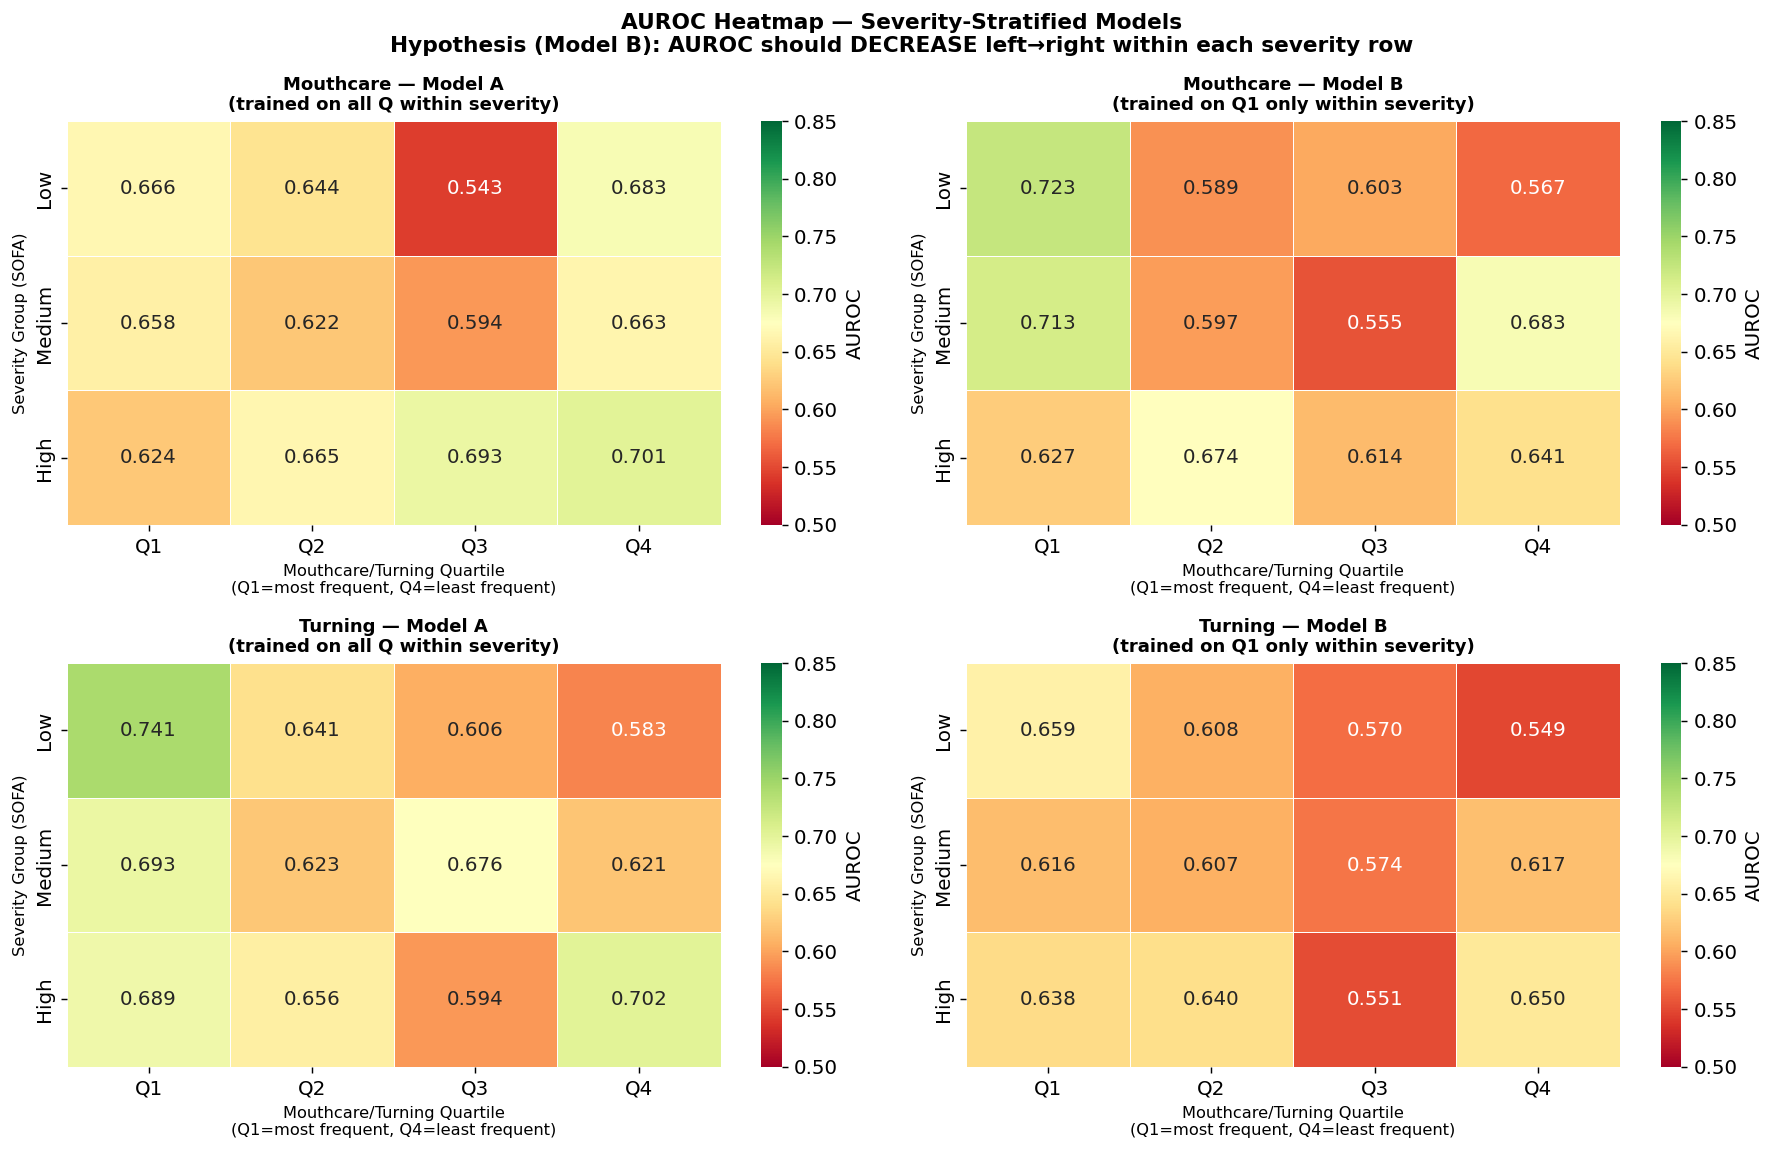

Saved: fig1_auc_heatmap.png


In [9]:
def auc_pivot(results_df, care_label, model_name):
    sub = results_df[
        (results_df['Care Type'] == care_label) &
        (results_df['Model'] == model_name)
    ].copy()
    sub['Q'] = sub['Test Set'].str.extract(r'(Q\d)')
    pivot = sub.pivot_table(index='Severity', columns='Q', values='AUROC', aggfunc='first')
    existing_q = [q for q in QUARTILES if q in pivot.columns]
    pivot = pivot[existing_q]
    pivot.index = pd.CategoricalIndex(pivot.index, categories=SEVERITY_LABELS, ordered=True)
    return pivot.sort_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
titles = [
    ('Mouthcare','A – All Quartiles','Mouthcare — Model A\n(trained on all Q within severity)'),
    ('Mouthcare','B – Q1 Only',      'Mouthcare — Model B\n(trained on Q1 only within severity)'),
    ('Turning',  'A – All Quartiles','Turning — Model A\n(trained on all Q within severity)'),
    ('Turning',  'B – Q1 Only',      'Turning — Model B\n(trained on Q1 only within severity)'),
]
for ax, (care, model, title) in zip(axes.flat, titles):
    try:
        piv = auc_pivot(results_df, care, model)
        sns.heatmap(piv.astype(float), annot=True, fmt='.3f',
                    cmap='RdYlGn', vmin=0.50, vmax=0.85,
                    ax=ax, linewidths=0.5, linecolor='white',
                    cbar_kws={'label':'AUROC'})
        ax.set_title(title, fontweight='bold', fontsize=10)
        ax.set_xlabel('Mouthcare/Turning Quartile\n(Q1=most frequent, Q4=least frequent)', fontsize=9)
        ax.set_ylabel('Severity Group (SOFA)', fontsize=9)
    except Exception as e:
        ax.text(0.5,0.5,f'No data\n{e}',ha='center',va='center',transform=ax.transAxes)

plt.suptitle('AUROC Heatmap — Severity-Stratified Models\n'
             'Hypothesis (Model B): AUROC should DECREASE left→right within each severity row',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER,'fig1_auc_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: fig1_auc_heatmap.png')

## 10. Discriminative Performance — AUROC with 95% Bootstrap Confidence Intervals

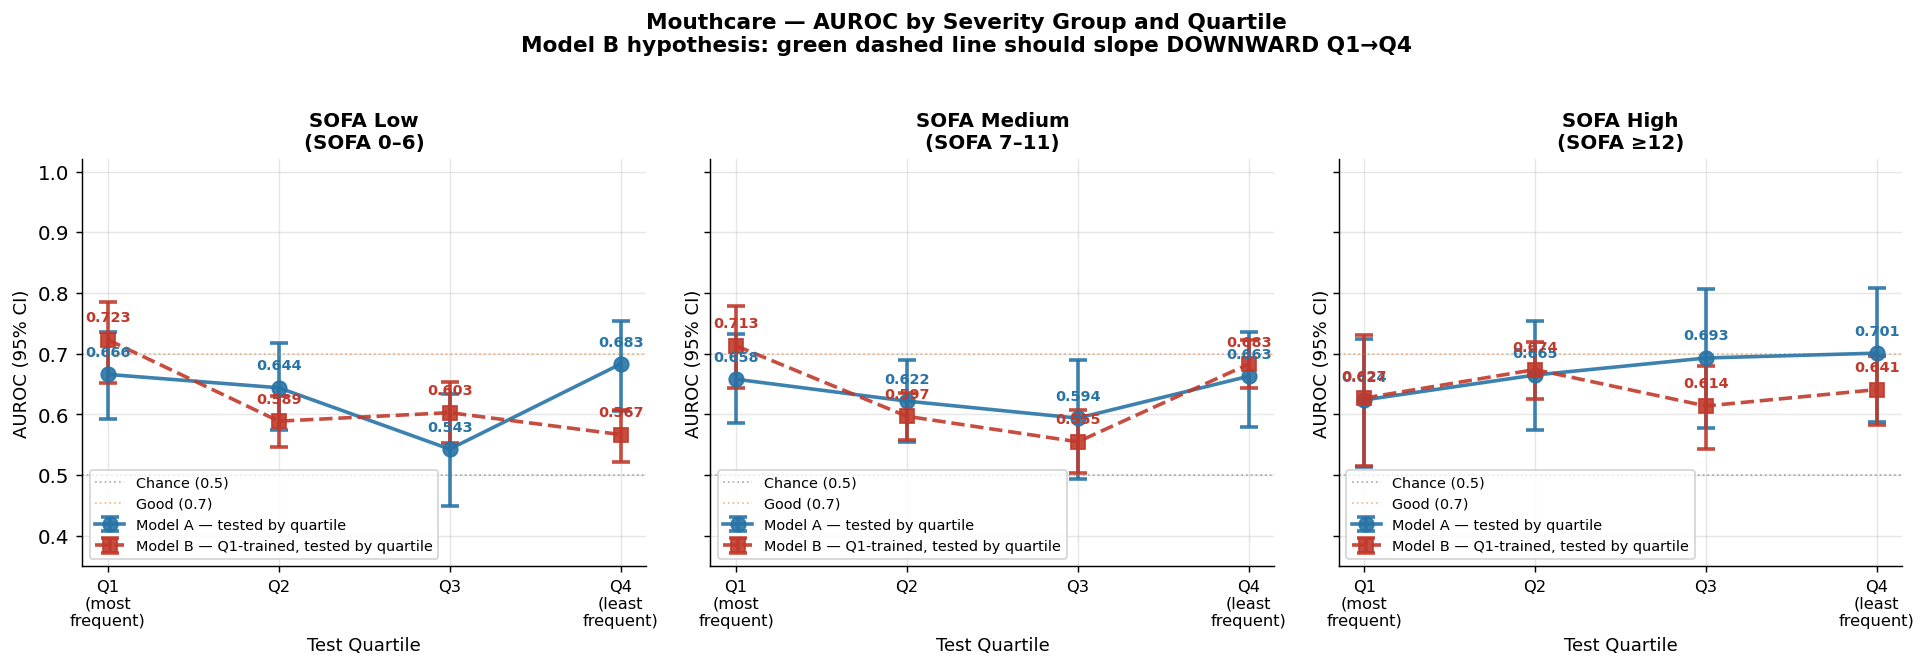

  Saved: figures\fig2a_auroc_mouthcare.png


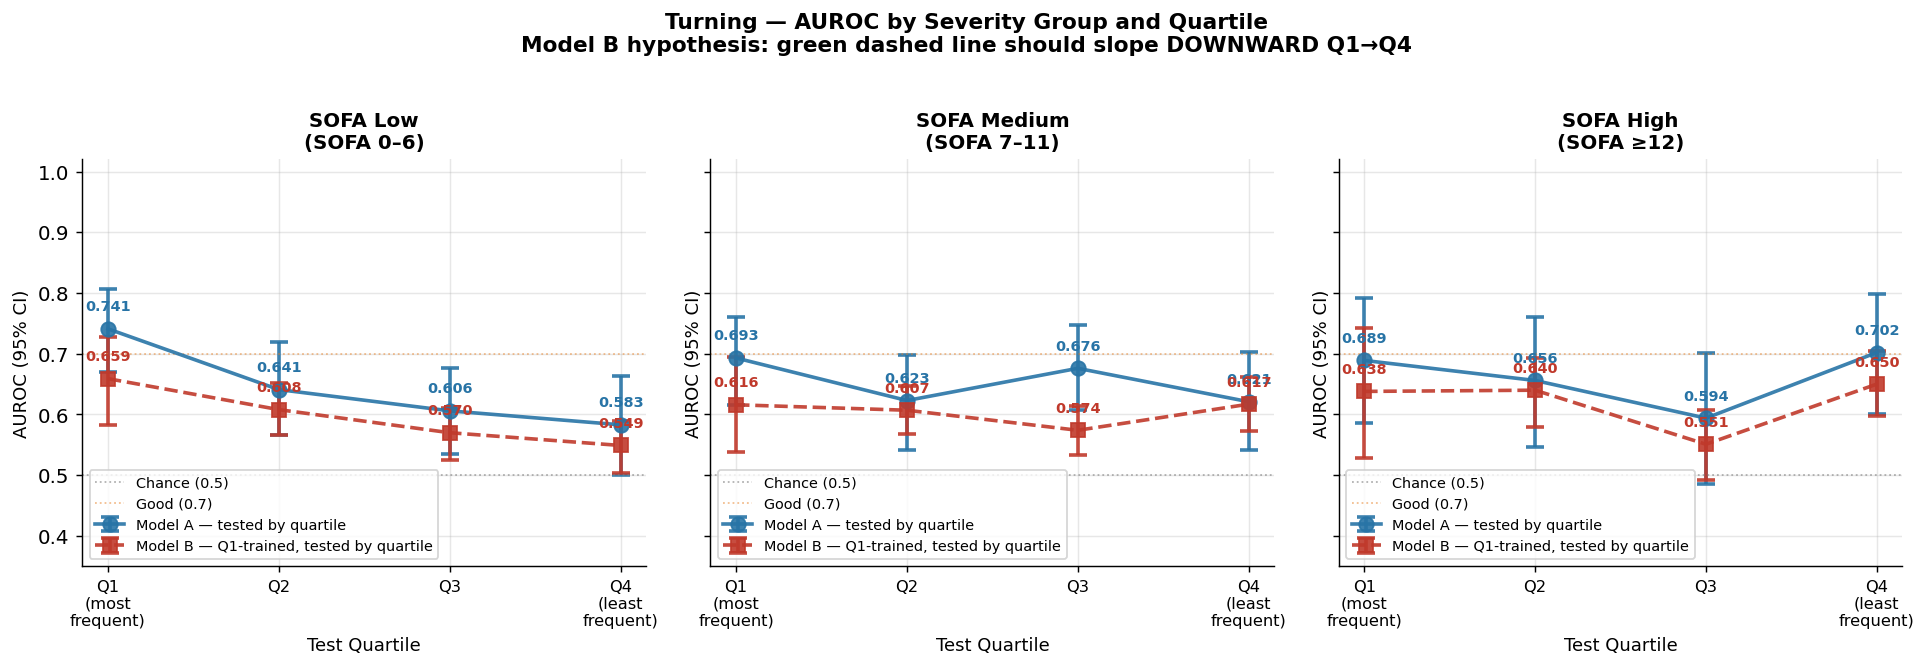

  Saved: figures\fig2b_auroc_turning.png


In [10]:
def plot_auroc_lines(results_df, care_label, save_path):
    sevs = SEVERITY_LABELS
    fig, axes = plt.subplots(1, len(sevs), figsize=(5*len(sevs), 5), sharey=True)

    for ax, sev in zip(axes, sevs):
        sub = results_df[
            (results_df['Care Type'] == care_label) &
            (results_df['Severity'] == sev)
        ]
        for mname, style in MODEL_STYLES.items():
            mdf = sub[sub['Model'] == mname].copy()
            mdf['Q'] = mdf['Test Set'].str.extract(r'(Q\d)')
            mdf = mdf.dropna(subset=['Q','AUROC']).sort_values('Q')
            if len(mdf) == 0:
                continue
            x    = np.arange(len(mdf))
            auc  = mdf['AUROC'].values.astype(float)
            lo   = mdf['AUROC_lo'].values.astype(float)
            hi   = mdf['AUROC_hi'].values.astype(float)
            yerr = np.array([auc-lo, hi-auc])
            ax.errorbar(x, auc, yerr=yerr,
                        color=style['color'], marker=style['marker'],
                        linestyle=style['ls'], linewidth=2, markersize=8,
                        capsize=5, capthick=2, label=style['label'],
                        ecolor=style['color'], alpha=0.9)
            for xi, ai in enumerate(auc):
                ax.annotate(f'{ai:.3f}', (xi,ai),
                            textcoords='offset points', xytext=(0,10),
                            ha='center', fontsize=8, color=style['color'], fontweight='bold')

        ax.axhline(0.5, color='grey', ls=':', lw=1, alpha=0.6, label='Chance (0.5)')
        ax.axhline(0.7, color='#E67E22', ls=':', lw=1, alpha=0.5, label='Good (0.7)')
        ax.set_xticks(range(len(QUARTILES)))
        ax.set_xticklabels(['Q1\n(most\nfrequent)','Q2','Q3','Q4\n(least\nfrequent)'], fontsize=9)
        ax.set_xlabel('Test Quartile', fontsize=10)
        ax.set_ylim(0.35, 1.02)
        ax.set_title(f'SOFA {sev}\n(SOFA {"0–6" if sev=="Low" else "7–11" if sev=="Medium" else "≥12"})',
                     fontweight='bold', fontsize=11)
        ax.set_ylabel('AUROC (95% CI)', fontsize=10)
        ax.legend(fontsize=8, loc='lower left')

    fig.suptitle(f'{care_label} — AUROC by Severity Group and Quartile\n'
                 f'Model B hypothesis: green dashed line should slope DOWNWARD Q1→Q4',
                 fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'  Saved: {save_path}')

plot_auroc_lines(results_df, 'Mouthcare',
                 os.path.join(OUTPUT_FOLDER,'fig2a_auroc_mouthcare.png'))
plot_auroc_lines(results_df, 'Turning',
                 os.path.join(OUTPUT_FOLDER,'fig2b_auroc_turning.png'))

## 10b. Statistical Validation — Is Model B Degradation Real?

Three complementary statistical tests are used to determine whether Model B's declining AUROC from Q1 to Q4 represents a statistically significant trend rather than sampling variation:

1. **DeLong test** — directly compares AUROC between two test sets (Q1 vs Q4) using the method of DeLong et al. (1988), which accounts for the correlation structure of ROC curves. A significant result (p < 0.05) confirms that Model B performs meaningfully worse on Q4 than Q1.

2. **Jonckheere-Terpstra trend test** — tests for a monotonic decreasing trend in AUROC across ordered groups (Q1 > Q2 > Q3 > Q4). This is more powerful than pairwise comparisons when a directional hypothesis is specified a priori.

3. **Bootstrap 95% CI non-overlap** — if the confidence intervals for Q1 and Q4 AUROC do not overlap, the difference is significant at approximately p < 0.05.

The same tests are applied to Model A's race-based generalisation to enable direct comparison: if Model B's quartile-based degradation is statistically significant while Model A's race-based variation is not, this supports the argument that care frequency — not race — is the primary axis of outcome disparity.

In [11]:
from scipy import stats
from scipy.stats import chi2

# ── DeLong test implementation ────────────────────────────────────────────────
def delong_roc_variance(ground_truth, predictions):
    """
    DeLong et al. (1988) method for AUROC variance.
    Returns AUC and its variance for use in hypothesis testing.
    """
    ground_truth = np.array(ground_truth)
    predictions  = np.array(predictions)
    n1 = np.sum(ground_truth == 1)
    n0 = np.sum(ground_truth == 0)
    pos_probs = predictions[ground_truth == 1]
    neg_probs = predictions[ground_truth == 0]

    # Placement values
    V10 = np.array([np.mean(p > neg_probs) + 0.5 * np.mean(p == neg_probs) for p in pos_probs])
    V01 = np.array([np.mean(p < pos_probs) + 0.5 * np.mean(p == pos_probs) for p in neg_probs])

    auc = np.mean(V10)
    s10 = np.var(V10, ddof=1) / n1
    s01 = np.var(V01, ddof=1) / n0
    var = s10 + s01
    return auc, var


def delong_test(y_true_A, y_prob_A, y_true_B, y_prob_B):
    """
    Two-sample DeLong test comparing AUROC of two independent test sets.
    Returns: auc_A, auc_B, z_statistic, p_value
    """
    auc_A, var_A = delong_roc_variance(y_true_A, y_prob_A)
    auc_B, var_B = delong_roc_variance(y_true_B, y_prob_B)
    if var_A + var_B == 0:
        return auc_A, auc_B, np.nan, np.nan
    z = (auc_A - auc_B) / np.sqrt(var_A + var_B)
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return auc_A, auc_B, z, p


# ── Jonckheere-Terpstra trend test (using scipy) ──────────────────────────────
def jonckheere_trend_test(groups_auroc_samples):
    """
    Test for monotonic decreasing trend across ordered groups.
    groups_auroc_samples: list of bootstrap AUROC arrays, ordered Q1..Q4
    Uses Jonckheere-Terpstra statistic approximated via Mann-Whitney U.
    Returns: statistic, p_value
    """
    k = len(groups_auroc_samples)
    jt_stat = 0
    for i in range(k-1):
        for j in range(i+1, k):
            u, _ = stats.mannwhitneyu(
                groups_auroc_samples[i], groups_auroc_samples[j],
                alternative='greater'  # expects group i > group j (Q1 > Q4)
            )
            jt_stat += u
    # Approximate p-value using normal approximation
    n_i = [len(g) for g in groups_auroc_samples]
    N   = sum(n_i)
    E   = (N**2 - sum(n**2 for n in n_i)) / 4
    V   = (N**2*(2*N+3) - sum(n**2*(2*n+3) for n in n_i)) / 72
    if V <= 0:
        return jt_stat, np.nan
    z   = (jt_stat - E) / np.sqrt(V)
    p   = 1 - stats.norm.cdf(z)
    return jt_stat, p


# ── Bootstrap AUROC samples per group (for JT test) ──────────────────────────
def bootstrap_auroc_samples(y_true, y_prob, n=1000, seed=42):
    rng    = np.random.default_rng(seed)
    yt, yp = np.array(y_true), np.array(y_prob)
    idx    = np.arange(len(yt))
    aucs   = []
    for _ in range(n):
        b = rng.choice(idx, size=len(idx), replace=True)
        if len(np.unique(yt[b])) < 2:
            continue
        aucs.append(roc_auc_score(yt[b], yp[b]))
    return np.array(aucs)


# ── Run all statistical tests ─────────────────────────────────────────────────
def run_stat_tests(calibration_store, care_label, sev_label):
    """
    For a given care type and severity:
    1. DeLong test: Model B Q1 vs Q4
    2. JT trend test: Model B Q1..Q4
    3. DeLong test: Model A race group variation (White vs Black as anchor)
    """
    print(f'\n{"="*65}')
    print(f'  Statistical Tests — {care_label} | {sev_label}')
    print(f'{"="*65}')

    # Retrieve calibration data for Model B quartiles
    b_data = {g: (yt, yp) for (cl,sl,mn,gt,g,yt,yp) in calibration_store
              if cl==care_label and sl==sev_label and mn=='B – Q1 Only' and gt=='quartile'}

    if 'Q1' not in b_data or 'Q4' not in b_data:
        print('  Insufficient data for Model B tests.')
        return {}

    results = {}

    # 1. DeLong: Model B Q1 vs Q4
    yt1, yp1 = b_data['Q1']
    yt4, yp4 = b_data['Q4']
    auc1, auc4, z, p = delong_test(yt1, yp1, yt4, yp4)
    results['delong_B_Q1vsQ4'] = {'AUC_Q1':round(auc1,3),'AUC_Q4':round(auc4,3),
                                   'z':round(z,3) if not np.isnan(z) else np.nan,
                                   'p':round(p,4) if not np.isnan(p) else np.nan}
    sig = 'SIGNIFICANT' if (not np.isnan(p) and p < 0.05) else 'not significant'
    print(f'\n1. DeLong test — Model B: Q1 vs Q4')
    print(f'   AUC Q1={auc1:.3f}  AUC Q4={auc4:.3f}  z={z:.3f}  p={p:.4f}  [{sig}]')
    print(f'   Interpretation: Model B performs {"significantly" if sig=="SIGNIFICANT" else "non-significantly"} '
          f'{"worse" if auc1>auc4 else "better"} on Q4 vs Q1 patients.')

    # 2. Jonckheere-Terpstra: Model B Q1..Q4 trend
    boot_samples = []
    for q in QUARTILES:
        if q in b_data:
            yt, yp = b_data[q]
            boot_samples.append(bootstrap_auroc_samples(yt, yp, n=500))
    if len(boot_samples) >= 3:
        jt, p_jt = jonckheere_trend_test(boot_samples)
        results['jt_B_trend'] = {'stat':round(jt,1),'p':round(p_jt,4) if not np.isnan(p_jt) else np.nan}
        sig_jt = 'SIGNIFICANT' if (not np.isnan(p_jt) and p_jt < 0.05) else 'not significant'
        print(f'\n2. Jonckheere-Terpstra trend test — Model B Q1→Q4')
        print(f'   JT statistic={jt:.1f}  p={p_jt:.4f}  [{sig_jt}]')
        print(f'   Interpretation: {"Monotonic decreasing trend confirmed" if sig_jt=="SIGNIFICANT" else "No significant monotonic trend"} '
              f'in Model B AUROC from Q1 to Q4.')

    # 3. CI non-overlap check
    boot1 = bootstrap_auroc_samples(yt1, yp1, n=1000)
    boot4 = bootstrap_auroc_samples(yt4, yp4, n=1000)
    ci1   = (np.percentile(boot1,2.5), np.percentile(boot1,97.5))
    ci4   = (np.percentile(boot4,2.5), np.percentile(boot4,97.5))
    overlap = ci1[0] < ci4[1] and ci4[0] < ci1[1]
    results['ci_overlap'] = {'Q1_CI':ci1,'Q4_CI':ci4,'overlap':overlap}
    print(f'\n3. Bootstrap 95% CI non-overlap — Model B')
    print(f'   Q1 AUROC: {ci1[0]:.3f}–{ci1[1]:.3f}  |  Q4 AUROC: {ci4[0]:.3f}–{ci4[1]:.3f}')
    print(f'   CIs {"OVERLAP — difference may not be significant" if overlap else "DO NOT OVERLAP — significant difference confirmed"}')

    # 4. DeLong: Model A race variation (White vs Black, largest groups)
    race_data = {g: (yt, yp) for (cl,sl,mn,gt,g,yt,yp) in calibration_store
                 if cl==care_label and sl==sev_label and mn=='A – By Race' and gt=='race'}

    if 'White' in race_data and 'Black' in race_data:
        ytW, ypW = race_data['White']
        ytB, ypB = race_data['Black']
        aucW, aucB, zR, pR = delong_test(ytW, ypW, ytB, ypB)
        results['delong_A_WhitevsBlack'] = {'AUC_White':round(aucW,3),'AUC_Black':round(aucB,3),
                                            'z':round(zR,3),'p':round(pR,4)}
        sig_r = 'SIGNIFICANT' if pR < 0.05 else 'not significant'
        print(f'\n4. DeLong test — Model A (by race): White vs Black')
        print(f'   AUC White={aucW:.3f}  AUC Black={aucB:.3f}  z={zR:.3f}  p={pR:.4f}  [{sig_r}]')
        print(f'   Interpretation: Race-based AUROC difference is {sig_r}.')
        print(f'\n   KEY COMPARISON:')
        print(f'   Model B quartile gap (Q1-Q4): {auc1-auc4:.3f}  p={p:.4f}')
        print(f'   Model A race gap (White-Black): {aucW-aucB:.3f}  p={pR:.4f}')
        if abs(auc1-auc4) > abs(aucW-aucB):
            print('   → Care frequency quartile produces LARGER AUROC degradation than race.')
            print('     This supports the hypothesis that care access is a stronger predictor')
            print('     of outcome disparity than racial group membership.')
        else:
            print('   → Race produces larger AUROC gap than care frequency quartile.')

    return results


# Run tests for all combinations
stat_results = {}
for care in ['Mouthcare','Turning']:
    for sev in SEVERITY_LABELS:
        key = (care, sev)
        stat_results[key] = run_stat_tests(calibration_store, care, sev)



  Statistical Tests — Mouthcare | Low

1. DeLong test — Model B: Q1 vs Q4
   AUC Q1=0.721  AUC Q4=0.567  z=3.835  p=0.0001  [SIGNIFICANT]
   Interpretation: Model B performs significantly worse on Q4 vs Q1 patients.

2. Jonckheere-Terpstra trend test — Model B Q1→Q4
   JT statistic=1242395.0  p=0.0000  [SIGNIFICANT]
   Interpretation: Monotonic decreasing trend confirmed in Model B AUROC from Q1 to Q4.

3. Bootstrap 95% CI non-overlap — Model B
   Q1 AUROC: 0.652–0.786  |  Q4 AUROC: 0.522–0.608
   CIs DO NOT OVERLAP — significant difference confirmed

4. DeLong test — Model A (by race): White vs Black
   AUC White=0.900  AUC Black=0.906  z=-0.250  p=0.8024  [not significant]
   Interpretation: Race-based AUROC difference is not significant.

   KEY COMPARISON:
   Model B quartile gap (Q1-Q4): 0.155  p=0.0001
   Model A race gap (White-Black): -0.007  p=0.8024
   → Care frequency quartile produces LARGER AUROC degradation than race.
     This supports the hypothesis that care access is

## 10c. AUROC Comparison — Care Frequency Quartile vs Race Group Generalisation

This plot directly compares how much AUROC changes when the same model is generalised across different axes of variation. The central argument is that Model B's care-frequency-driven degradation (Q1→Q4) is larger and more clinically meaningful than Model A's race-group variation — indicating that care access patterns explain more outcome variance than race alone.

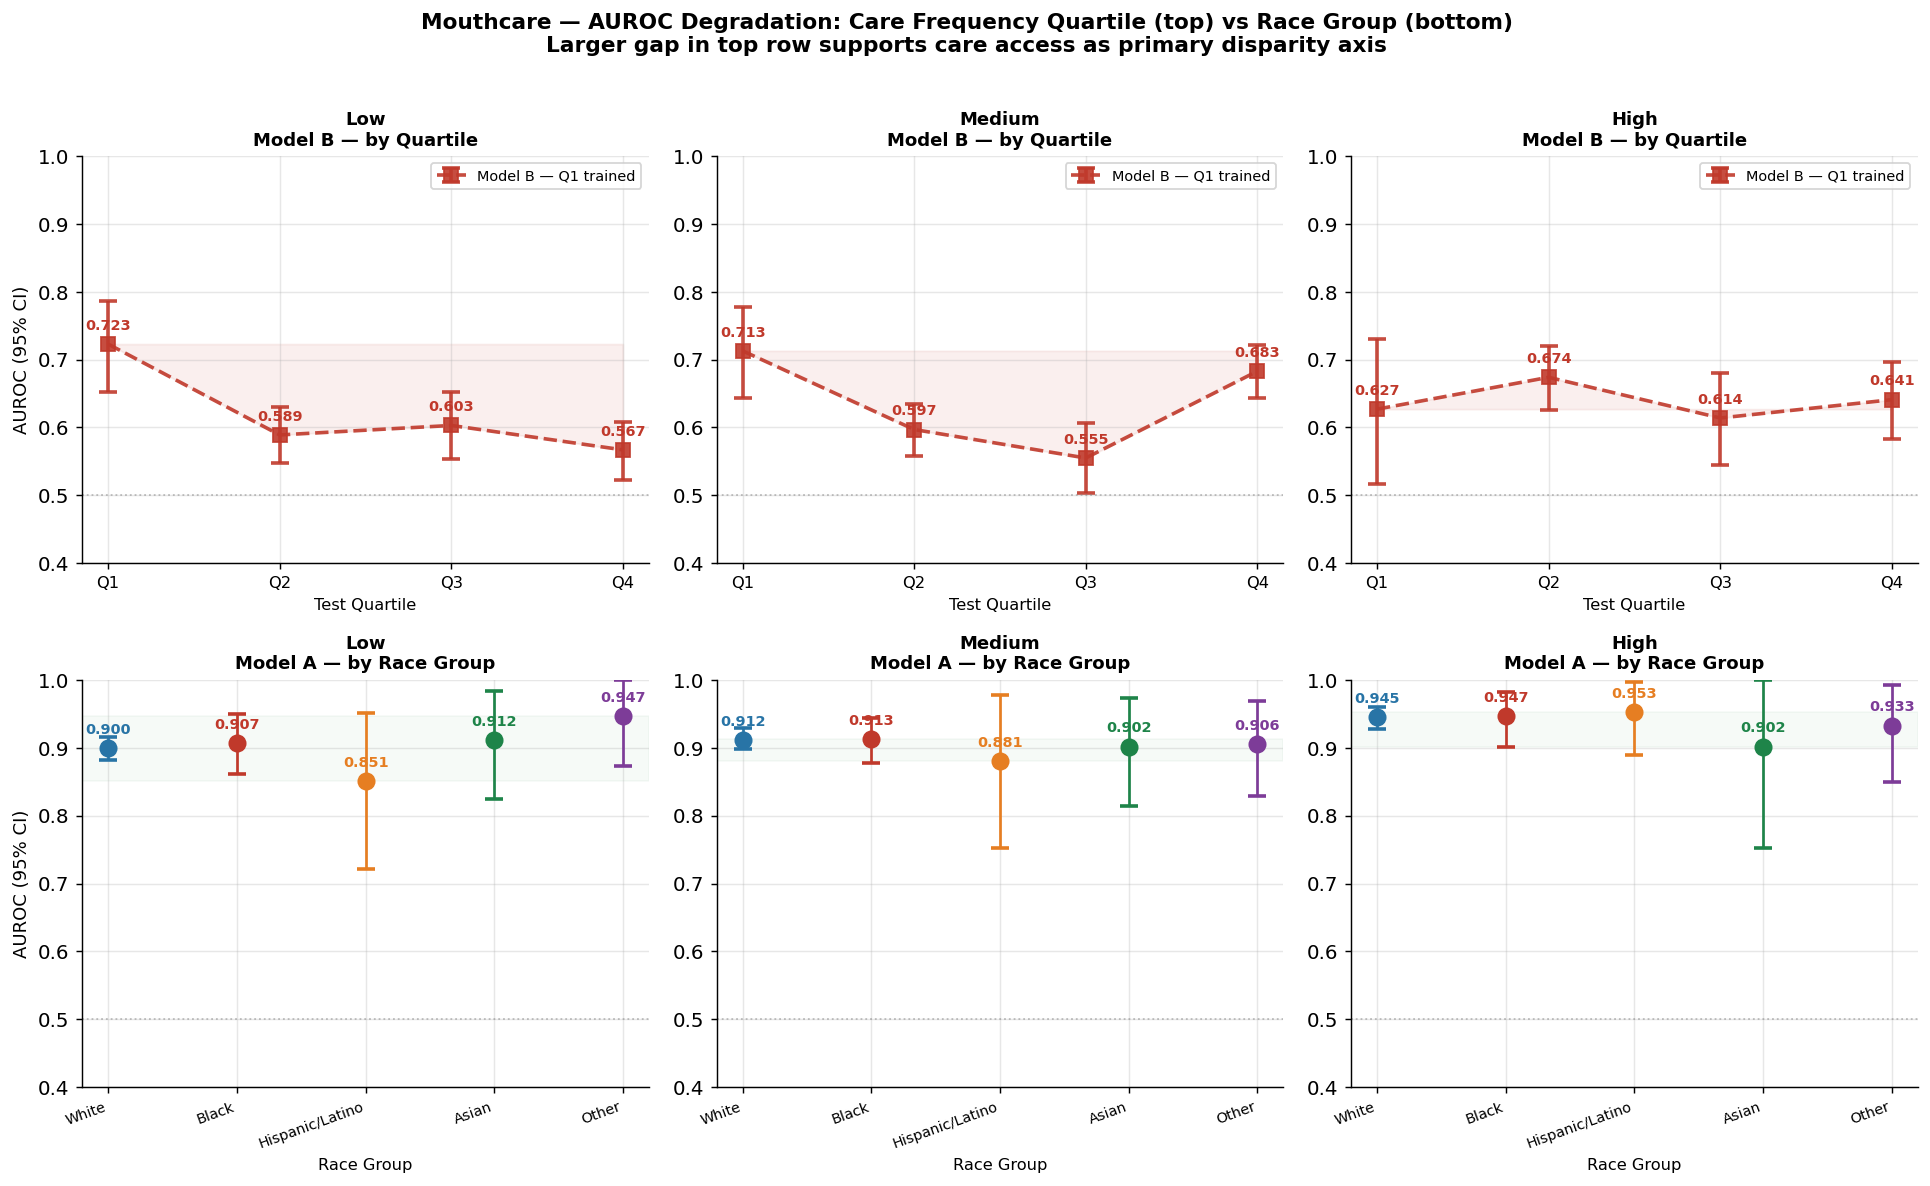

Saved: figures\fig_comparison_mouthcare.png


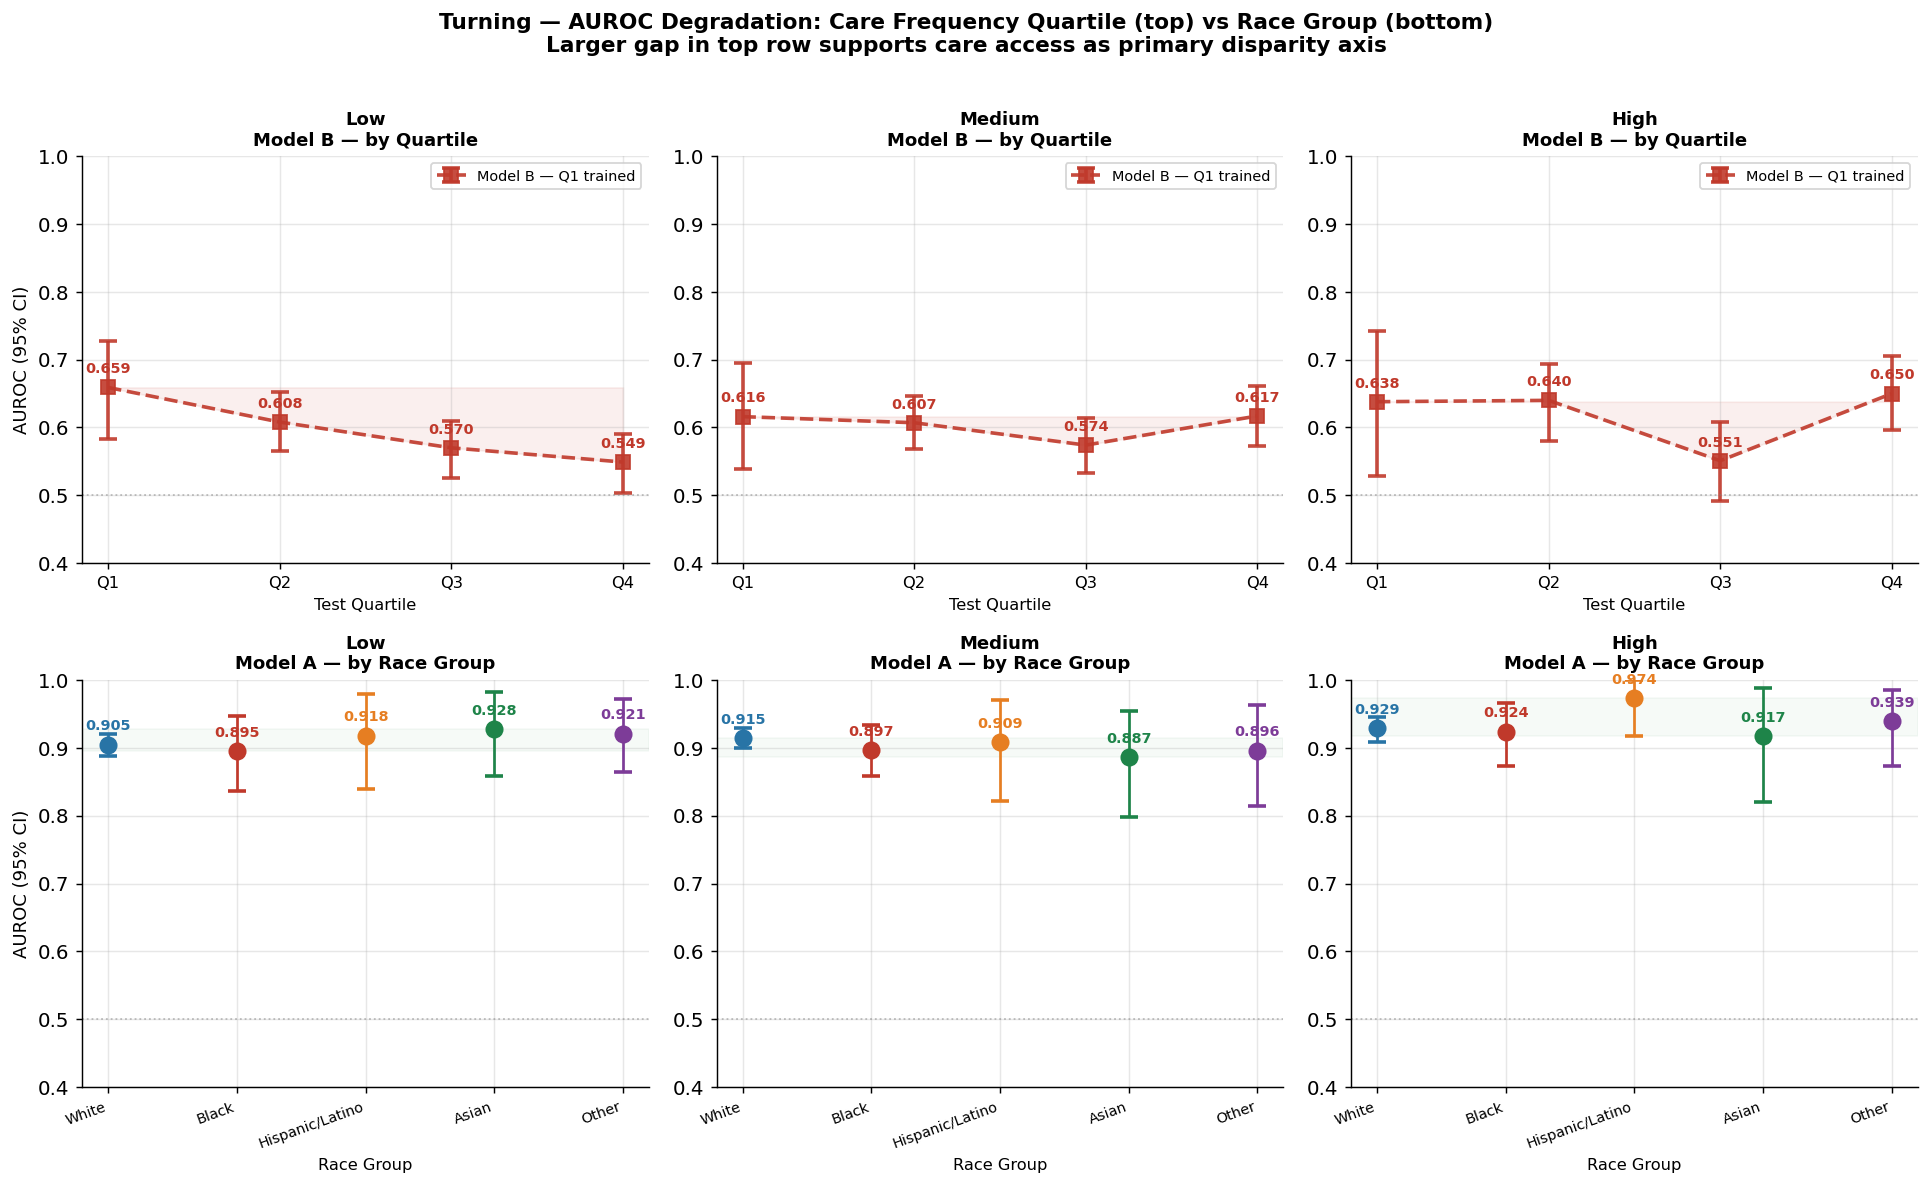

Saved: figures\fig_comparison_turning.png


In [12]:
def plot_quartile_vs_race_comparison(results_df, care_label, save_path):
    """
    Side-by-side AUROC comparison:
    Left panels  — Model B tested by quartile (Q1..Q4) per severity
    Right panels — Model A tested by race group per severity
    Allows visual comparison of generalisation gaps.
    """
    sevs = SEVERITY_LABELS
    fig, axes = plt.subplots(2, len(sevs), figsize=(5*len(sevs), 9))

    df = results_df[results_df['Care Type'] == care_label]

    for col_i, sev in enumerate(sevs):
        sub = df[df['Severity'] == sev]

        # ── Top row: Model B by quartile ──────────────────────────────────────
        ax_top = axes[0, col_i]
        mdf = sub[sub['Model'] == 'B – Q1 Only'].copy()
        mdf['q_label'] = mdf['Test Set'].str.extract(r'(Q\d)')
        mdf = mdf.dropna(subset=['q_label','AUROC']).sort_values('q_label')

        if len(mdf) > 0:
            x    = np.arange(len(mdf))
            auc  = mdf['AUROC'].values.astype(float)
            lo   = mdf['AUROC_lo'].values.astype(float)
            hi   = mdf['AUROC_hi'].values.astype(float)
            yerr = np.array([auc-lo, hi-auc])
            ax_top.errorbar(x, auc, yerr=yerr,
                            color='#C0392B', marker='s', linestyle='--',
                            linewidth=2, markersize=8, capsize=5, capthick=2,
                            ecolor='#C0392B', alpha=0.9,
                            label='Model B — Q1 trained')
            for xi, ai in enumerate(auc):
                ax_top.annotate(f'{ai:.3f}', (xi, ai),
                                textcoords='offset points', xytext=(0,8),
                                ha='center', fontsize=8, color='#C0392B', fontweight='bold')
            ax_top.set_xticks(x)
            ax_top.set_xticklabels(mdf['q_label'].values, fontsize=9)
            # Shade to show degradation
            if len(auc) >= 2:
                ax_top.fill_between(x, auc, auc[0], alpha=0.08, color='#C0392B')

        ax_top.axhline(0.5, color='grey', ls=':', lw=1, alpha=0.5)
        ax_top.set_ylim(0.4, 1.0)
        ax_top.set_title(f'{sev}\nModel B — by Quartile', fontweight='bold', fontsize=10)
        ax_top.set_xlabel('Test Quartile', fontsize=9)
        if col_i == 0:
            ax_top.set_ylabel('AUROC (95% CI)', fontsize=10)
        ax_top.legend(fontsize=8)

        # ── Bottom row: Model A by race ───────────────────────────────────────
        ax_bot = axes[1, col_i]
        rdf = sub[sub['Model'] == 'A – By Race'].copy()
        # Extract race label from 'Race: White' format
        rdf['race_label'] = rdf['Test Set'].str.replace('Race: ','', regex=False)
        rdf = rdf.dropna(subset=['race_label','AUROC'])
        # Order by RACE_LABELS
        rdf['race_order'] = rdf['race_label'].map({r:i for i,r in enumerate(RACE_LABELS)})
        rdf = rdf.sort_values('race_order')

        if len(rdf) > 0:
            x    = np.arange(len(rdf))
            auc  = rdf['AUROC'].values.astype(float)
            lo   = rdf['AUROC_lo'].values.astype(float)
            hi   = rdf['AUROC_hi'].values.astype(float)
            yerr = np.array([auc-lo, hi-auc])
            colors_r = [RACE_COLOURS.get(r,'grey') for r in rdf['race_label']]
            for xi, (ai, ci_col, loi, hii) in enumerate(zip(auc, colors_r, lo, hi)):
                ax_bot.errorbar(xi, ai, yerr=[[ai-loi],[hii-ai]],
                                color=ci_col, marker='o', linestyle='none',
                                markersize=9, capsize=5, capthick=2, ecolor=ci_col)
                ax_bot.annotate(f'{ai:.3f}', (xi, ai),
                                textcoords='offset points', xytext=(0,8),
                                ha='center', fontsize=8, color=ci_col, fontweight='bold')
            ax_bot.set_xticks(x)
            ax_bot.set_xticklabels(rdf['race_label'].values, fontsize=8, rotation=20, ha='right')
            # Range line showing spread
            ax_bot.axhspan(auc.min(), auc.max(), alpha=0.04, color='#1E8449')

        ax_bot.axhline(0.5, color='grey', ls=':', lw=1, alpha=0.5)
        ax_bot.set_ylim(0.4, 1.0)
        ax_bot.set_title(f'{sev}\nModel A — by Race Group', fontweight='bold', fontsize=10)
        ax_bot.set_xlabel('Race Group', fontsize=9)
        if col_i == 0:
            ax_bot.set_ylabel('AUROC (95% CI)', fontsize=10)

    fig.suptitle(
        f'{care_label} — AUROC Degradation: Care Frequency Quartile (top) vs Race Group (bottom)\n'
        f'Larger gap in top row supports care access as primary disparity axis',
        fontsize=12, fontweight='bold', y=1.01
    )
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'Saved: {save_path}')


for care in ['Mouthcare','Turning']:
    plot_quartile_vs_race_comparison(
        results_df, care,
        os.path.join(OUTPUT_FOLDER, f'fig_comparison_{care.lower()}.png')
    )


## 10d. Data Visibility Audit and Four-Model Comparison

### What each model sees — verified from code

| Model | Trained on | `race` in training? | `care type` in training? | Tested on |
|---|---|---|---|---|
| **A – All Quartiles** | 70% of all Q1–Q4, clinical features only | No Never | No Never | 30% of each quartile separately |
| **A – By Race** | Identical to Model A above | No Never | No Never | 100% of each race group (same trained model) |
| **B – Q1 Only** | 70% of Q1 only, clinical features only | No Never | No Never | 30% Q1 held-out + 100% Q2/Q3/Q4 |
| **B – Q1 By Race** | Identical to Model B above | No Never | No Never | 100% of each race group (same trained model) |

**Training features in all models** (`FEATURE_COLS`): SOFA subscores (respiration, cardiovascular, liver, coagulation, renal, CNS) and APS III proxies (heart rate, blood pressure, temperature, respiratory rate, haematocrit, WBC, creatinine, BUN, sodium, albumin, bilirubin, glucose, bicarbonate, GCS min).

**Never used as training features**: `race`, `race_group`, `average_item_interval`, `item_volume`, care type label (Mouthcare/Turning), `gender`, `insurance`, `language`, `admission_location`, `anchor_year_group`.

**Key implication for interpretation**: Any AUROC difference observed across race groups or across quartiles arises entirely from patterns in clinical physiology — not from the model having learned race or care frequency as a predictor. The care type (Mouthcare vs Turning) is used only to load separate datasets and assign quartile labels; it plays no role in model training whatsoever.

### Four-model comparison rationale

The four models test two axes of generalisation:
- **Quartile axis** (Models A and B by quartile): does performance degrade as care frequency decreases?
- **Race axis** (Models A and B by race): does performance vary across racial/ethnic groups?

If care-axis degradation (Q1→Q4 AUROC drop) is larger and more statistically significant than race-axis variation, this supports the hypothesis that care access patterns — not race — are the primary unmeasured driver of outcome disparity in ICU mortality models.

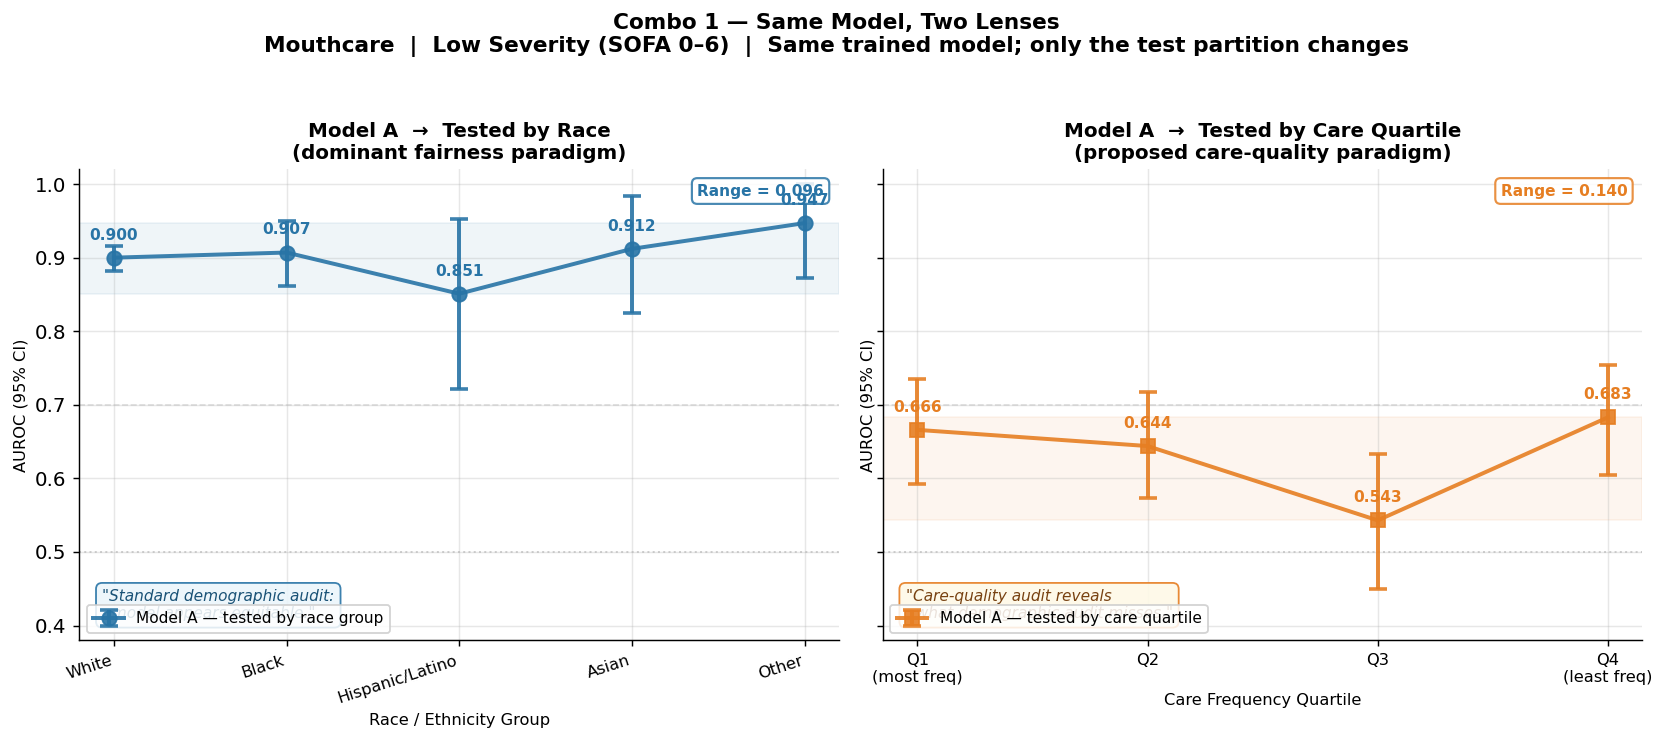

Saved: figures\combo1_samelens_mouthcare_low.png


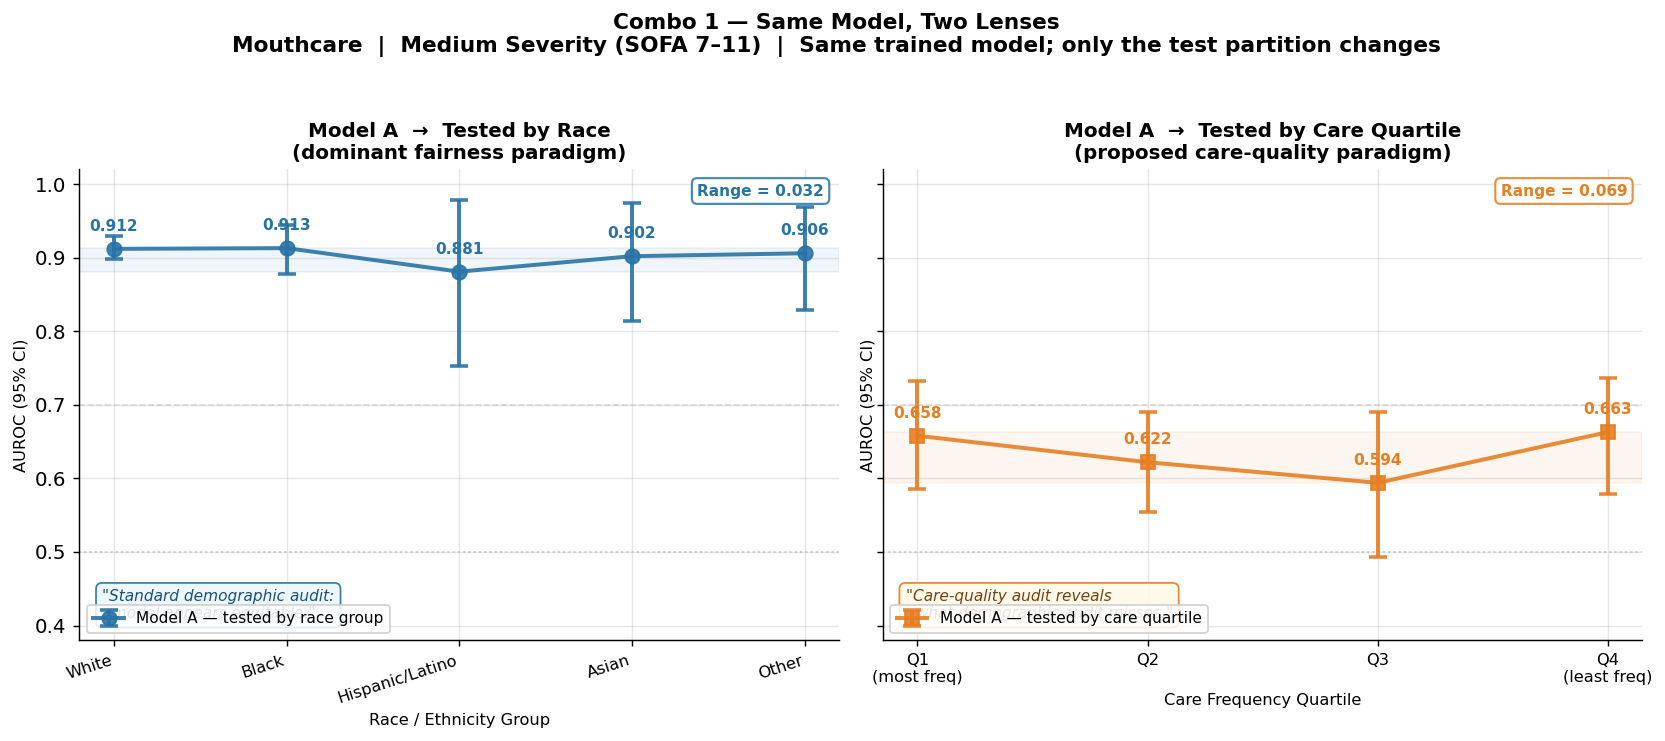

Saved: figures\combo1_samelens_mouthcare_medium.png


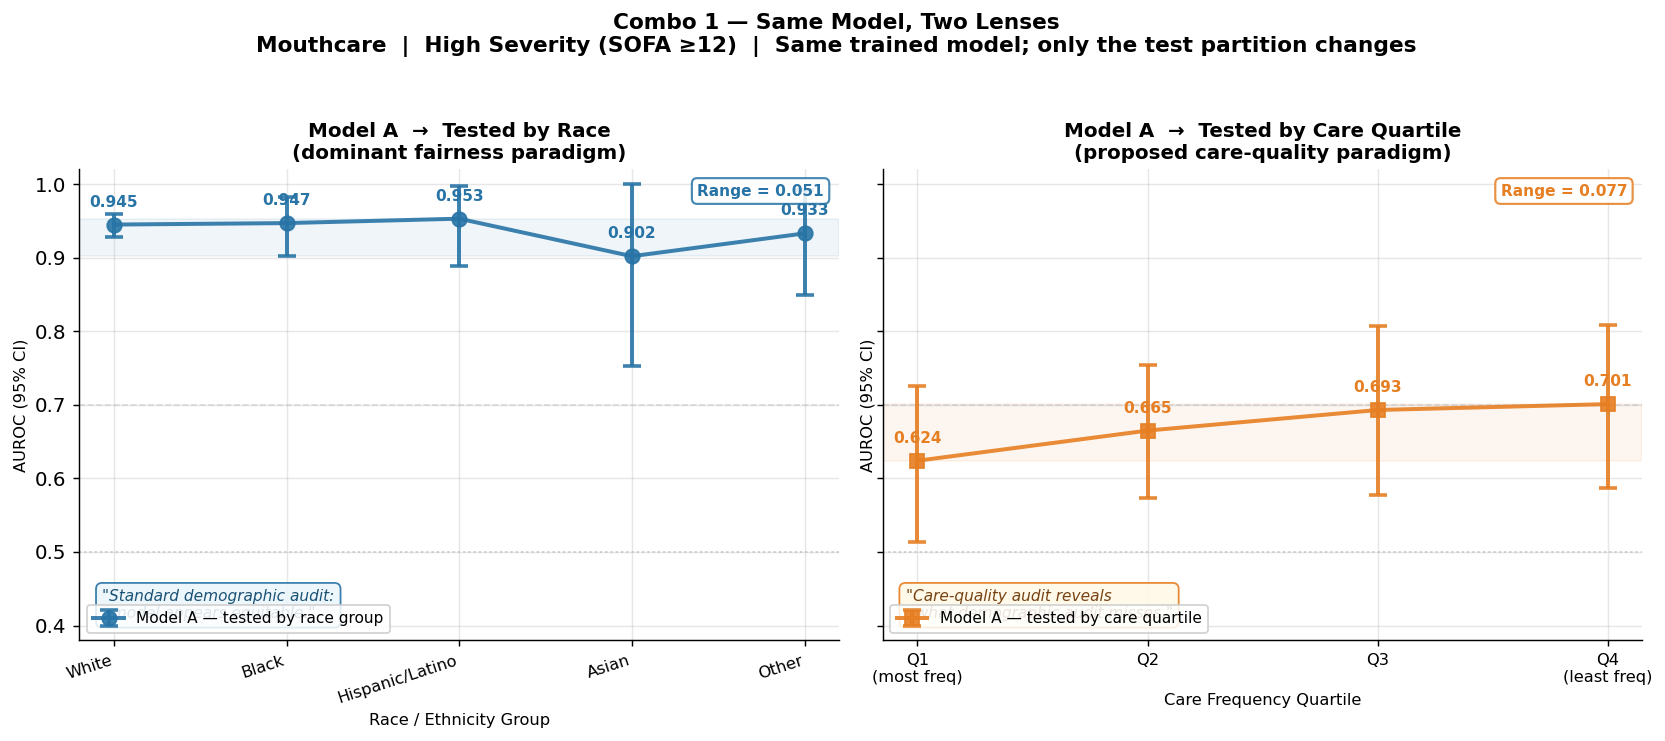

Saved: figures\combo1_samelens_mouthcare_high.png


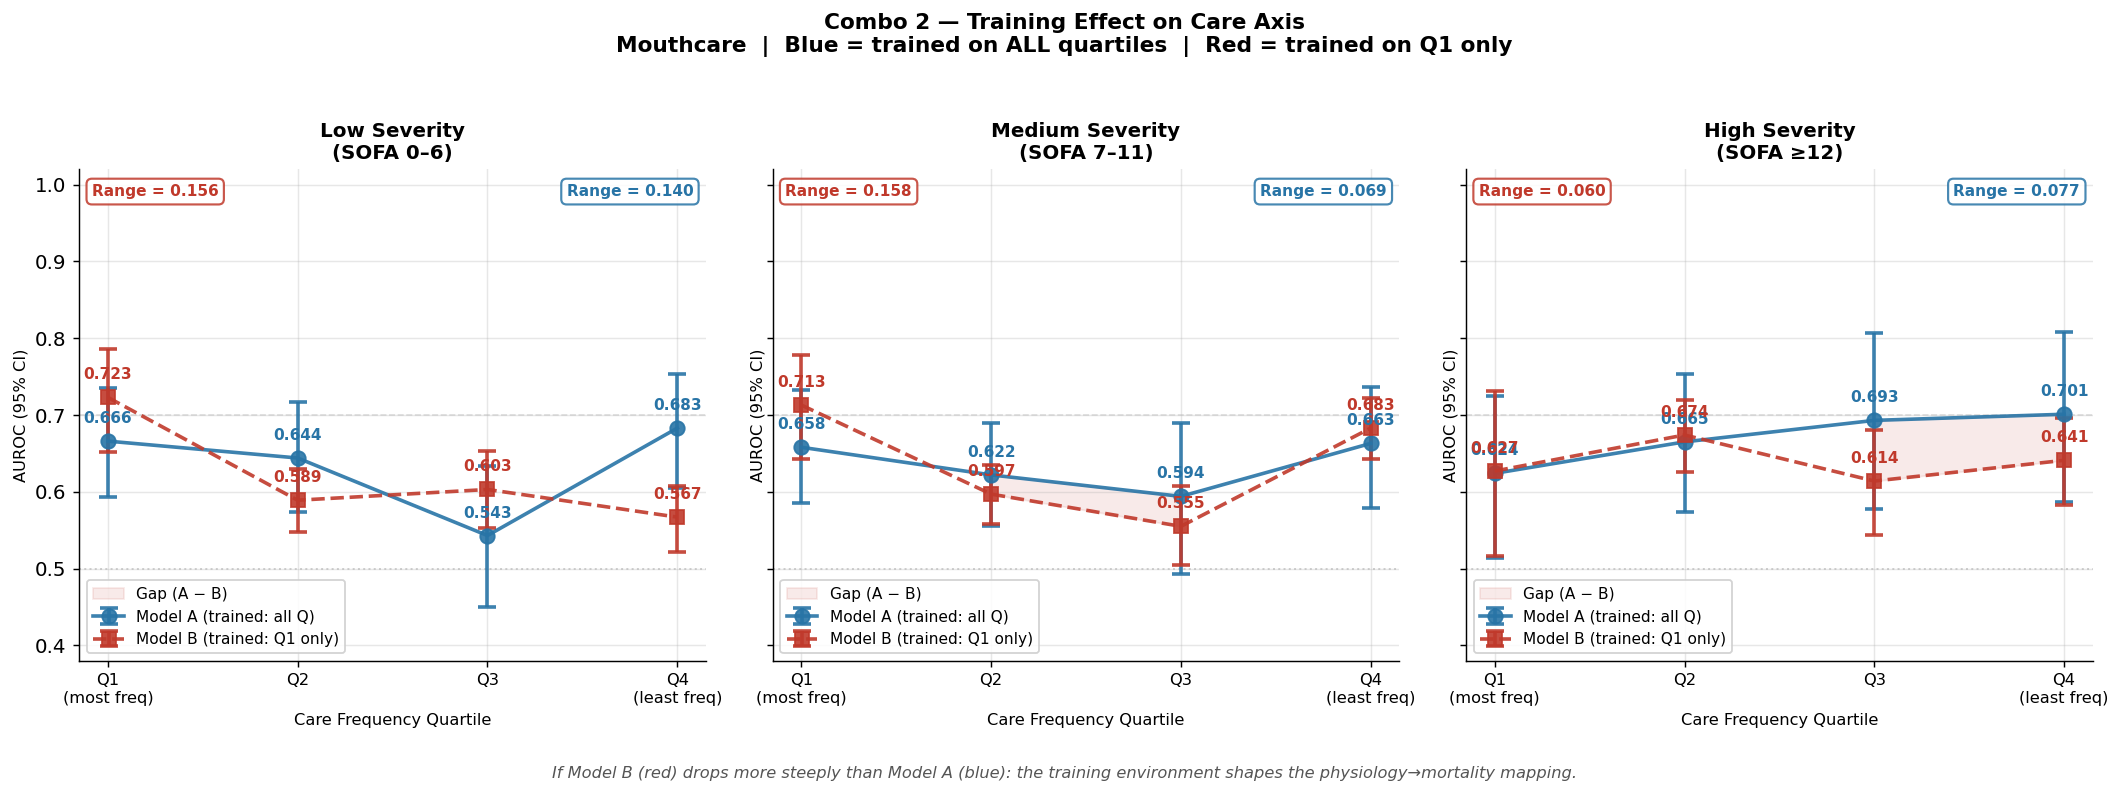

Saved: figures\combo2_training_effect_mouthcare.png


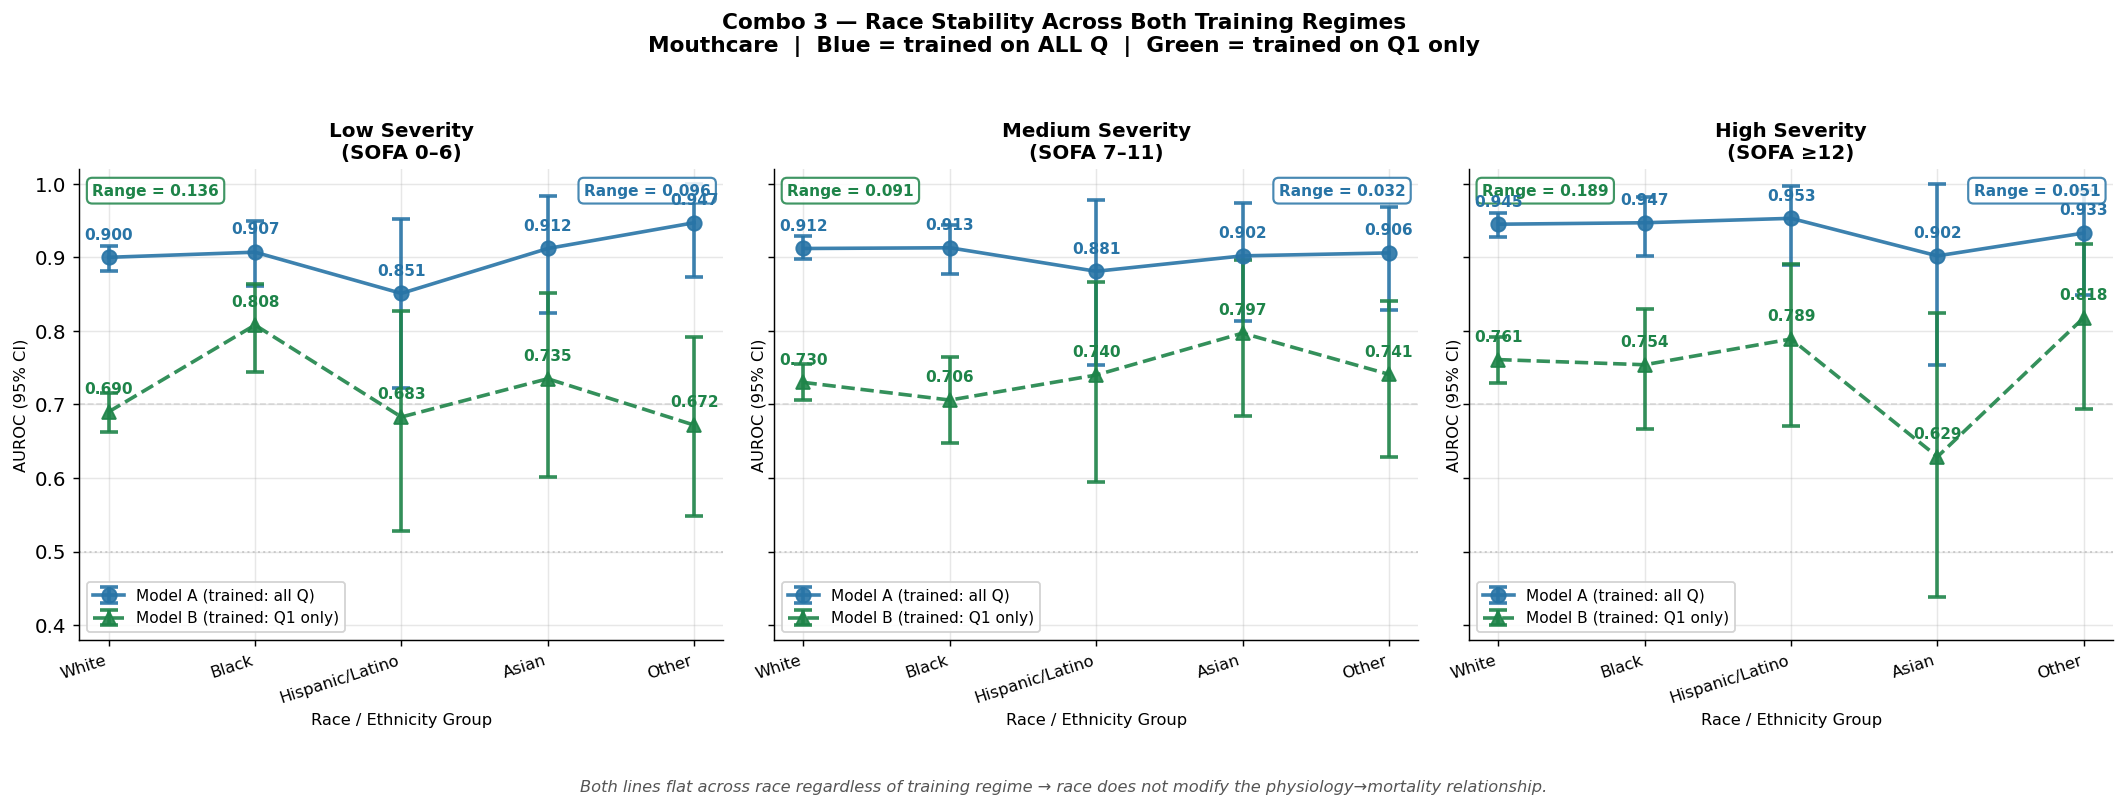

Saved: figures\combo3_race_stability_mouthcare.png


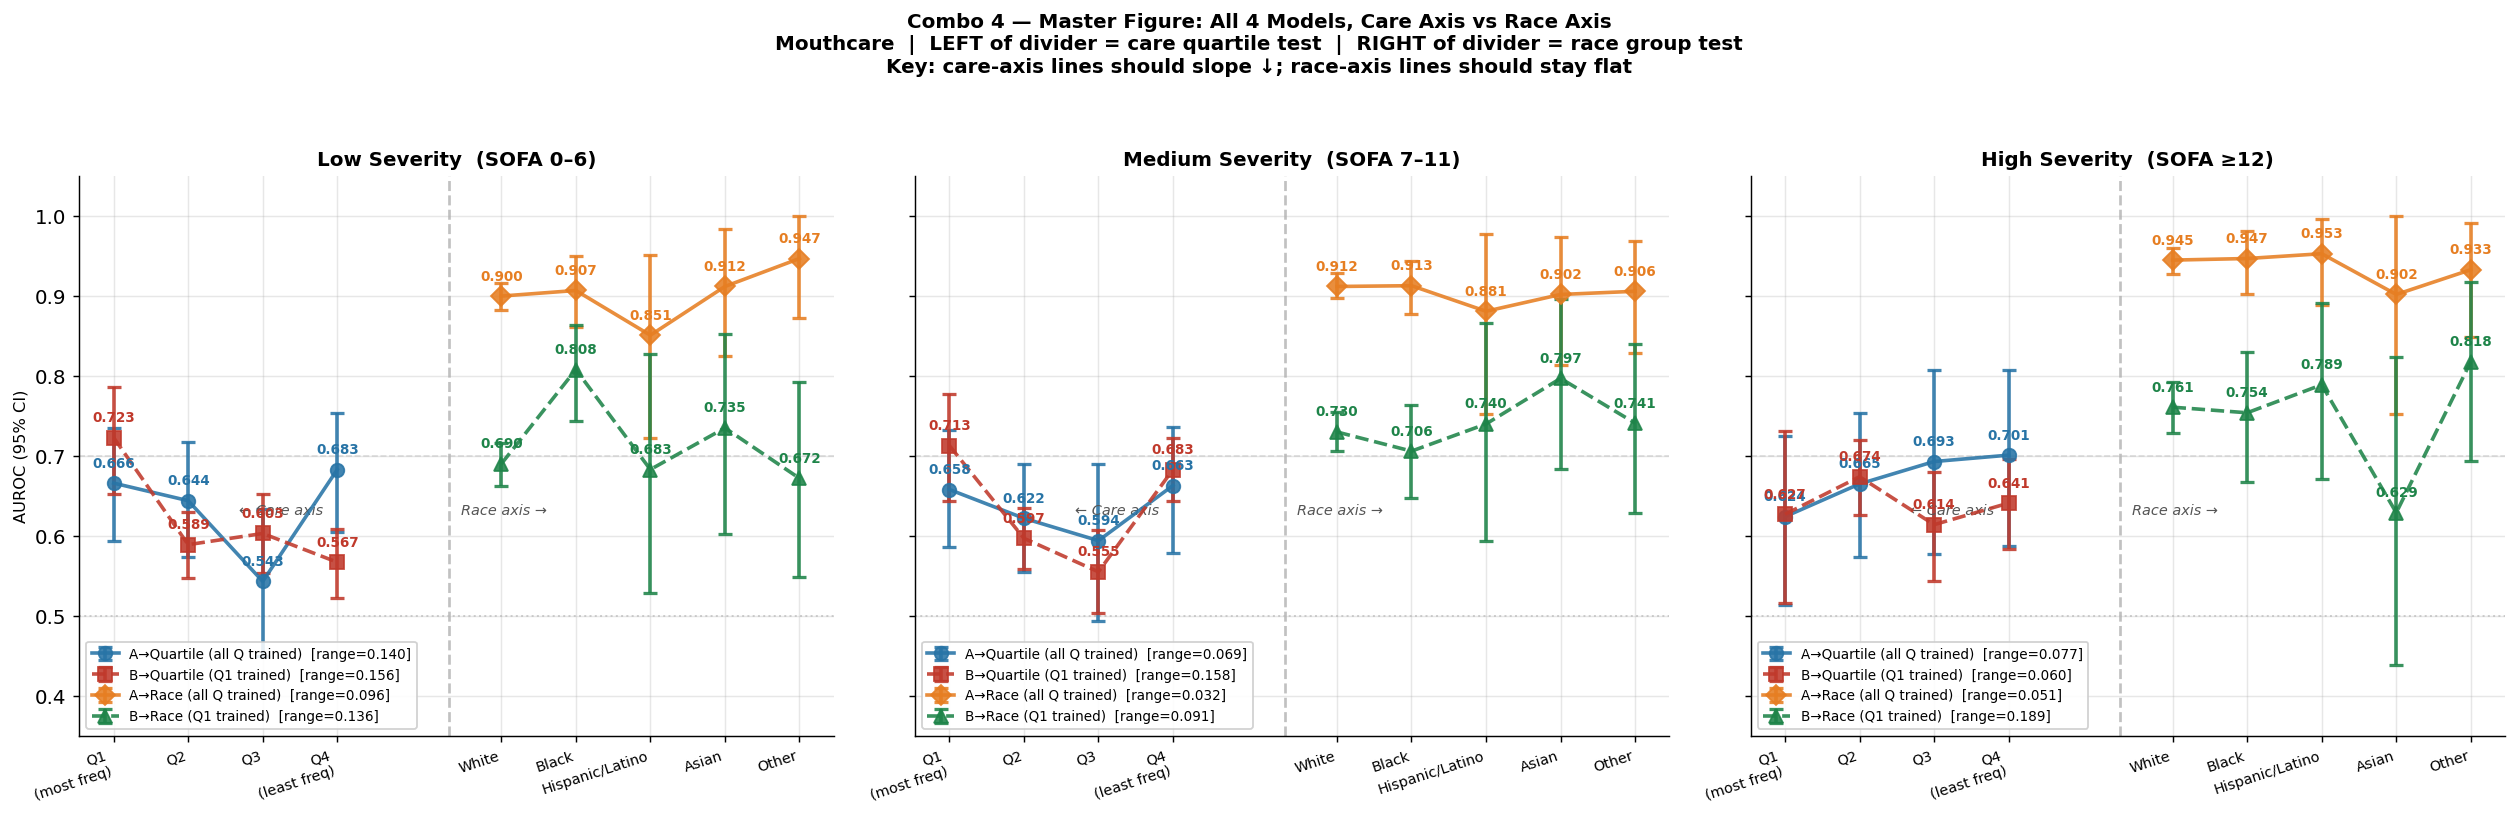

Saved: figures\combo4_master_mouthcare.png


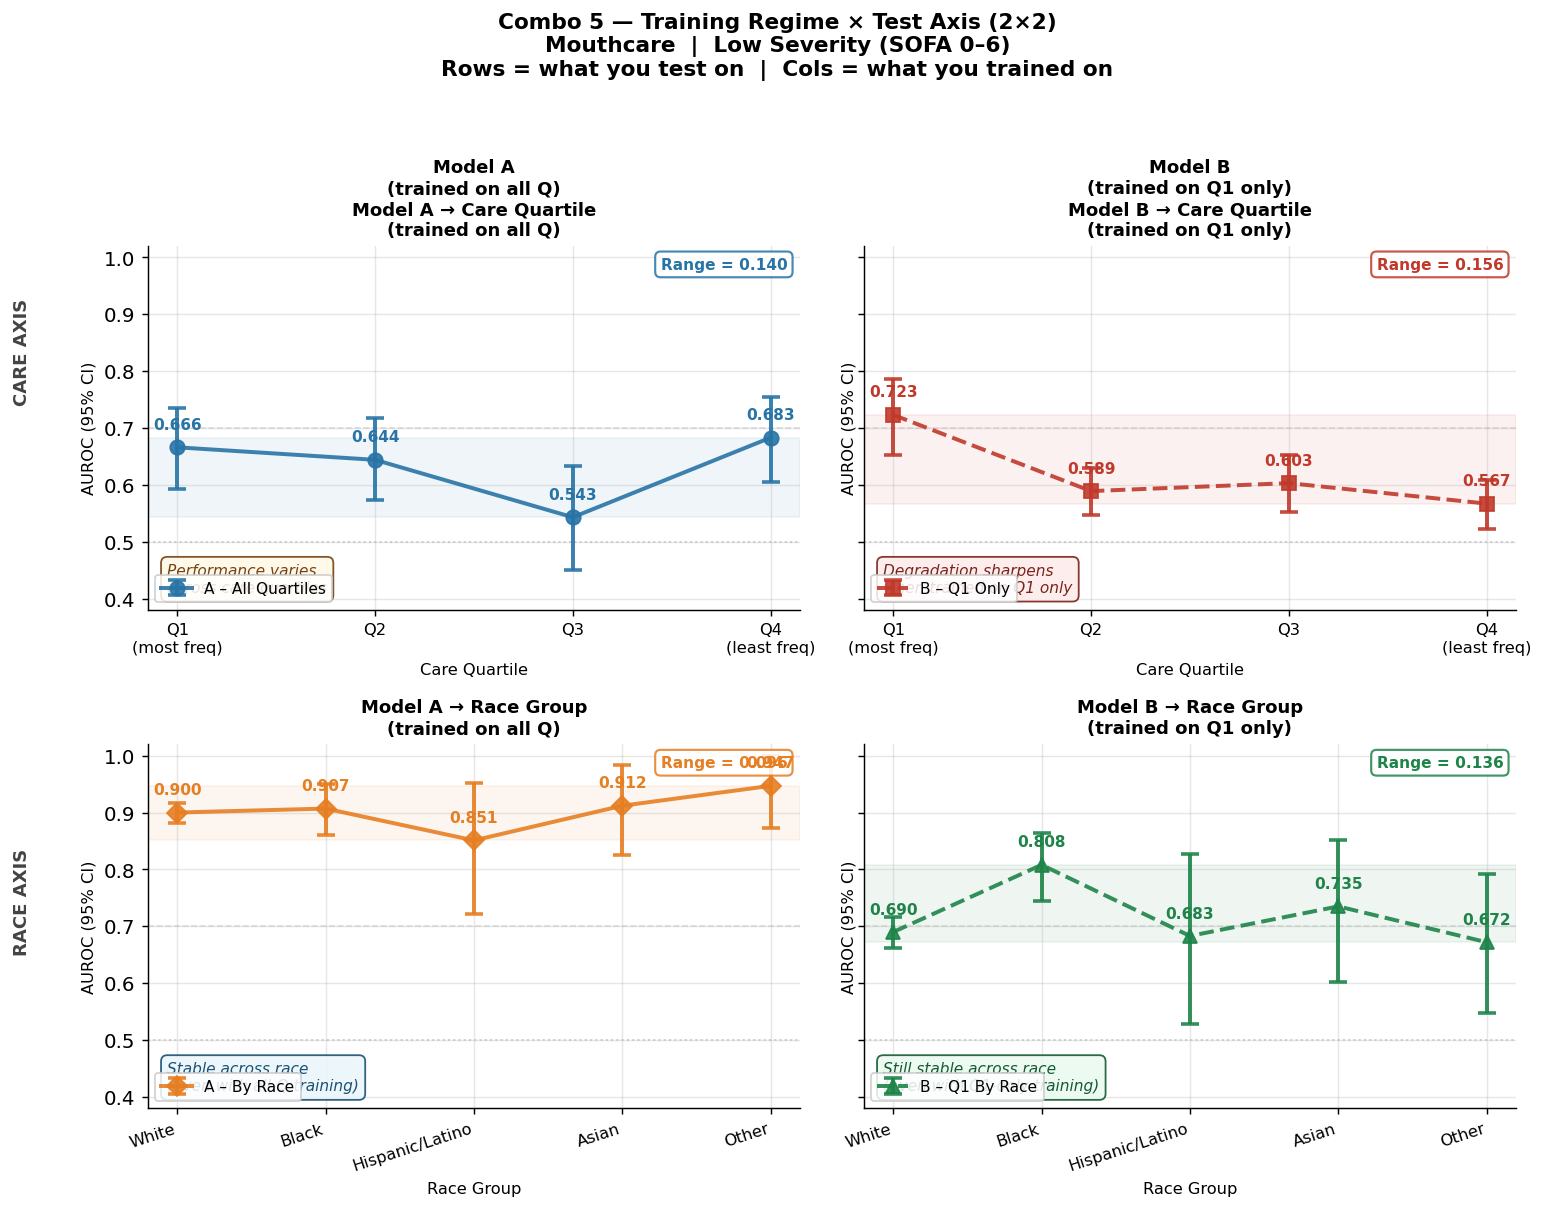

Saved: figures\combo5_crossover_mouthcare_low.png


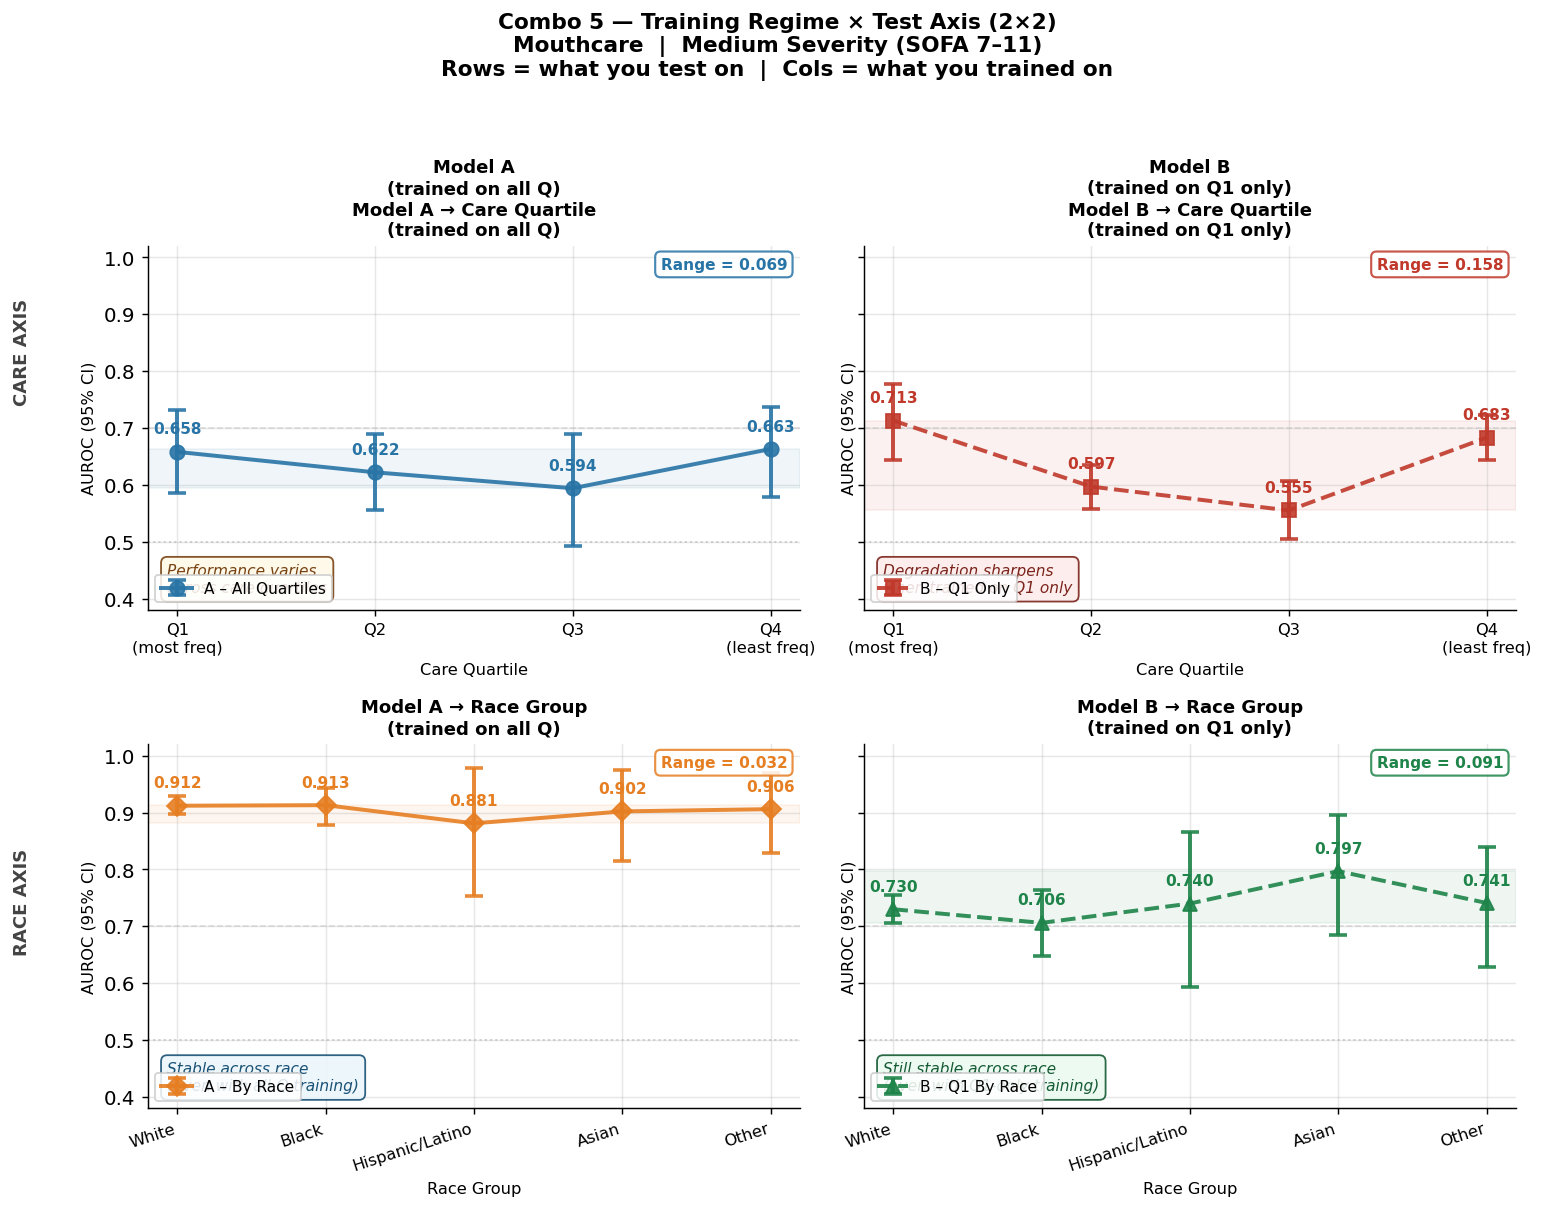

Saved: figures\combo5_crossover_mouthcare_medium.png


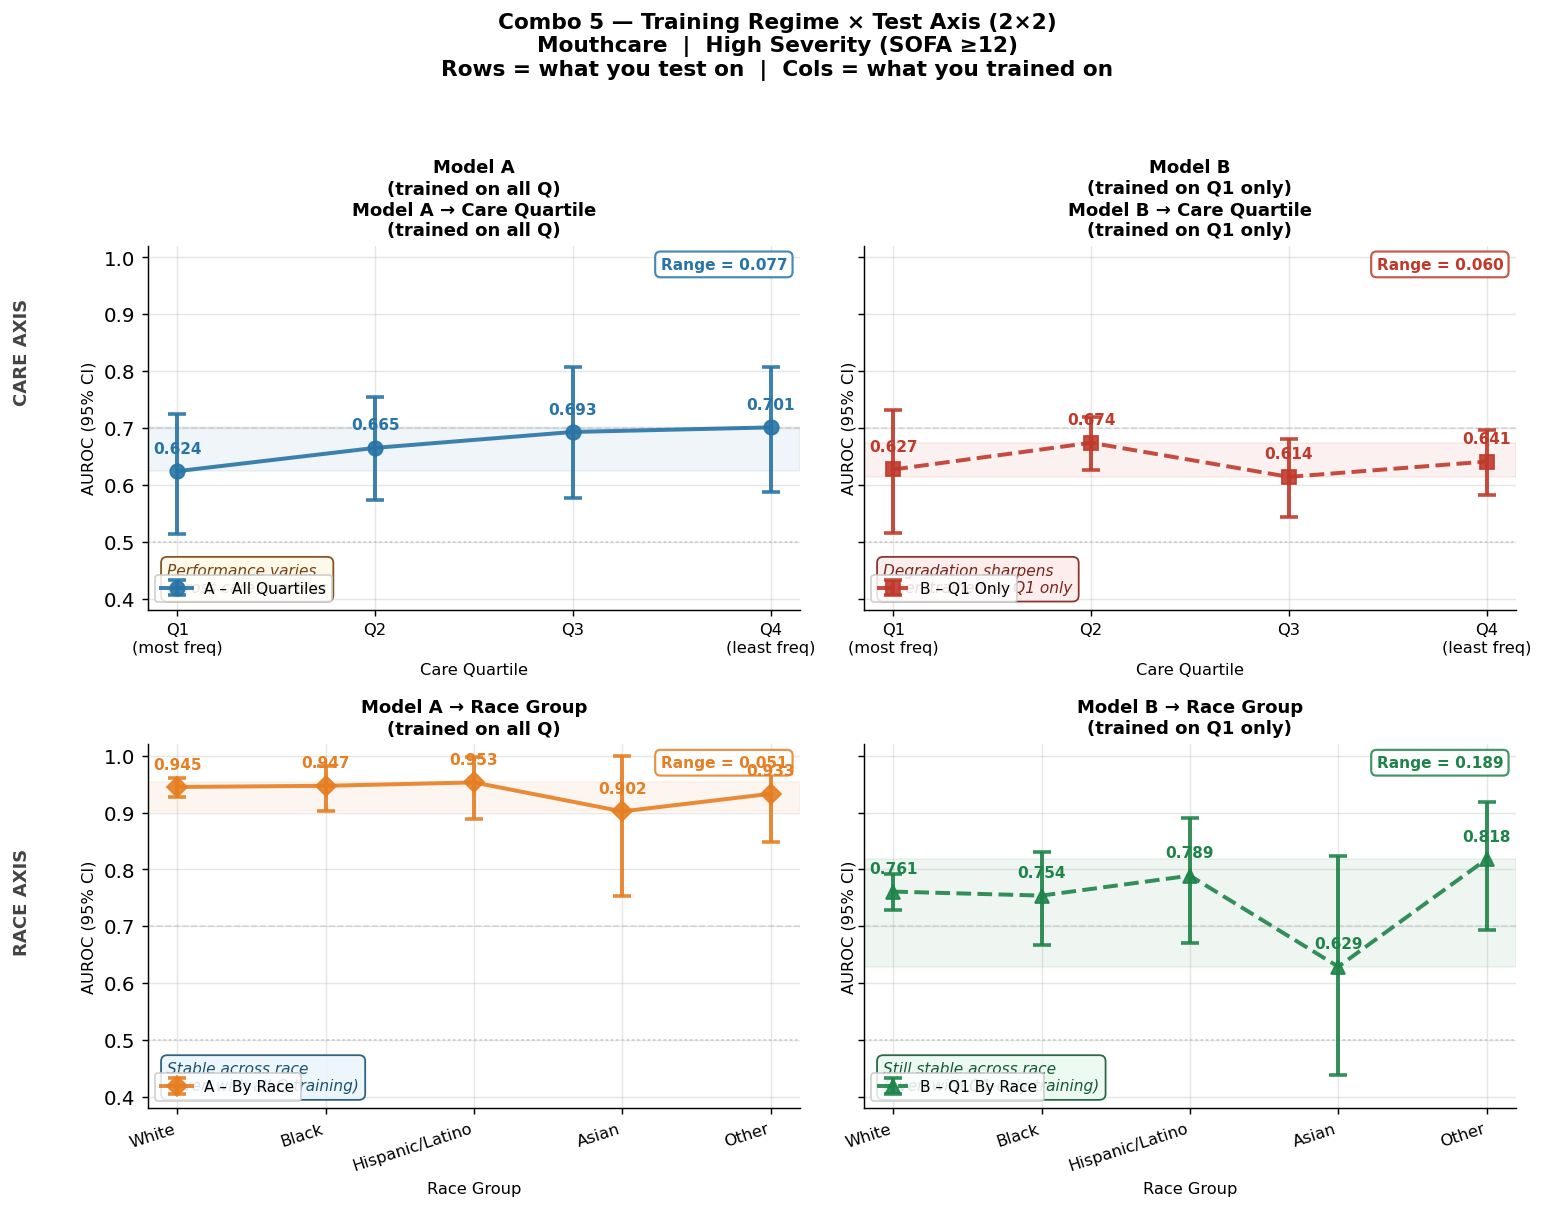

Saved: figures\combo5_crossover_mouthcare_high.png


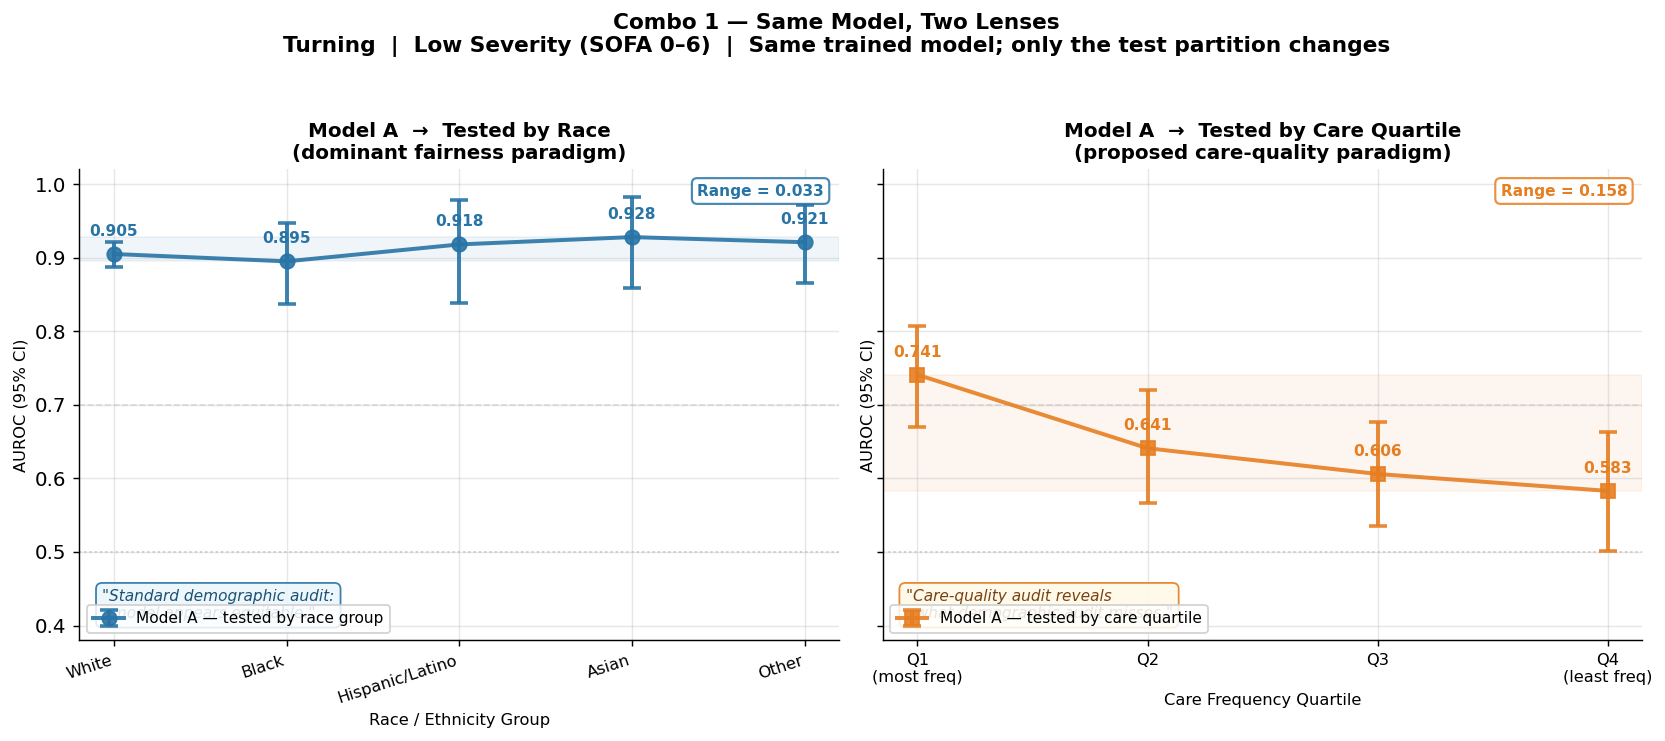

Saved: figures\combo1_samelens_turning_low.png


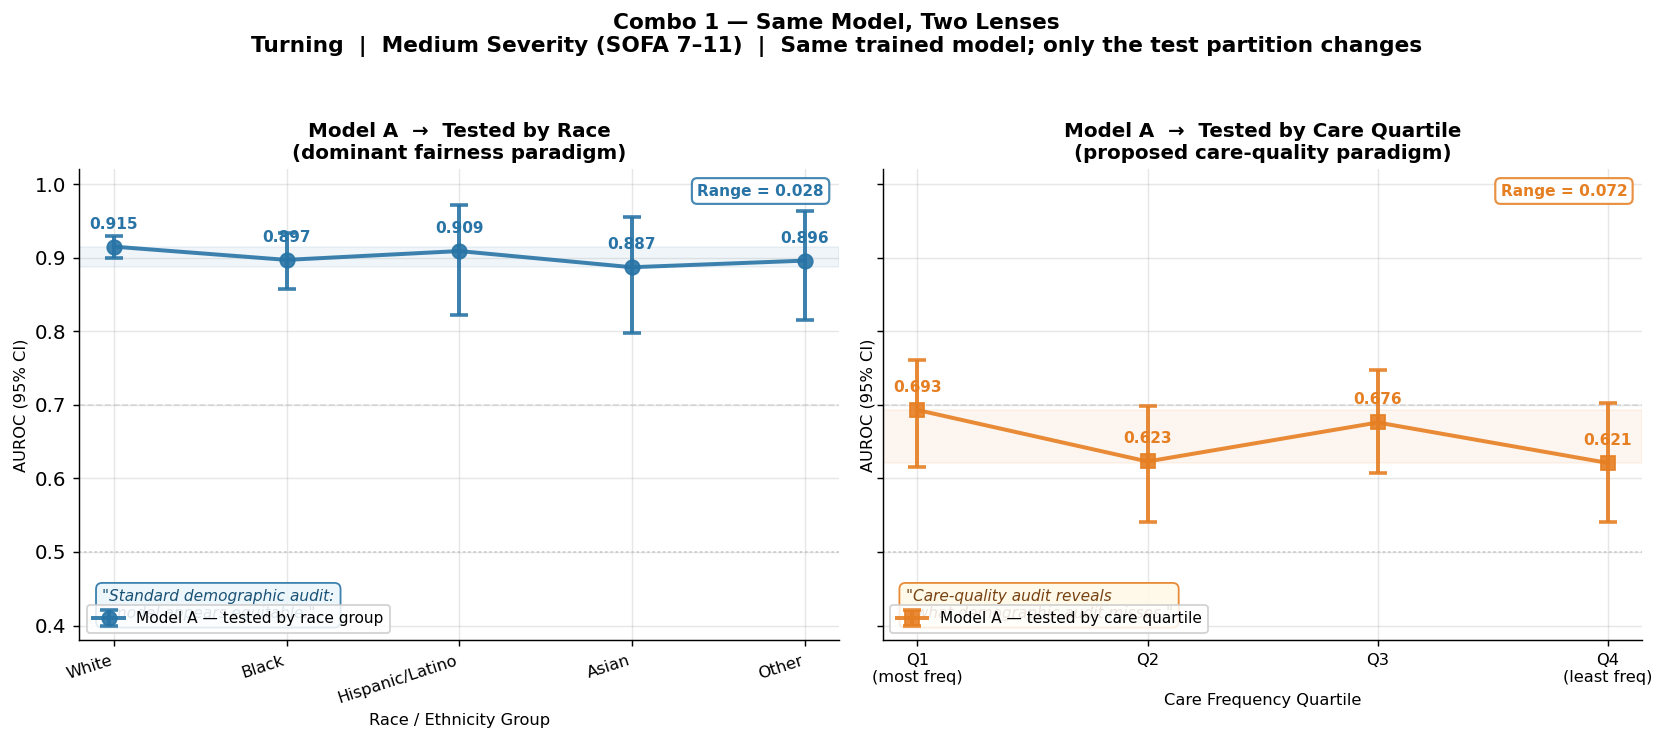

Saved: figures\combo1_samelens_turning_medium.png


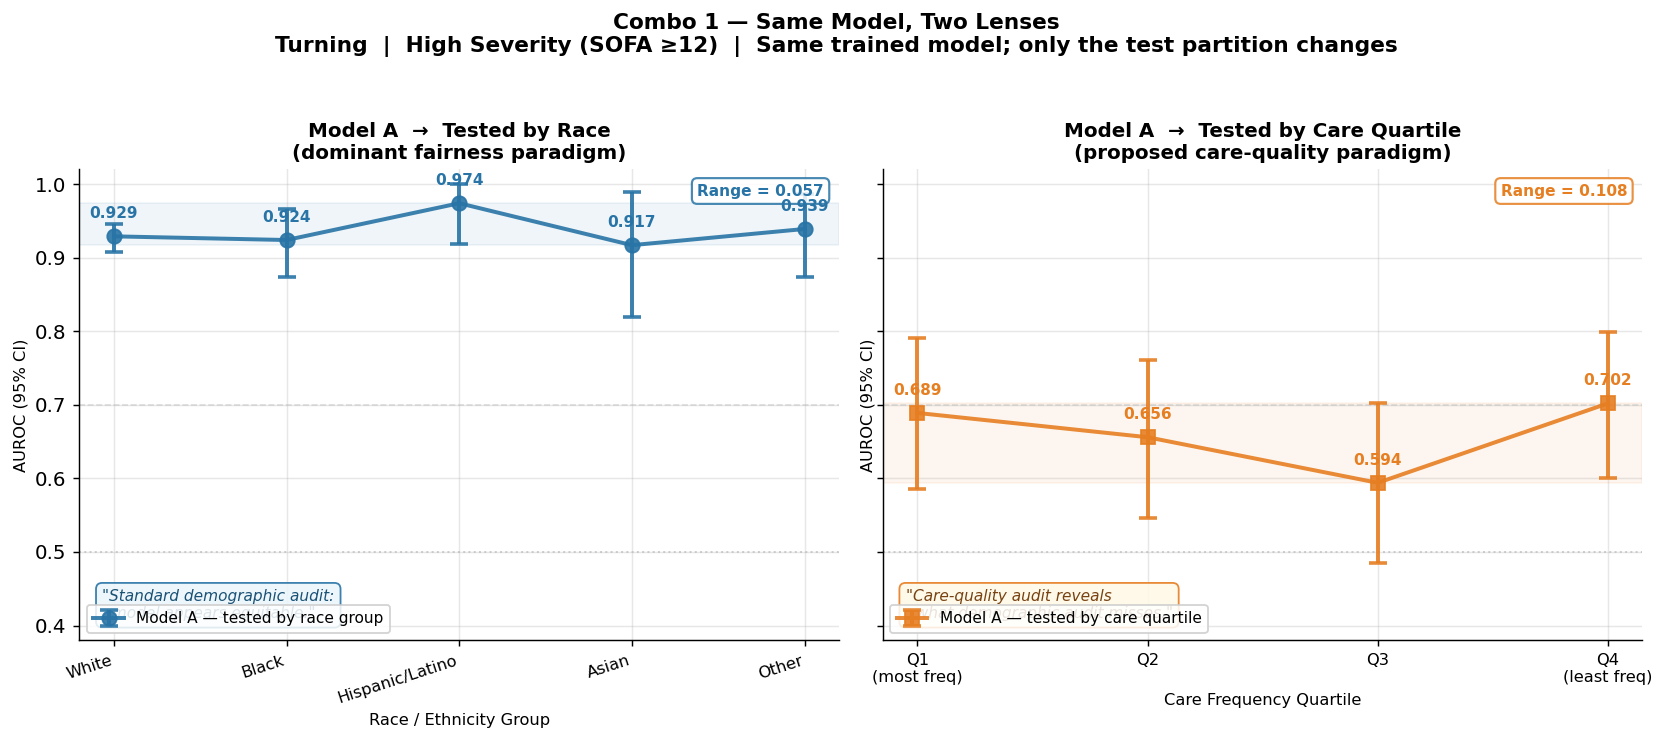

Saved: figures\combo1_samelens_turning_high.png


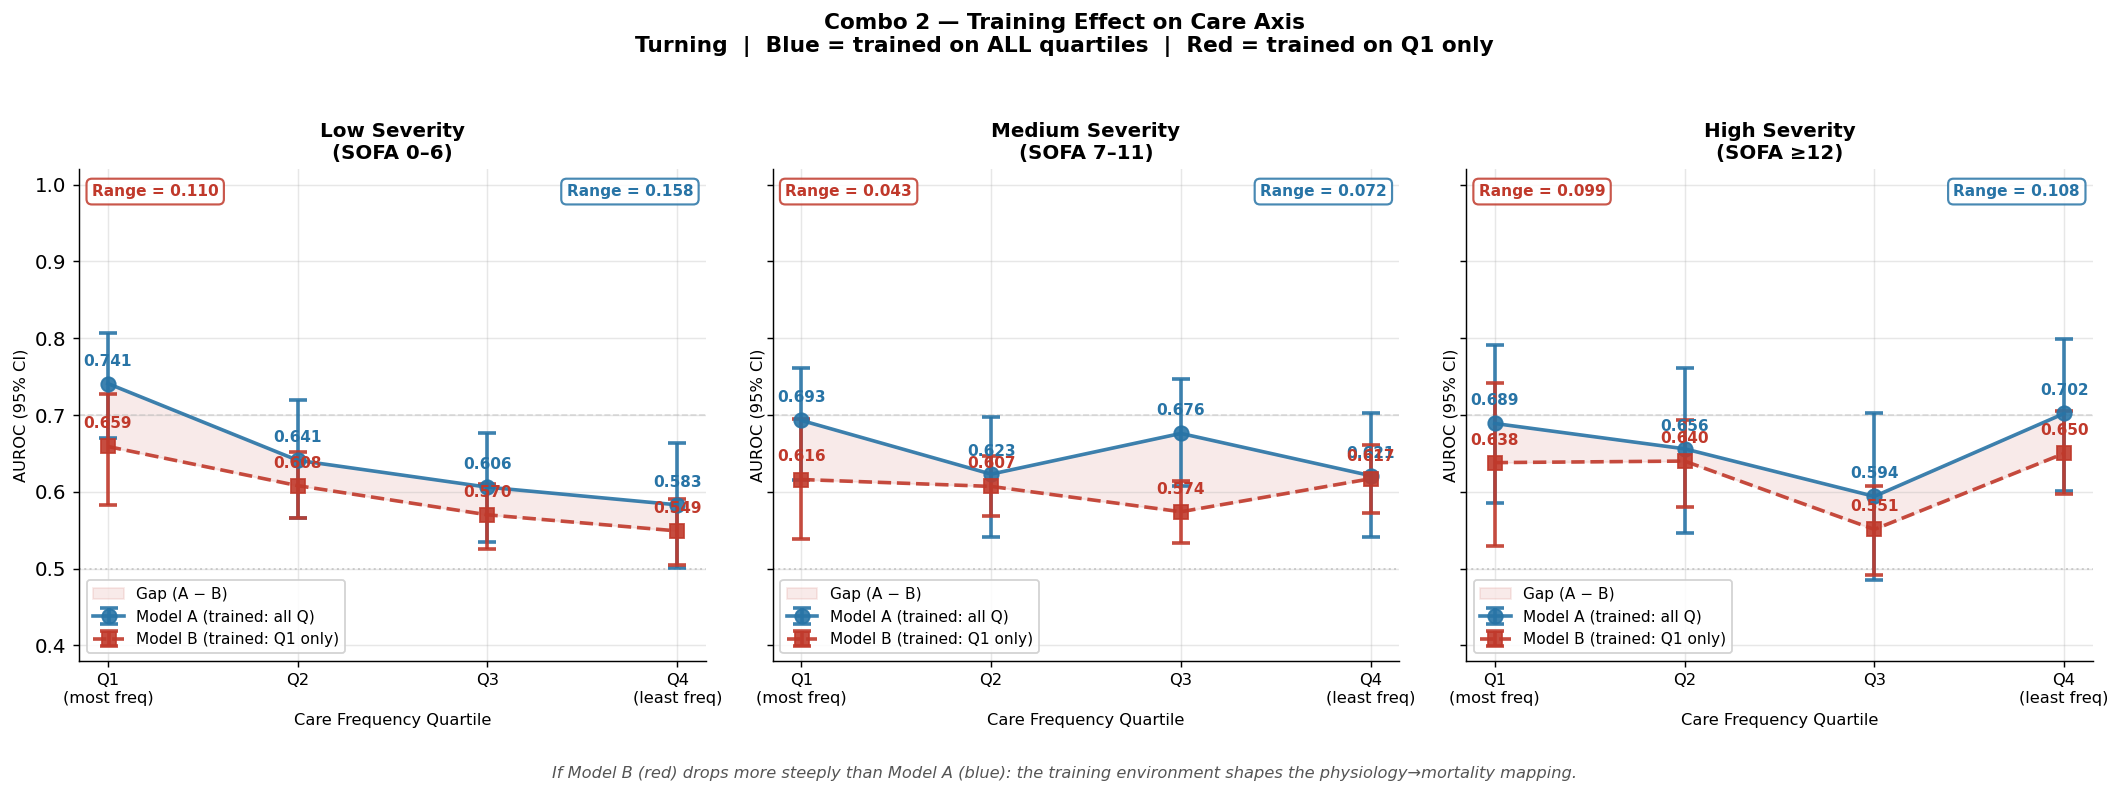

Saved: figures\combo2_training_effect_turning.png


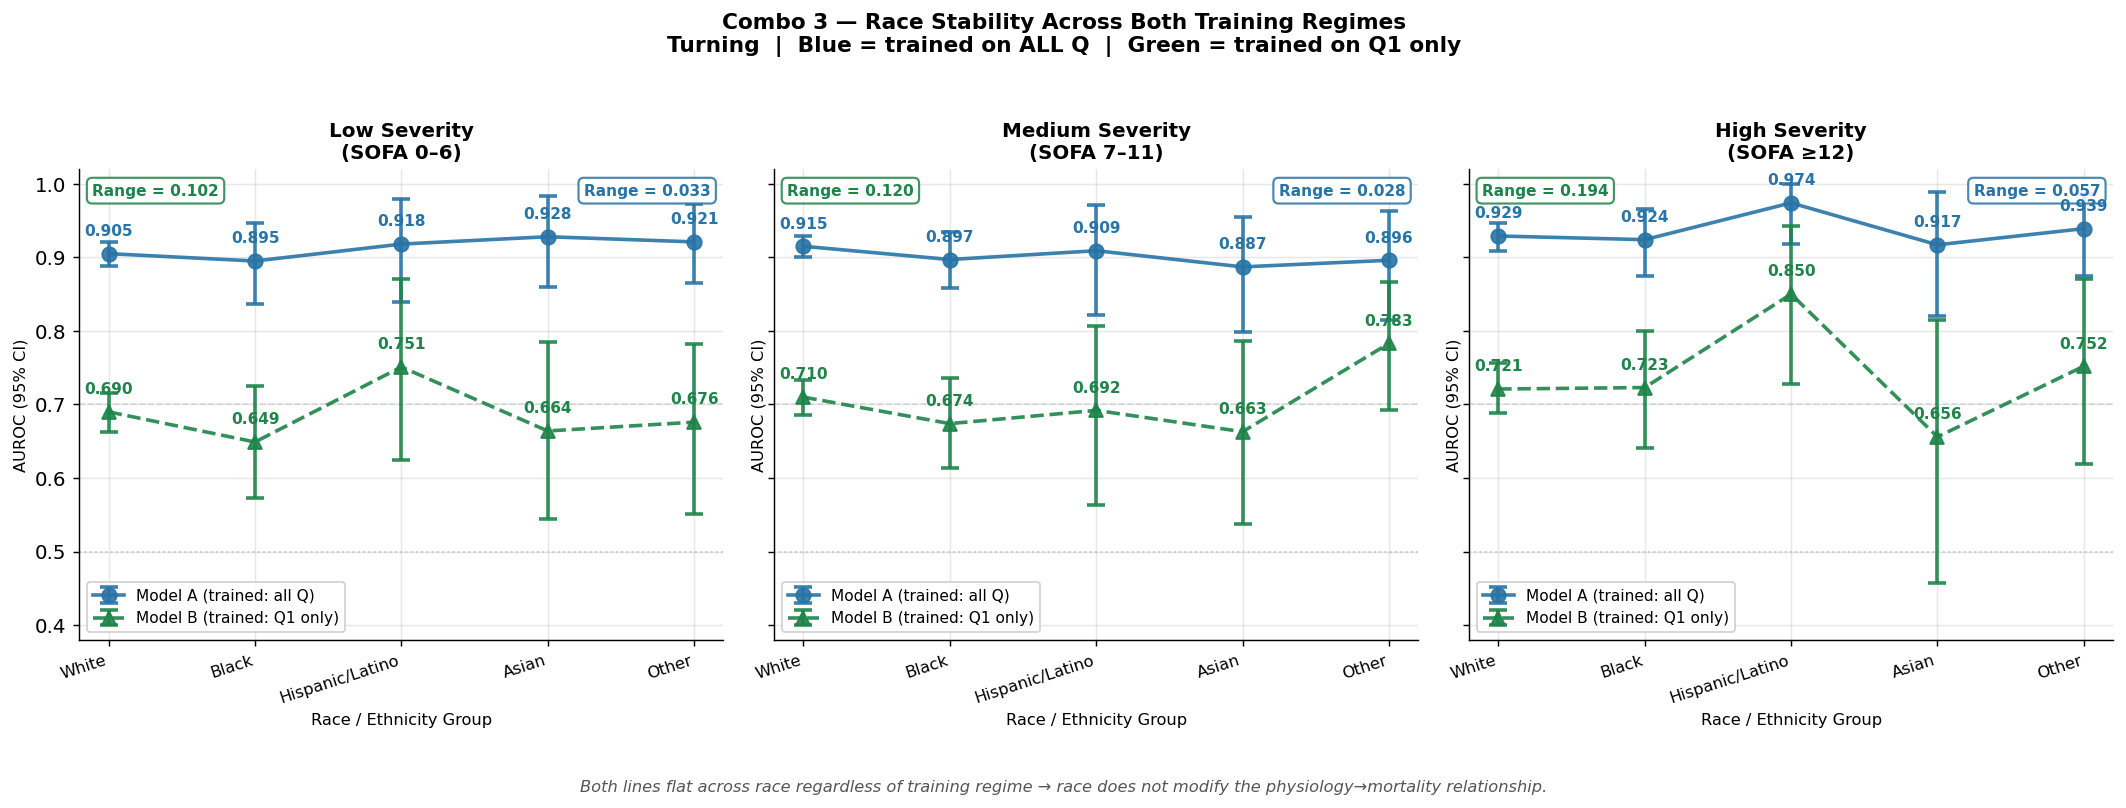

Saved: figures\combo3_race_stability_turning.png


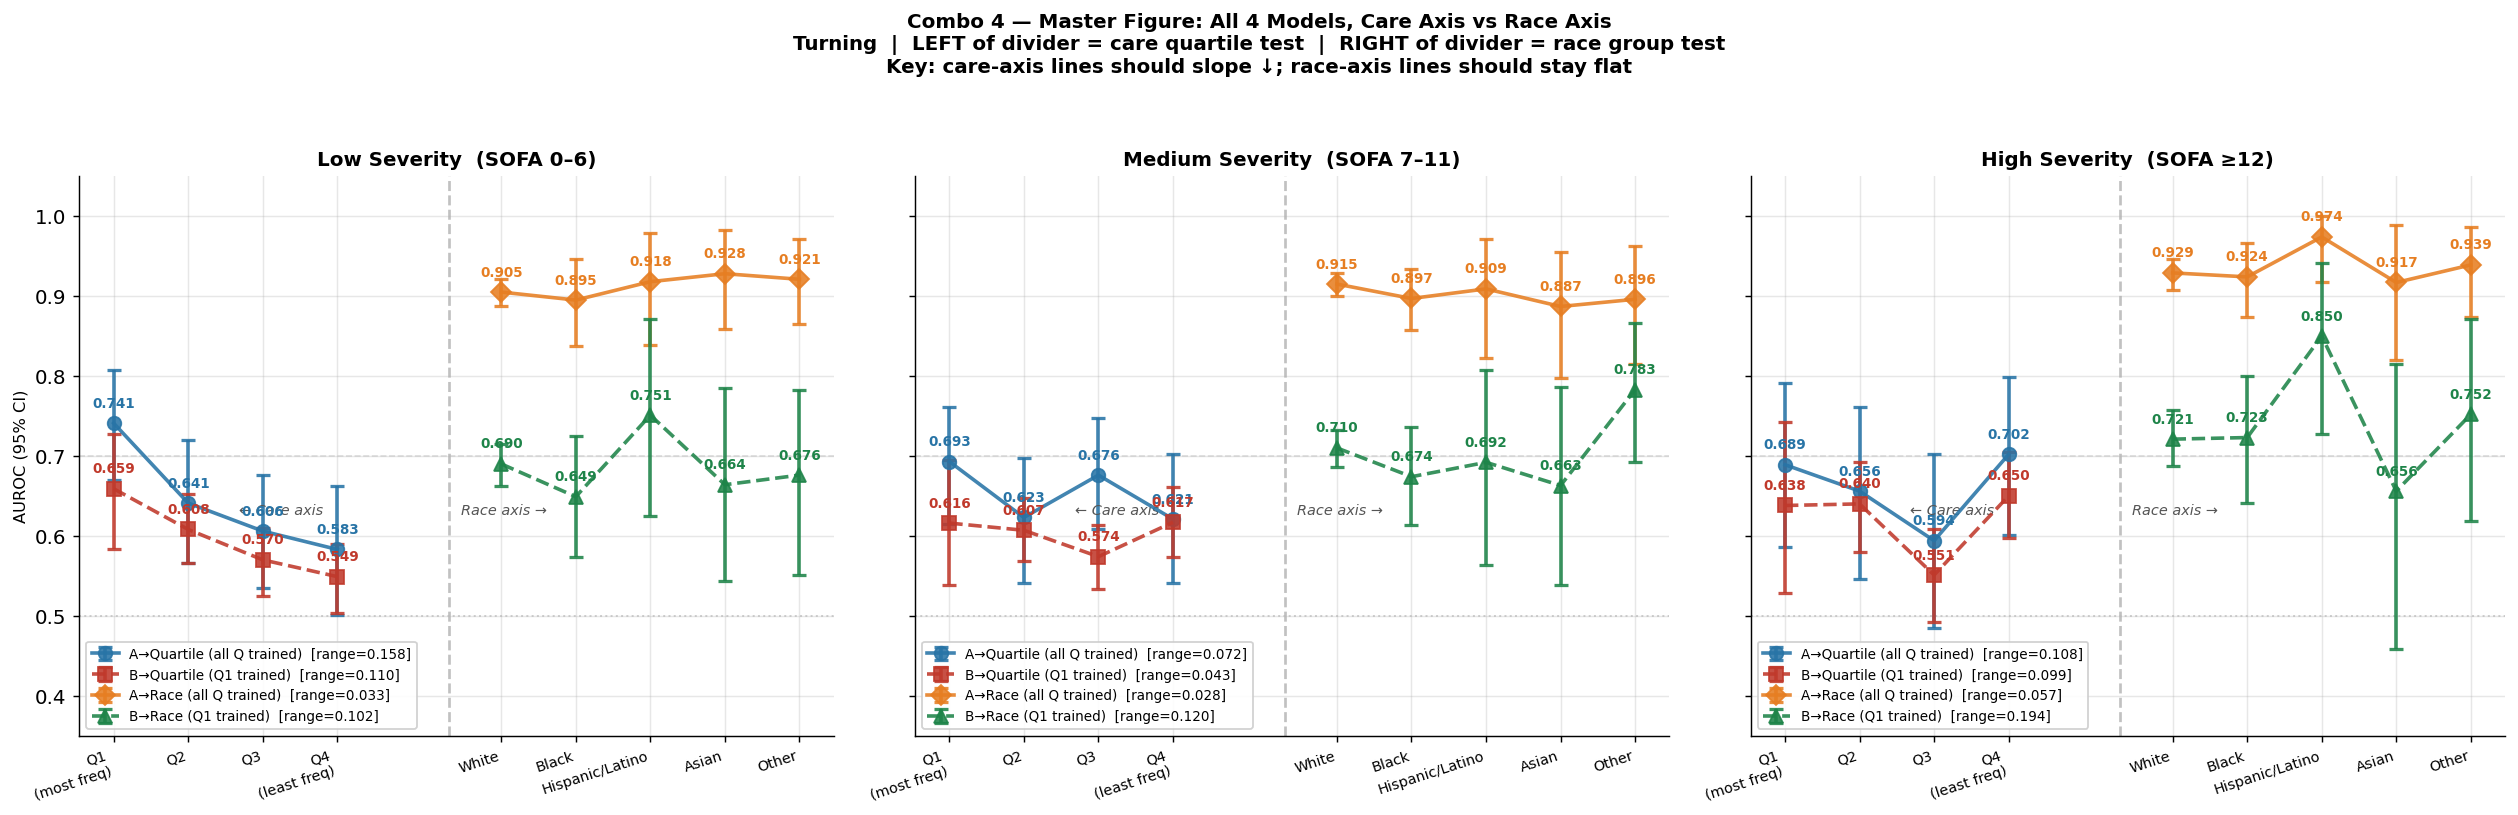

Saved: figures\combo4_master_turning.png


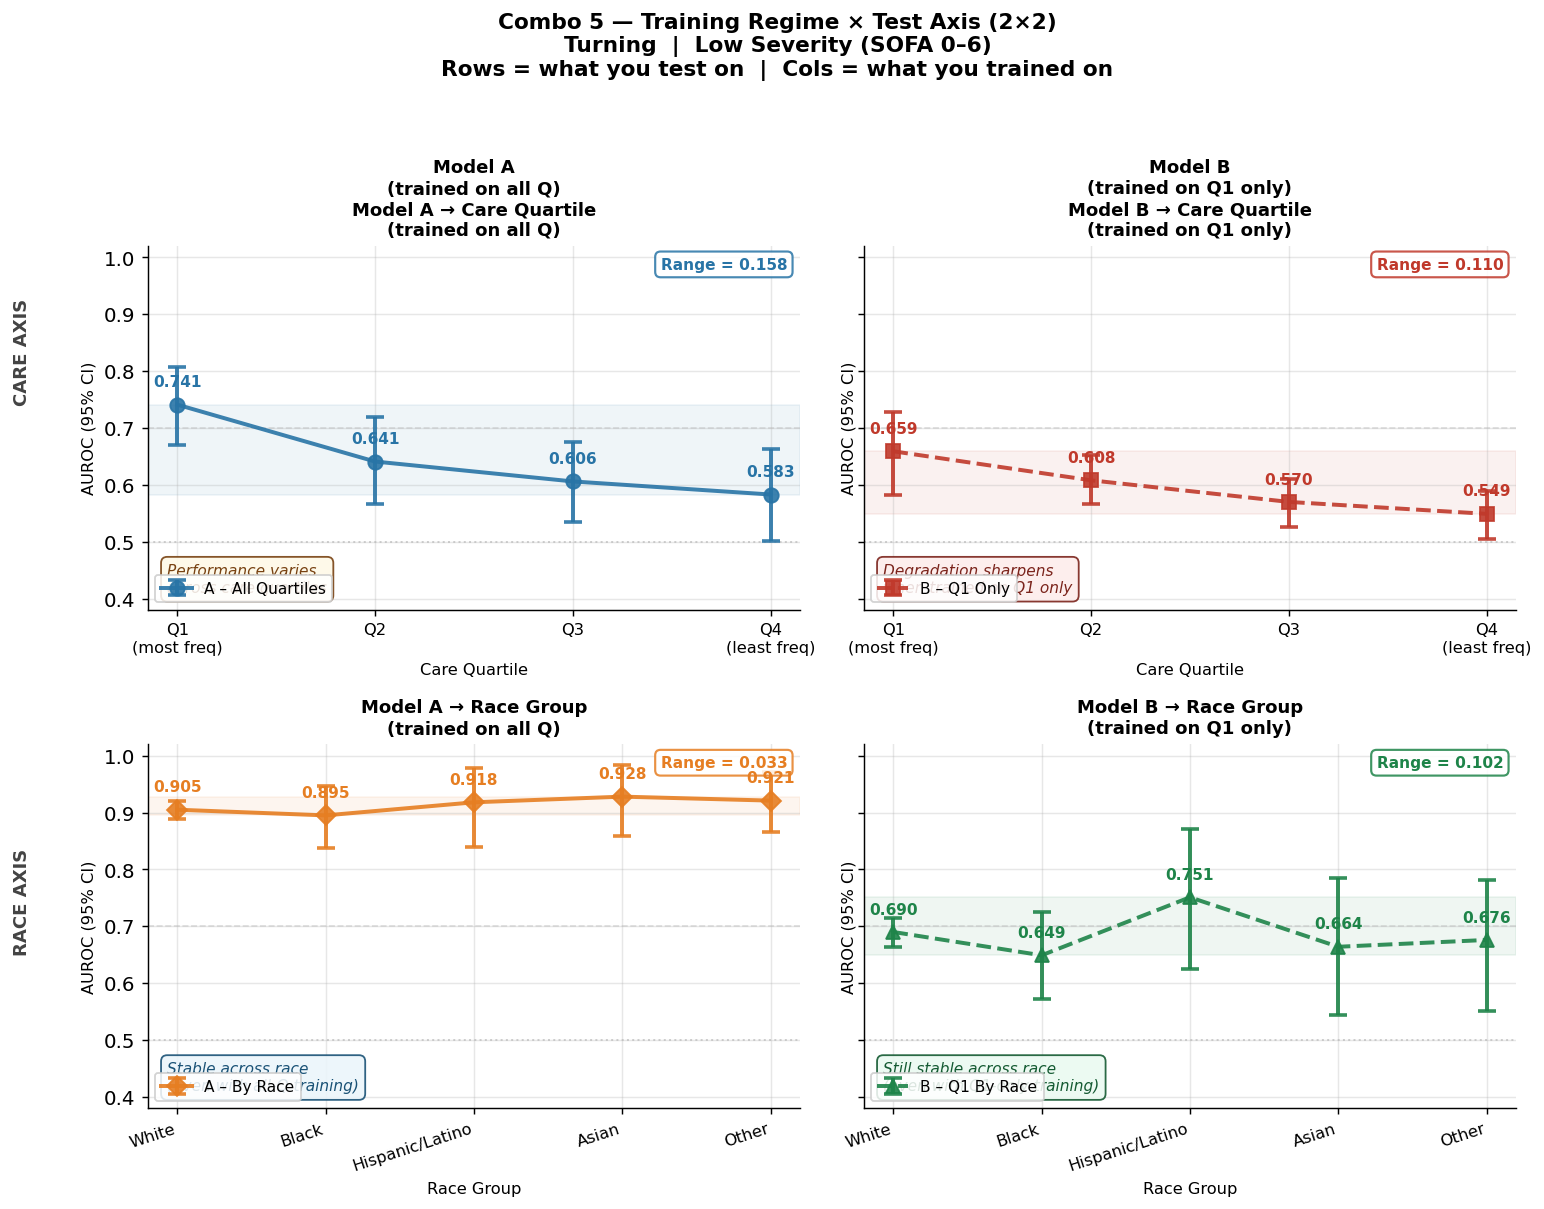

Saved: figures\combo5_crossover_turning_low.png


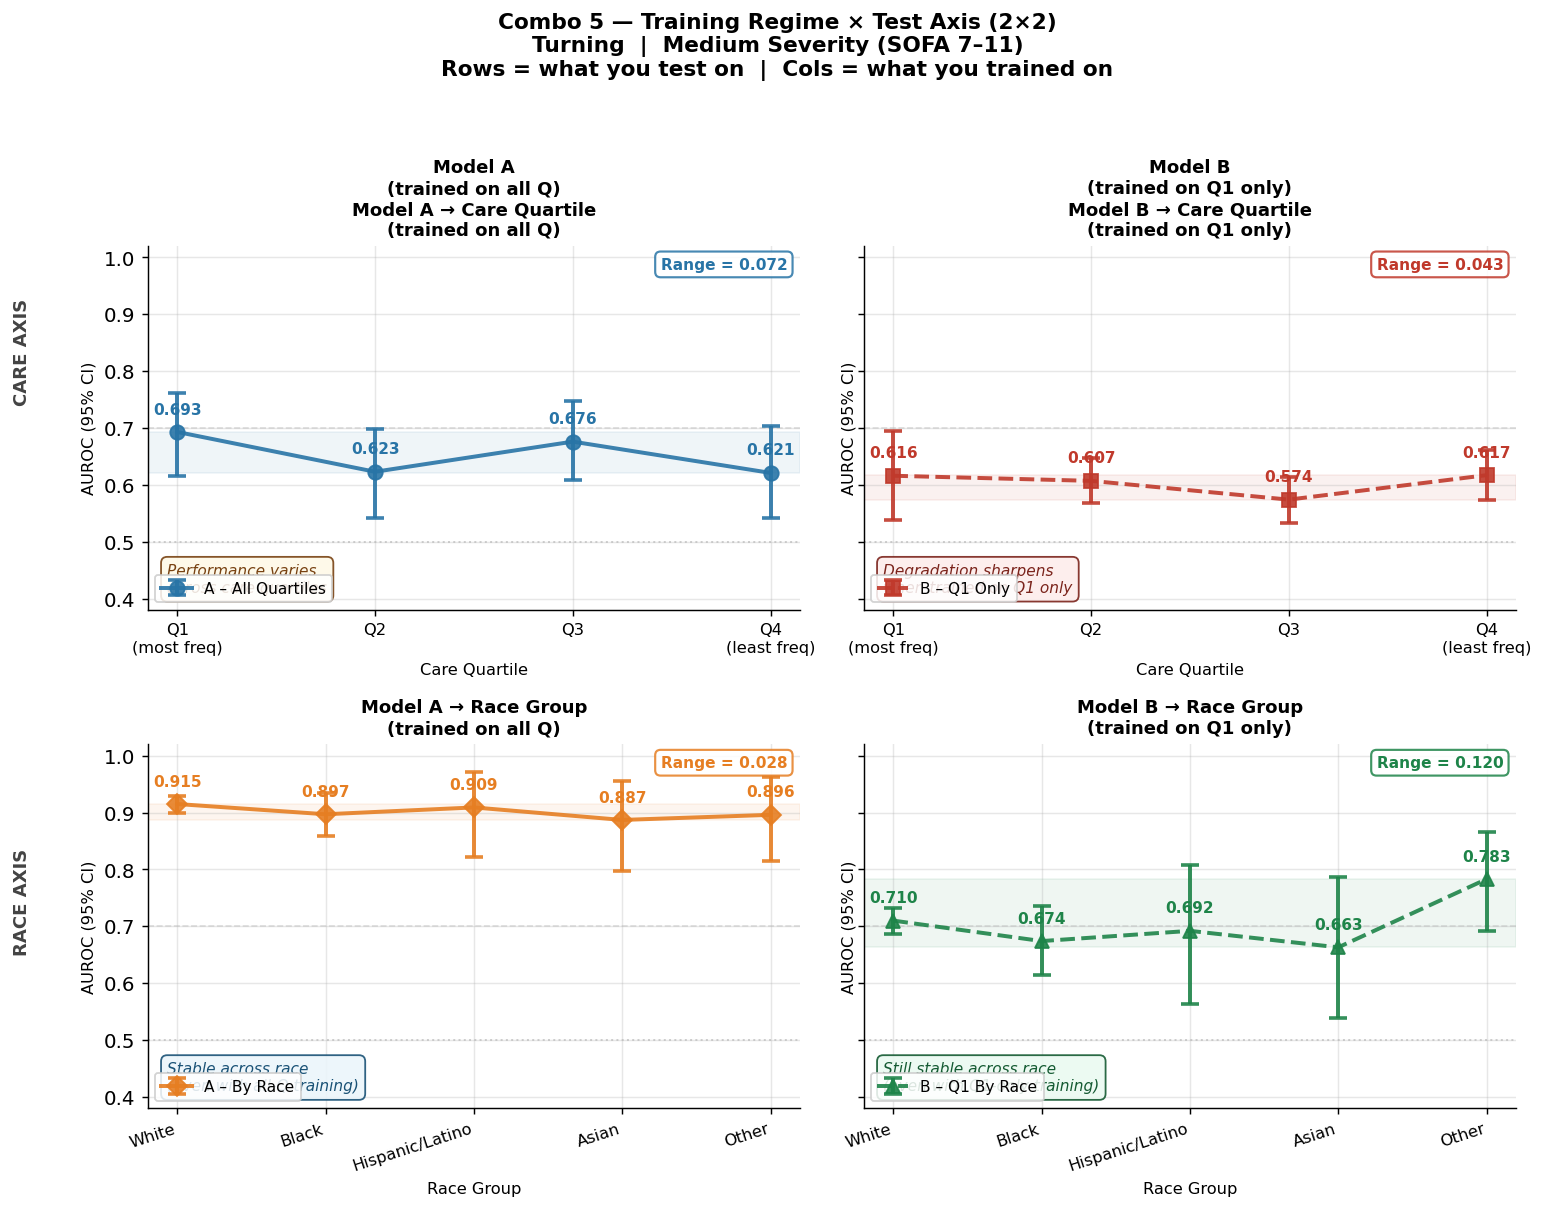

Saved: figures\combo5_crossover_turning_medium.png


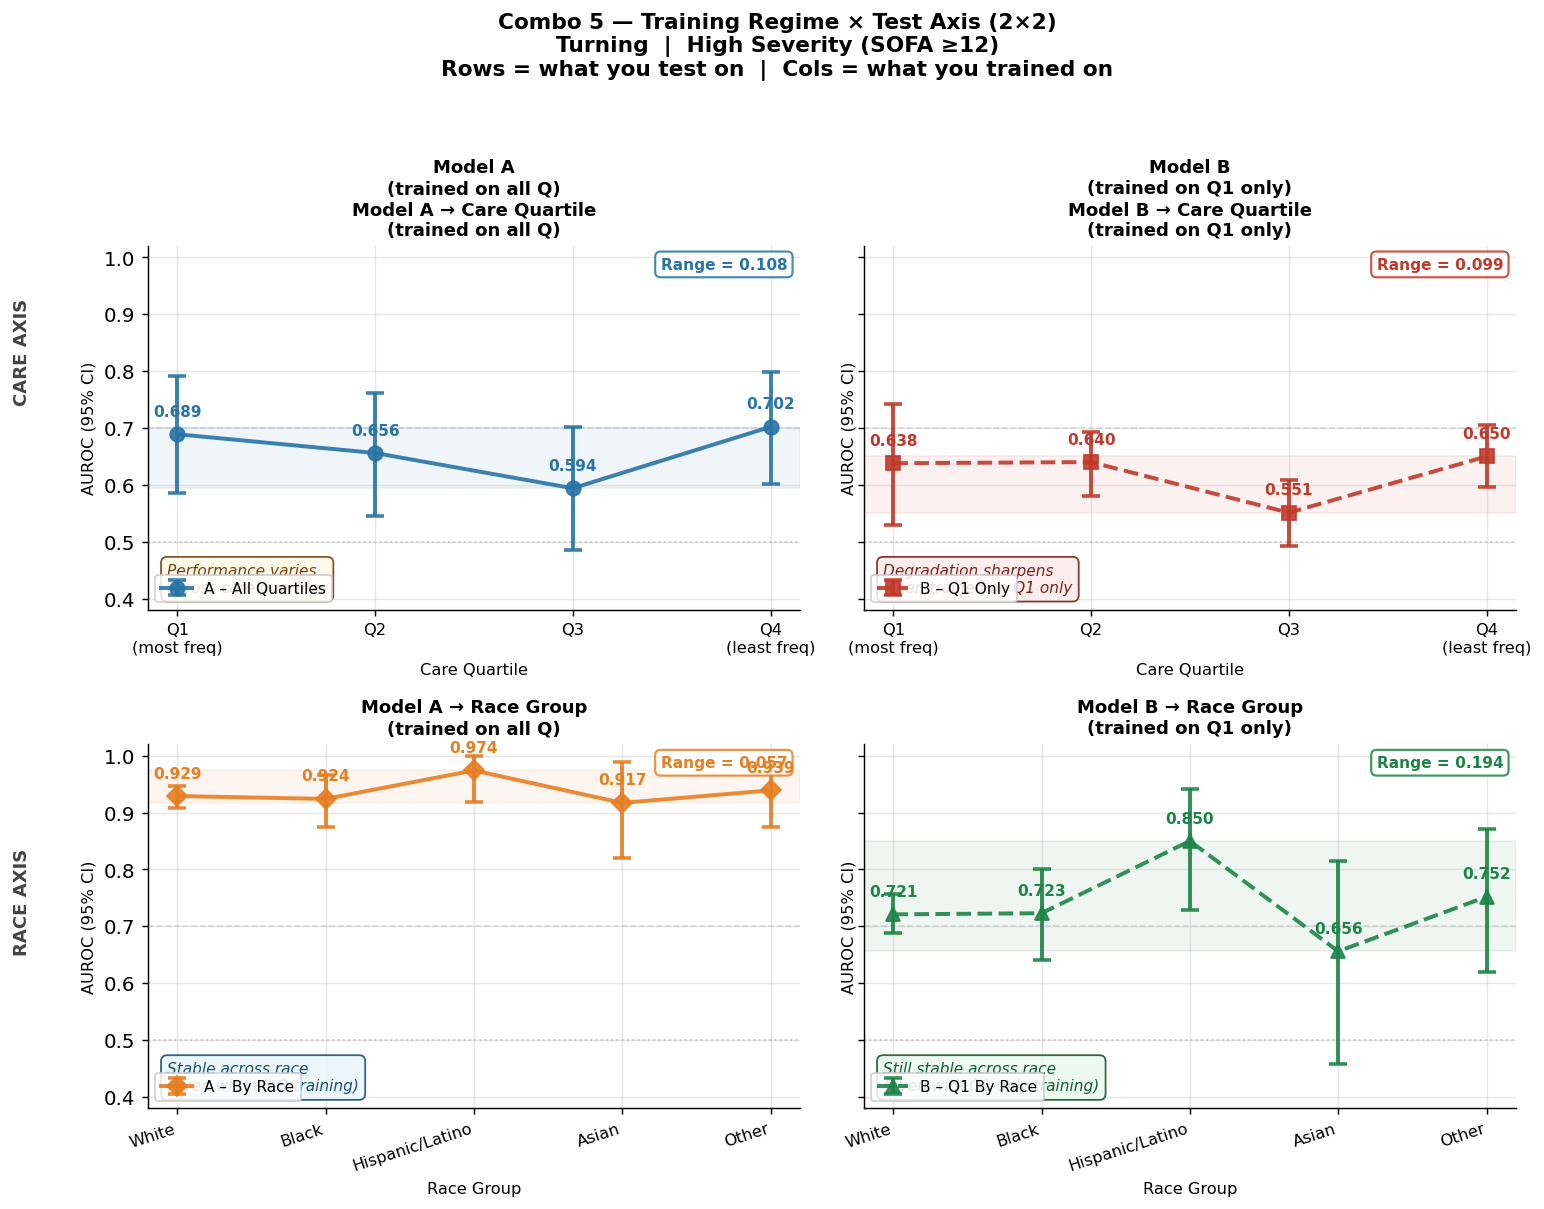

Saved: figures\combo5_crossover_turning_high.png

All combination figures saved.


In [19]:
# ═══════════════════════════════════════════════════════════════════════════════
# COMBINED COMPARISON GRAPHS
# Add this as a new cell directly after cell 26.
# Produces 4 combination figures per care type × severity group.
# No changes to existing code — reads only from results_df.
# ═══════════════════════════════════════════════════════════════════════════════

# ── Shared helpers ────────────────────────────────────────────────────────────

def _get_q(results_df, care, sev, model_name):
    """Extract quartile-tested rows, sorted Q1→Q4."""
    mdf = results_df[
        (results_df['Care Type'] == care) &
        (results_df['Severity']  == sev) &
        (results_df['Model']     == model_name)
    ].copy()
    mdf['label'] = mdf['Test Set'].str.extract(r'(Q\d)')
    return mdf.dropna(subset=['label','AUROC']).sort_values('label').reset_index(drop=True)

def _get_r(results_df, care, sev, model_name):
    """Extract race-tested rows, sorted by RACE_LABELS order."""
    mdf = results_df[
        (results_df['Care Type'] == care) &
        (results_df['Severity']  == sev) &
        (results_df['Model']     == model_name)
    ].copy()
    mdf['label'] = mdf['Test Set'].str.replace('Race: ', '', regex=False)
    mdf['_ord']  = mdf['label'].map({r: i for i, r in enumerate(RACE_LABELS)})
    return mdf.dropna(subset=['label','AUROC','_ord']).sort_values('_ord').reset_index(drop=True)

def _plot_line(ax, mdf, color, marker, ls, label, annotate=True, lw=2.2):
    """Plot one model's line with CI bars and value labels."""
    if len(mdf) == 0:
        return
    x    = np.arange(len(mdf))
    auc  = mdf['AUROC'].values.astype(float)
    lo   = mdf['AUROC_lo'].fillna(mdf['AUROC']).values.astype(float)
    hi   = mdf['AUROC_hi'].fillna(mdf['AUROC']).values.astype(float)
    yerr = np.array([np.clip(auc - lo, 0, 1), np.clip(hi - auc, 0, 1)])
    ax.errorbar(x, auc, yerr=yerr, color=color, marker=marker,
                linestyle=ls, linewidth=lw, markersize=8,
                capsize=5, capthick=2, ecolor=color, alpha=0.9,
                label=label, zorder=3)
    if annotate:
        for xi, ai in enumerate(auc):
            ax.annotate(f'{ai:.3f}', (xi, ai),
                        textcoords='offset points', xytext=(0, 10),
                        ha='center', fontsize=8.5,
                        color=color, fontweight='bold', zorder=4)
    return auc

def _range_badge(ax, auc, color, pos='upper right'):
    """Small range badge in corner."""
    if auc is None or len(auc) == 0:
        return
    r = auc.max() - auc.min()
    x_pos = 0.98 if 'right' in pos else 0.02
    ha     = 'right' if 'right' in pos else 'left'
    ax.text(x_pos, 0.97, f'Range = {r:.3f}',
            transform=ax.transAxes, ha=ha, va='top',
            fontsize=8.5, color=color, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.35', facecolor='white',
                      edgecolor=color, alpha=0.85, linewidth=1.2))

def _style_ax(ax, xticks, xlabels, xlabel, ylabel='AUROC (95% CI)',
              xrot=0, ylim=(0.38, 1.02)):
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=9,
                       rotation=xrot, ha='right' if xrot > 0 else 'center')
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.set_ylim(ylim)
    ax.axhline(0.5, color='#BBBBBB', ls=':', lw=1.1, alpha=0.7)
    ax.axhline(0.7, color='#BBBBBB', ls='--', lw=0.9, alpha=0.5)
    ax.legend(fontsize=8.5, loc='lower left', framealpha=0.85)

Q_XLABELS = ['Q1\n(most freq)', 'Q2', 'Q3', 'Q4\n(least freq)']
SOFA_STR  = {'Low':'0–6', 'Medium':'7–11', 'High':'≥12'}


# ════════════════════════════════════════════════════════════════════════════════
# COMBO 1 — "Same Model, Two Lenses"
# Left panels : Model A → Race    (standard audit — should look flat)
# Right panels: Model A → Quartile (care audit  — should show variation)
# Message: The SAME model looks fair under one lens and unfair under the other.
# One figure per care × severity.
# ════════════════════════════════════════════════════════════════════════════════

def plot_combo1_same_model_two_lenses(results_df, care, sev, save_path):
    fig, axes = plt.subplots(1, 2, figsize=(13, 5.5), sharey=True)

    # Left: Model A → Race
    ax = axes[0]
    rdf  = _get_r(results_df, care, sev, 'A – By Race')
    auc_r = _plot_line(ax, rdf, '#2874A6', 'o', '-',
                       'Model A — tested by race group')
    if auc_r is not None:
        ax.axhspan(auc_r.min(), auc_r.max(), color='#2874A6', alpha=0.07)
        _range_badge(ax, auc_r, '#2874A6', 'upper right')
    ax.text(0.03, 0.04,
            '"Standard demographic audit:\n  model appears equitable."',
            transform=ax.transAxes, ha='left', va='bottom',
            fontsize=8.5, style='italic', color='#1A5276',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#EBF5FB',
                      edgecolor='#2874A6', alpha=0.9))
    _style_ax(ax,
              xticks=np.arange(len(rdf)),
              xlabels=rdf['label'].tolist() if len(rdf) > 0 else [],
              xlabel='Race / Ethnicity Group', xrot=18)
    ax.set_title('Model A  →  Tested by Race\n(dominant fairness paradigm)',
                 fontweight='bold', fontsize=11)

    # Right: Model A → Quartile
    ax = axes[1]
    qdf  = _get_q(results_df, care, sev, 'A – All Quartiles')
    auc_q = _plot_line(ax, qdf, '#E67E22', 's', '-',
                       'Model A — tested by care quartile')
    if auc_q is not None:
        ax.axhspan(auc_q.min(), auc_q.max(), color='#E67E22', alpha=0.07)
        _range_badge(ax, auc_q, '#E67E22', 'upper right')
    ax.text(0.03, 0.04,
            '"Care-quality audit reveals\n  what demographic audit misses."',
            transform=ax.transAxes, ha='left', va='bottom',
            fontsize=8.5, style='italic', color='#784212',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#FEF9E7',
                      edgecolor='#E67E22', alpha=0.9))
    _style_ax(ax,
              xticks=np.arange(len(qdf)),
              xlabels=Q_XLABELS[:len(qdf)],
              xlabel='Care Frequency Quartile')
    ax.set_title('Model A  →  Tested by Care Quartile\n(proposed care-quality paradigm)',
                 fontweight='bold', fontsize=11)

    fig.suptitle(
        f'Combo 1 — Same Model, Two Lenses\n'
        f'{care}  |  {sev} Severity (SOFA {SOFA_STR[sev]})  |  '
        f'Same trained model; only the test partition changes',
        fontsize=12, fontweight='bold', y=1.03
    )
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'Saved: {save_path}')


# ════════════════════════════════════════════════════════════════════════════════
# COMBO 2 — "Training Effect on Care Axis"
# Both lines on ONE panel per severity: A→Q vs B→Q
# Message: Restricting training to Q1 sharpens the degradation signal.
# If B drops more steeply than A, the training environment shapes what the
# model learns about physiology–mortality relationships.
# One figure per care type (3 severity panels side by side).
# ════════════════════════════════════════════════════════════════════════════════

def plot_combo2_training_effect(results_df, care, save_path):
    sevs = SEVERITY_LABELS
    fig, axes = plt.subplots(1, len(sevs), figsize=(5.5 * len(sevs), 5.5), sharey=True)

    for ax, sev in zip(axes, sevs):
        qdf_A = _get_q(results_df, care, sev, 'A – All Quartiles')
        qdf_B = _get_q(results_df, care, sev, 'B – Q1 Only')

        auc_A = _plot_line(ax, qdf_A, '#2874A6', 'o', '-',
                           'Model A (trained: all Q)', lw=2)
        auc_B = _plot_line(ax, qdf_B, '#C0392B', 's', '--',
                           'Model B (trained: Q1 only)', lw=2)

        if auc_A is not None:
            _range_badge(ax, auc_A, '#2874A6', 'upper right')
        if auc_B is not None:
            _range_badge(ax, auc_B, '#C0392B', 'upper left')

        # Shade the gap between the two lines
        if auc_A is not None and auc_B is not None and len(auc_A) == len(auc_B):
            x = np.arange(len(auc_A))
            ax.fill_between(x, auc_A, auc_B,
                            where=(auc_B <= auc_A),
                            alpha=0.10, color='#C0392B',
                            label='Gap (A − B)')

        _style_ax(ax,
                  xticks=np.arange(len(QUARTILES)),
                  xlabels=Q_XLABELS,
                  xlabel='Care Frequency Quartile')
        ax.set_title(f'{sev} Severity\n(SOFA {SOFA_STR[sev]})',
                     fontweight='bold', fontsize=11)
        if ax == axes[0]:
            ax.set_ylabel('AUROC (95% CI)', fontsize=9)

    # Shared annotation
    fig.text(0.5, -0.04,
             'If Model B (red) drops more steeply than Model A (blue): '
             'the training environment shapes the physiology→mortality mapping.',
             ha='center', fontsize=9, style='italic', color='#555555')

    fig.suptitle(
        f'Combo 2 — Training Effect on Care Axis\n'
        f'{care}  |  Blue = trained on ALL quartiles  |  Red = trained on Q1 only',
        fontsize=12, fontweight='bold', y=1.03
    )
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'Saved: {save_path}')


# ════════════════════════════════════════════════════════════════════════════════
# COMBO 3 — "Race Stability Across Both Training Regimes"
# Both lines on ONE panel per severity: A→Race vs B→Race
# Message: Race produces no meaningful AUROC gap regardless of how you train.
# Flatness of both lines = race is not the axis of heterogeneity.
# One figure per care type (3 severity panels side by side).
# ════════════════════════════════════════════════════════════════════════════════

def plot_combo3_race_stability(results_df, care, save_path):
    sevs = SEVERITY_LABELS
    fig, axes = plt.subplots(1, len(sevs), figsize=(5.5 * len(sevs), 5.5), sharey=True)

    for ax, sev in zip(axes, sevs):
        rdf_A = _get_r(results_df, care, sev, 'A – By Race')
        rdf_B = _get_r(results_df, care, sev, 'B – Q1 By Race')

        auc_A = _plot_line(ax, rdf_A, '#2874A6', 'o', '-',
                           'Model A (trained: all Q)', lw=2)
        auc_B = _plot_line(ax, rdf_B, '#1E8449', '^', '--',
                           'Model B (trained: Q1 only)', lw=2)

        if auc_A is not None:
            _range_badge(ax, auc_A, '#2874A6', 'upper right')
        if auc_B is not None:
            _range_badge(ax, auc_B, '#1E8449', 'upper left')

        xlabels = rdf_A['label'].tolist() if len(rdf_A) > 0 else rdf_B['label'].tolist()
        _style_ax(ax,
                  xticks=np.arange(len(xlabels)),
                  xlabels=xlabels,
                  xlabel='Race / Ethnicity Group',
                  xrot=18)
        ax.set_title(f'{sev} Severity\n(SOFA {SOFA_STR[sev]})',
                     fontweight='bold', fontsize=11)
        if ax == axes[0]:
            ax.set_ylabel('AUROC (95% CI)', fontsize=9)

    fig.text(0.5, -0.06,
             'Both lines flat across race regardless of training regime → '
             'race does not modify the physiology→mortality relationship.',
             ha='center', fontsize=9, style='italic', color='#555555')

    fig.suptitle(
        f'Combo 3 — Race Stability Across Both Training Regimes\n'
        f'{care}  |  Blue = trained on ALL Q  |  Green = trained on Q1 only',
        fontsize=12, fontweight='bold', y=1.03
    )
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'Saved: {save_path}')


# ════════════════════════════════════════════════════════════════════════════════
# COMBO 4 — "Master Figure: All 4 Lines, Two Sections"
# All 4 model lines on ONE panel per severity.
# X-axis has two sections divided by a vertical line:
#   LEFT  = quartile axis (Q1–Q4)
#   RIGHT = race axis (race groups)
# This is the single figure that contains the complete argument.
# One figure per care type (3 severity panels side by side).
# ════════════════════════════════════════════════════════════════════════════════

def plot_combo4_master(results_df, care, save_path):
    sevs = SEVERITY_LABELS
    fig, axes = plt.subplots(1, len(sevs), figsize=(6.5 * len(sevs), 6), sharey=True)

    model_specs = [
        # (model_name, getter_fn, color, marker, ls, short_label)
        ('A – All Quartiles', 'q', '#2874A6', 'o', '-',
         'A→Quartile (all Q trained)'),
        ('B – Q1 Only',       'q', '#C0392B', 's', '--',
         'B→Quartile (Q1 trained)'),
        ('A – By Race',       'r', '#E67E22', 'D', '-',
         'A→Race (all Q trained)'),
        ('B – Q1 By Race',    'r', '#1E8449', '^', '--',
         'B→Race (Q1 trained)'),
    ]

    for ax, sev in zip(axes, sevs):
        # First pass: get race labels for right section
        rdf_sample = _get_r(results_df, care, sev, 'A – By Race')
        n_q   = len(QUARTILES)
        n_r   = len(rdf_sample)
        gap   = 1.2
        x_q   = np.arange(n_q)
        x_r   = np.arange(n_q + gap, n_q + gap + n_r)

        all_auc_ranges = []

        for mname, gtype, color, marker, ls, label in model_specs:
            if gtype == 'q':
                mdf = _get_q(results_df, care, sev, mname)
                x_use = x_q[:len(mdf)]
            else:
                mdf = _get_r(results_df, care, sev, mname)
                x_use = x_r[:len(mdf)]

            if len(mdf) == 0:
                continue

            auc  = mdf['AUROC'].values.astype(float)
            lo   = mdf['AUROC_lo'].fillna(mdf['AUROC']).values.astype(float)
            hi   = mdf['AUROC_hi'].fillna(mdf['AUROC']).values.astype(float)
            yerr = np.array([np.clip(auc - lo, 0, 1), np.clip(hi - auc, 0, 1)])

            ax.errorbar(x_use, auc, yerr=yerr,
                        color=color, marker=marker, linestyle=ls,
                        linewidth=2, markersize=7.5, capsize=4, capthick=1.8,
                        ecolor=color, alpha=0.88,
                        label=f'{label}  [range={auc.max()-auc.min():.3f}]',
                        zorder=3)
            for xi, ai in zip(x_use, auc):
                ax.annotate(f'{ai:.3f}', (xi, ai),
                            textcoords='offset points', xytext=(0, 9),
                            ha='center', fontsize=7.5,
                            color=color, fontweight='bold', zorder=4)
            all_auc_ranges.append((label, auc.max() - auc.min(), color))

        # Vertical divider between quartile and race sections
        if n_r > 0:
            div_x = n_q + gap / 2 - 0.1
            ax.axvline(div_x, color='#999999', lw=1.5, ls='--', alpha=0.6, zorder=1)
            ax.text(n_q * 0.42, 0.395,
                    '← Care axis', fontsize=8, color='#555', style='italic',
                    transform=ax.get_xaxis_transform())
            ax.text(n_q + gap * 0.55, 0.395,
                    'Race axis →', fontsize=8, color='#555', style='italic',
                    transform=ax.get_xaxis_transform())

        # X ticks: quartile labels + race labels
        all_x      = list(x_q) + list(x_r)
        race_lbls  = rdf_sample['label'].tolist() if n_r > 0 else []
        all_labels = Q_XLABELS[:n_q] + race_lbls

        ax.set_xticks(all_x)
        ax.set_xticklabels(all_labels, fontsize=8,
                           rotation=18, ha='right')
        ax.axhline(0.5, color='#BBBBBB', ls=':', lw=1.1, alpha=0.7)
        ax.axhline(0.7, color='#BBBBBB', ls='--', lw=0.9, alpha=0.5)
        ax.set_ylim(0.35, 1.05)
        ax.set_title(f'{sev} Severity  (SOFA {SOFA_STR[sev]})',
                     fontweight='bold', fontsize=11)
        if ax == axes[0]:
            ax.set_ylabel('AUROC (95% CI)', fontsize=9)
        ax.legend(fontsize=7.5, loc='lower left',
                  framealpha=0.88, handlelength=2.0,
                  ncol=1)

    fig.suptitle(
        f'Combo 4 — Master Figure: All 4 Models, Care Axis vs Race Axis\n'
        f'{care}  |  LEFT of divider = care quartile test  |  '
        f'RIGHT of divider = race group test\n'
        f'Key: care-axis lines should slope ↓; race-axis lines should stay flat',
        fontsize=11, fontweight='bold', y=1.04
    )
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'Saved: {save_path}')


# ════════════════════════════════════════════════════════════════════════════════
# COMBO 5 — "The Crossover" (bonus)
# 2×2: rows = care axis / race axis, cols = Model A / Model B
# Directly answers: does the training regime matter for each axis?
# If rows look different but columns look similar → axis > training regime.
# One figure per care type × severity.
# ════════════════════════════════════════════════════════════════════════════════

def plot_combo5_crossover(results_df, care, sev, save_path):
    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharey=True)

    specs = [
        # (row, col, model_name, getter, color, marker, ls, title)
        (0, 0, 'A – All Quartiles', 'q', '#2874A6', 'o', '-',
         'Model A → Care Quartile\n(trained on all Q)'),
        (0, 1, 'B – Q1 Only',       'q', '#C0392B', 's', '--',
         'Model B → Care Quartile\n(trained on Q1 only)'),
        (1, 0, 'A – By Race',       'r', '#E67E22', 'D', '-',
         'Model A → Race Group\n(trained on all Q)'),
        (1, 1, 'B – Q1 By Race',    'r', '#1E8449', '^', '--',
         'Model B → Race Group\n(trained on Q1 only)'),
    ]

    row_labels = ['CARE AXIS', 'RACE AXIS']
    claim_texts = [
        ['Performance varies\nacross care quartiles',
         'Degradation sharpens\nwhen trained on Q1 only'],
        ['Stable across race\n(even with all-Q training)',
         'Still stable across race\n(even with Q1-only training)'],
    ]
    claim_colors = [
        ['#784212', '#7B241C'],
        ['#1A5276', '#145A32'],
    ]
    claim_bgs = [
        ['#FEF9E7', '#FDEDEC'],
        ['#EBF5FB', '#EAFAF1'],
    ]

    for row, col, mname, gtype, color, marker, ls, title in specs:
        ax = axes[row, col]
        mdf  = _get_q(results_df, care, sev, mname) if gtype == 'q' \
               else _get_r(results_df, care, sev, mname)
        auc = _plot_line(ax, mdf, color, marker, ls, mname, lw=2.2)

        if auc is not None:
            ax.axhspan(auc.min(), auc.max(), color=color, alpha=0.07)
            _range_badge(ax, auc, color, 'upper right')

        ax.text(0.03, 0.04, claim_texts[row][col],
                transform=ax.transAxes, ha='left', va='bottom',
                fontsize=8.5, style='italic',
                color=claim_colors[row][col],
                bbox=dict(boxstyle='round,pad=0.4',
                          facecolor=claim_bgs[row][col],
                          edgecolor=claim_colors[row][col],
                          alpha=0.90))

        if gtype == 'q':
            xlabels = Q_XLABELS[:len(mdf)]
            xlabel  = 'Care Quartile'
            xrot    = 0
        else:
            xlabels = mdf['label'].tolist() if len(mdf) > 0 else []
            xlabel  = 'Race Group'
            xrot    = 18

        _style_ax(ax,
                  xticks=np.arange(len(xlabels)),
                  xlabels=xlabels,
                  xlabel=xlabel,
                  xrot=xrot)
        ax.set_title(title, fontweight='bold', fontsize=10)
        if col == 0:
            ax.set_ylabel('AUROC (95% CI)', fontsize=9)

    # Row labels on left margin
    for r, label in enumerate(row_labels):
        fig.text(0.01, 0.74 - r * 0.47, label,
                 va='center', ha='left', fontsize=10,
                 color='#444444', fontweight='bold', rotation=90)

    # Column labels on top
    for c, label in enumerate(['Model A\n(trained on all Q)', 'Model B\n(trained on Q1 only)']):
        axes[0, c].set_title(f'{label}\n' + axes[0, c].get_title(),
                              fontweight='bold', fontsize=10)

    fig.suptitle(
        f'Combo 5 — Training Regime × Test Axis (2×2)\n'
        f'{care}  |  {sev} Severity (SOFA {SOFA_STR[sev]})\n'
        f'Rows = what you test on  |  Cols = what you trained on',
        fontsize=12, fontweight='bold', y=1.03
    )
    plt.tight_layout(rect=[0.04, 0, 1, 1])
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'Saved: {save_path}')


# ════════════════════════════════════════════════════════════════════════════════
# RUN ALL COMBINATIONS
# ════════════════════════════════════════════════════════════════════════════════

for care in ['Mouthcare', 'Turning']:

    # Combo 1: per care × severity (6 figures total)
    for sev in SEVERITY_LABELS:
        sub = results_df[
            (results_df['Care Type'] == care) &
            (results_df['Severity']  == sev)
        ]
        if len(sub) == 0:
            continue
        plot_combo1_same_model_two_lenses(
            results_df, care, sev,
            os.path.join(OUTPUT_FOLDER,
                         f'combo1_samelens_{care.lower()}_{sev.lower()}.png')
        )

    # Combo 2: per care (2 figures — 3 severity panels each)
    plot_combo2_training_effect(
        results_df, care,
        os.path.join(OUTPUT_FOLDER, f'combo2_training_effect_{care.lower()}.png')
    )

    # Combo 3: per care (2 figures — 3 severity panels each)
    plot_combo3_race_stability(
        results_df, care,
        os.path.join(OUTPUT_FOLDER, f'combo3_race_stability_{care.lower()}.png')
    )

    # Combo 4: per care (2 figures — 3 severity panels each)
    plot_combo4_master(
        results_df, care,
        os.path.join(OUTPUT_FOLDER, f'combo4_master_{care.lower()}.png')
    )

    # Combo 5: per care × severity (6 figures total)
    for sev in SEVERITY_LABELS:
        sub = results_df[
            (results_df['Care Type'] == care) &
            (results_df['Severity']  == sev)
        ]
        if len(sub) == 0:
            continue
        plot_combo5_crossover(
            results_df, care, sev,
            os.path.join(OUTPUT_FOLDER,
                         f'combo5_crossover_{care.lower()}_{sev.lower()}.png')
        )

print('\n All combination figures saved.')

## 11. Model Calibration Analysis

Calibration curves compare the model's predicted mortality probability against observed mortality rates in each quartile. For Model B, curves falling above the diagonal in Q3 and Q4 indicate systematic under-prediction of mortality risk — that is, the model assigns lower risk scores than patients actually experience. This pattern would indicate that low-care patients carry mortality risk not captured by clinical severity features alone, consistent with the study hypothesis.

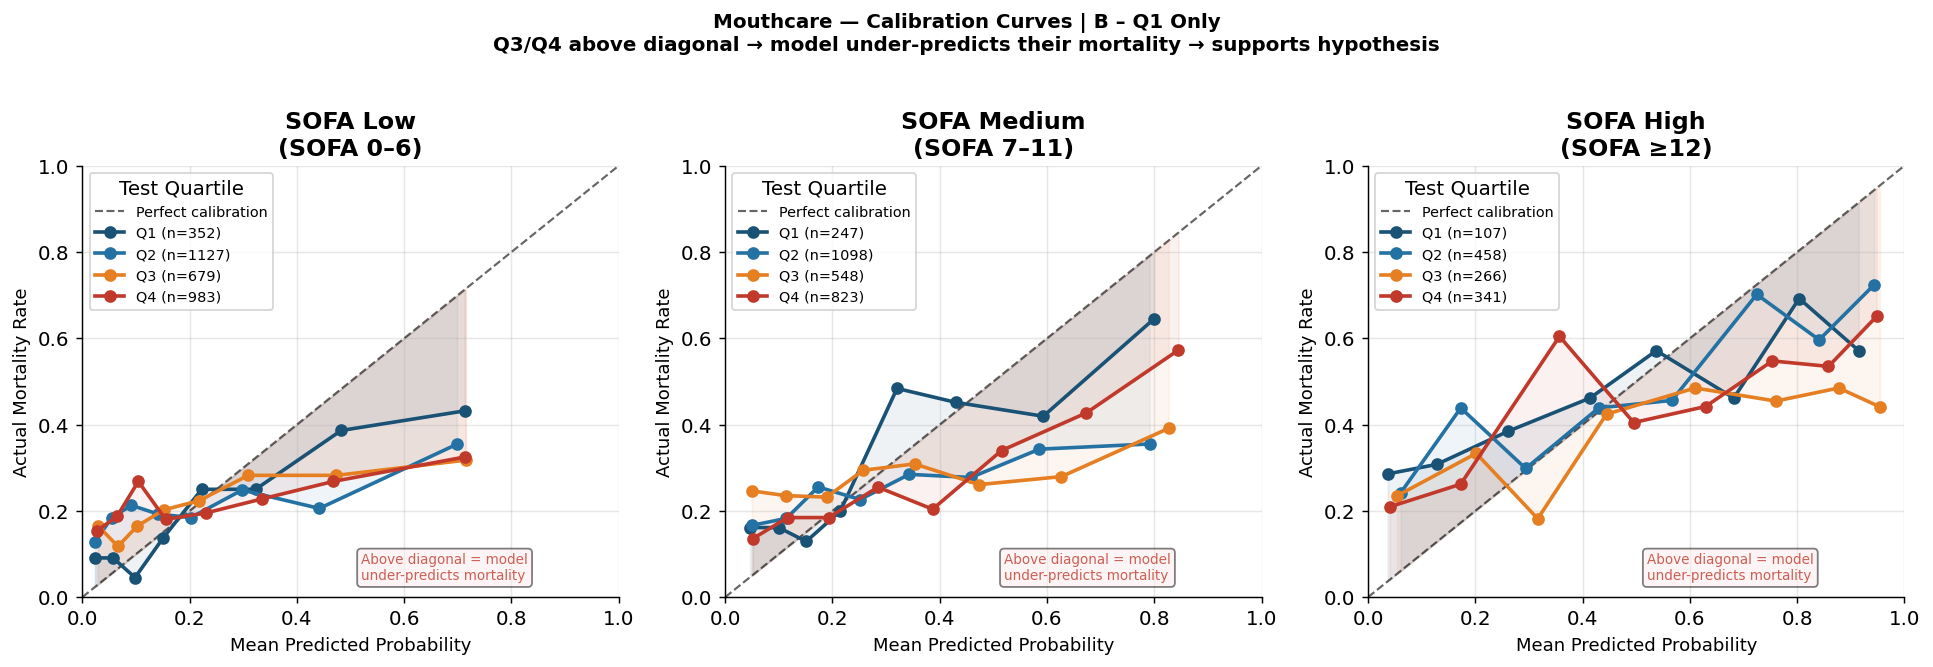

  Saved: figures\fig3_calibration_mouthcare_modelB.png


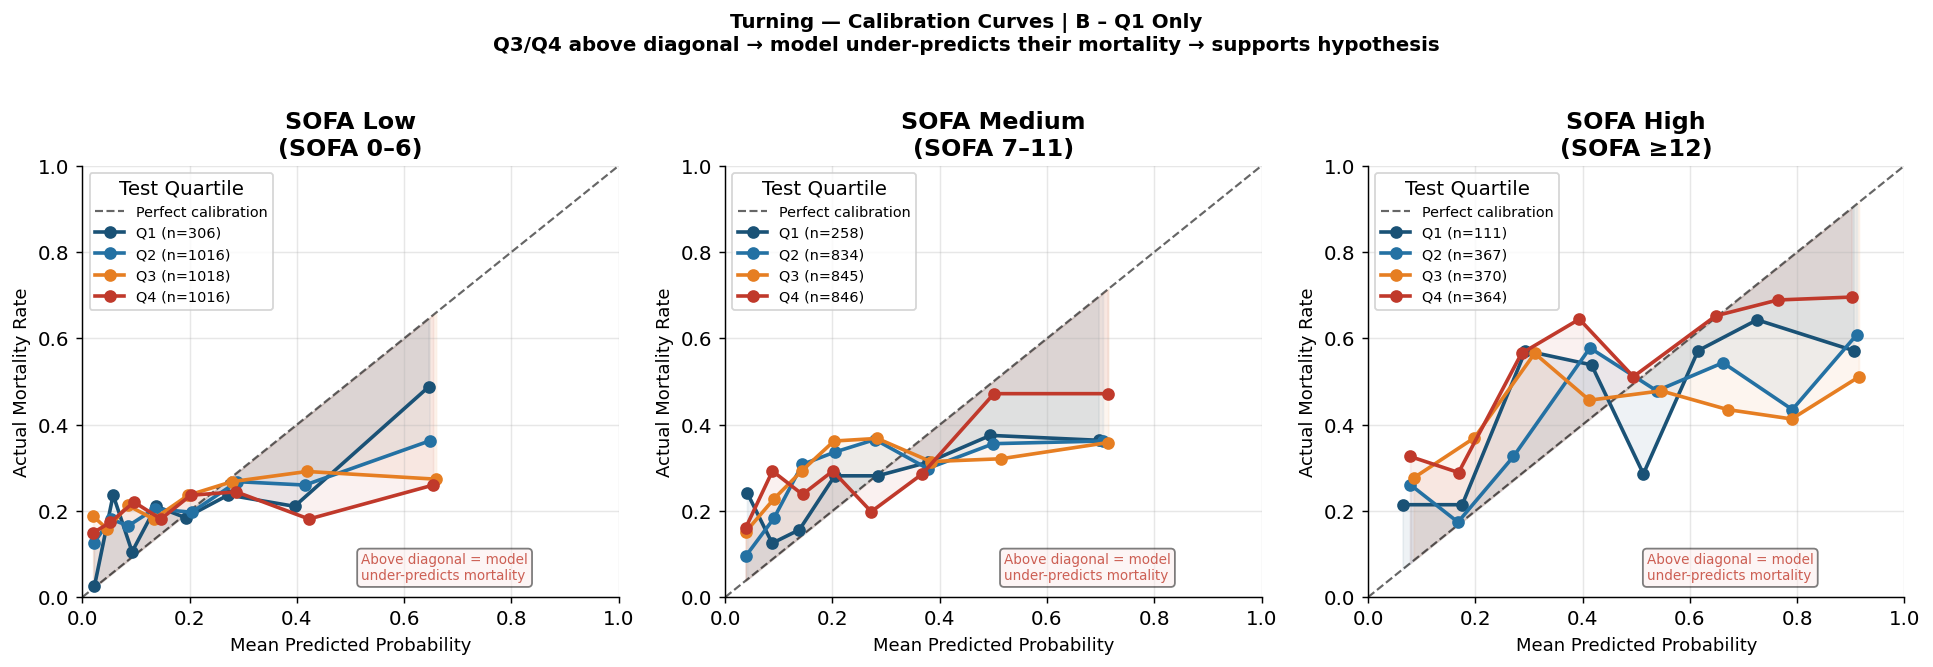

  Saved: figures\fig3_calibration_turning_modelB.png


In [15]:
def plot_calibration_grid(care_label, model_name, save_path):
    sevs = SEVERITY_LABELS
    fig, axes = plt.subplots(1, len(sevs), figsize=(5*len(sevs), 5))

    for ax, sev in zip(axes, sevs):
        entries = [(g,yt,yp) for (cl,sl,mn,gt,g,yt,yp) in calibration_store
           if cl==care_label and sl==sev and mn==model_name and gt=='quartile']
        ax.plot([0,1],[0,1],'k--', lw=1.2, label='Perfect calibration', alpha=0.6)
        for q, yt, yp in sorted(entries, key=lambda x: x[0]):
            if len(yt) < 20:
                continue
            try:
                fp, mp = calibration_curve(np.array(yt), np.array(yp),
                                           n_bins=8, strategy='quantile')
                col = Q_COLOURS.get(q,'grey')
                ax.plot(mp, fp, marker='o', lw=2, color=col,
                        label=f'{q} (n={len(yt)})', markersize=6)
                ax.fill_between(mp, mp, fp, alpha=0.07, color=col)
            except:
                pass
        ax.set_xlabel('Mean Predicted Probability', fontsize=10)
        ax.set_ylabel('Actual Mortality Rate', fontsize=10)
        ax.set_title(f'SOFA {sev}\n(SOFA {"0–6" if sev=="Low" else "7–11" if sev=="Medium" else "≥12"})',
                     fontweight='bold')
        ax.legend(title='Test Quartile', fontsize=8)
        ax.set_xlim(0,1); ax.set_ylim(0,1)
        ax.text(0.52,0.04,'Above diagonal = model\nunder-predicts mortality',
                fontsize=7.5,color='#C0392B',alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3',facecolor='#FDEDEC',alpha=0.5))

    fig.suptitle(f'{care_label} — Calibration Curves | {model_name}\n'
                 f'Q3/Q4 above diagonal → model under-predicts their mortality → supports hypothesis',
                 fontsize=11, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'  Saved: {save_path}')

for care in ['Mouthcare','Turning']:
    plot_calibration_grid(
        care, 'B – Q1 Only',
        os.path.join(OUTPUT_FOLDER, f'fig3_calibration_{care.lower()}_modelB.png')
    )

## 12. Feature Importance — SHAP Analysis

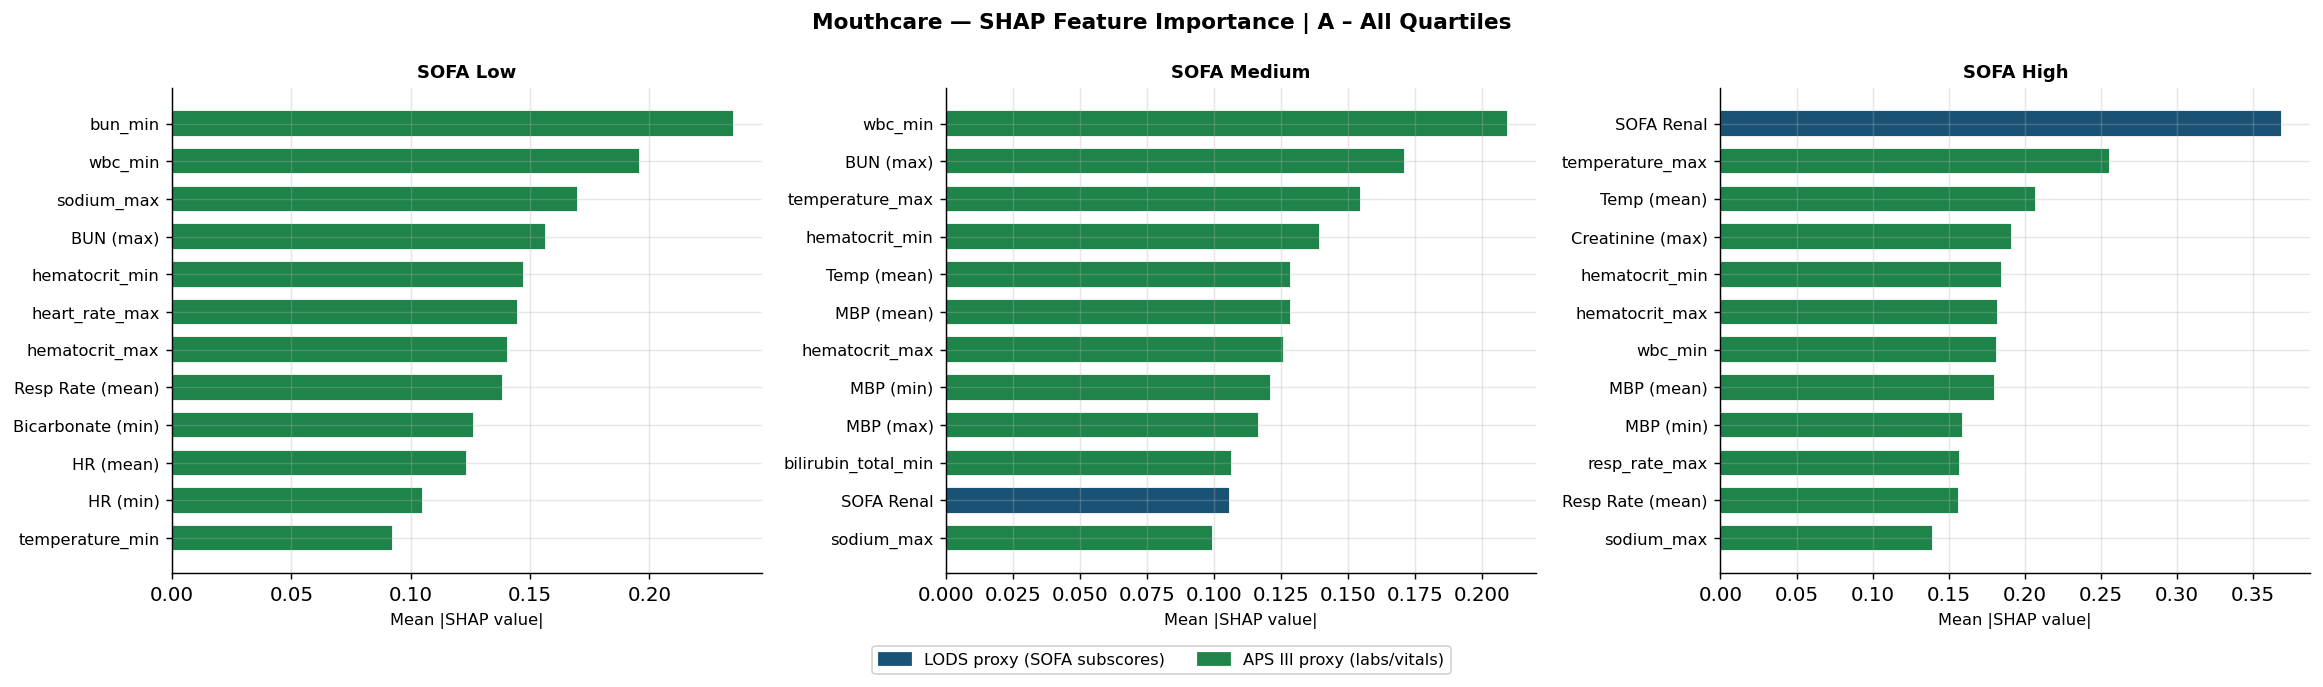

  Saved: figures\fig4_shap_mouthcare_modelA.png


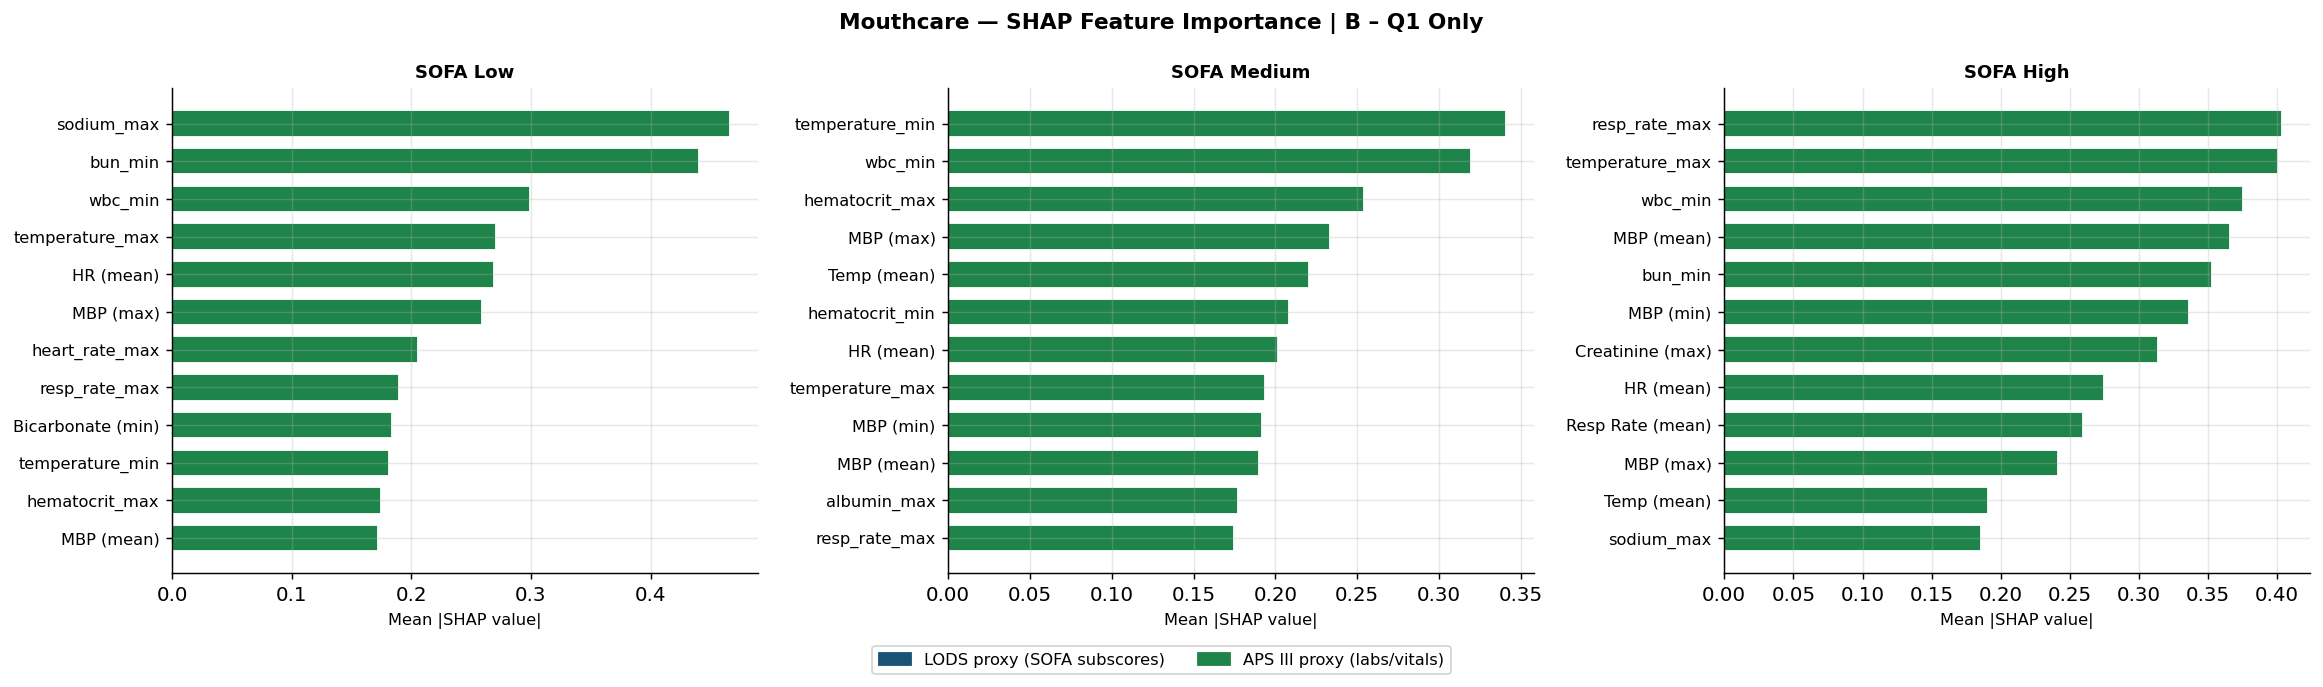

  Saved: figures\fig4_shap_mouthcare_modelB.png


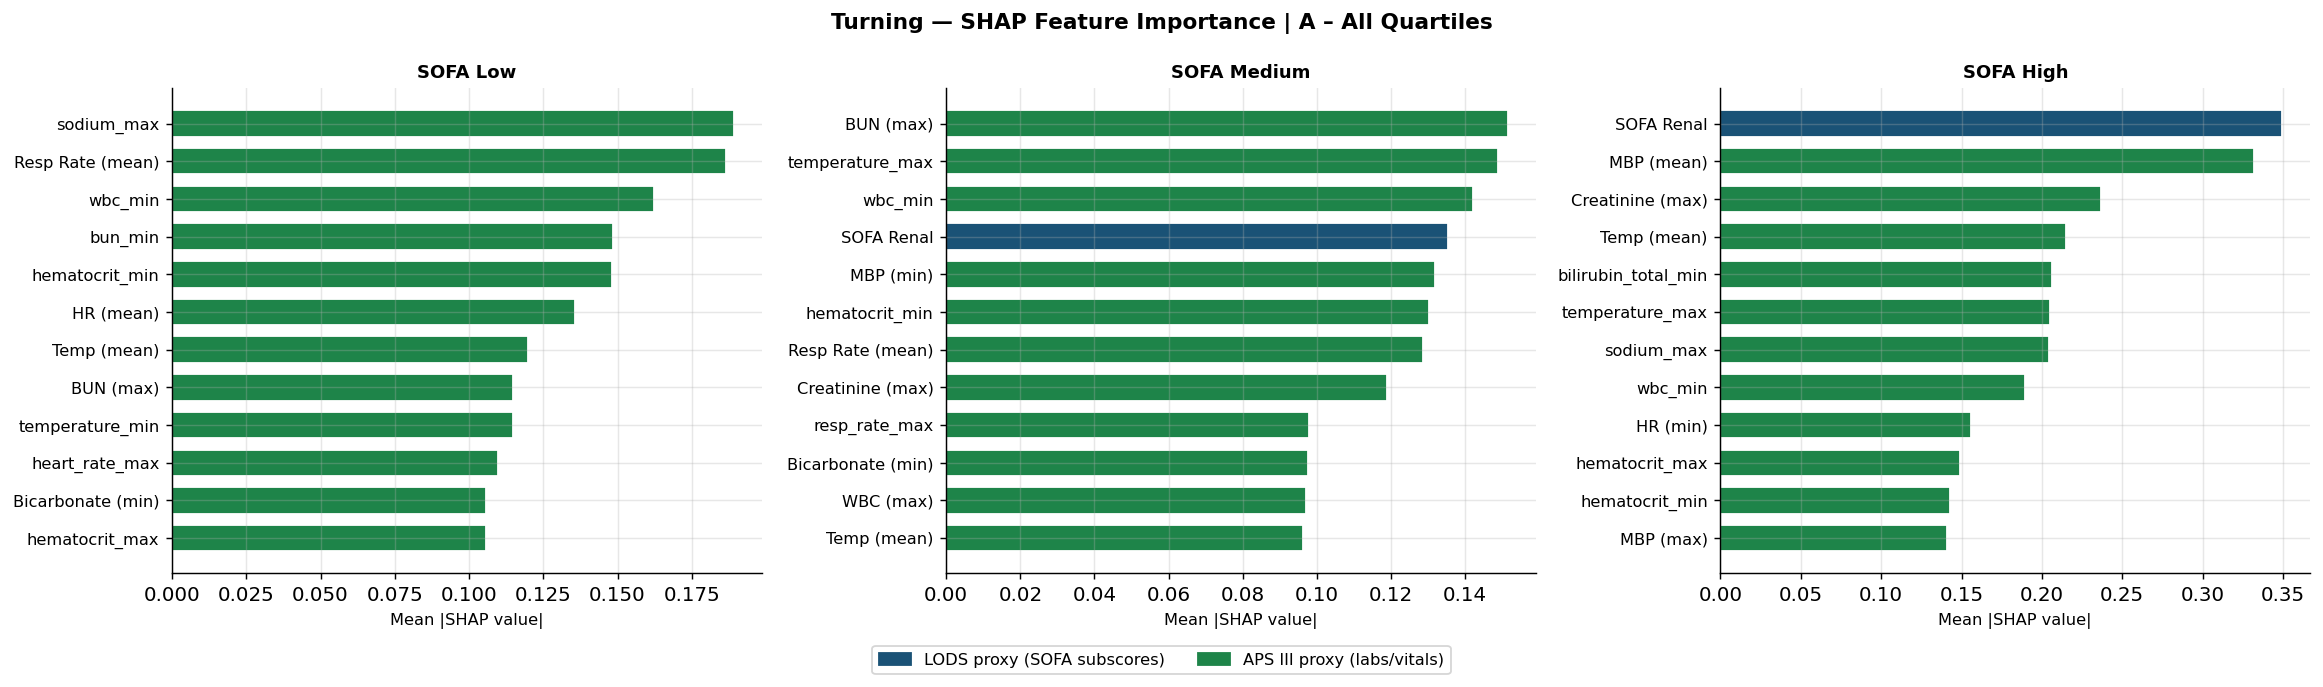

  Saved: figures\fig4_shap_turning_modelA.png


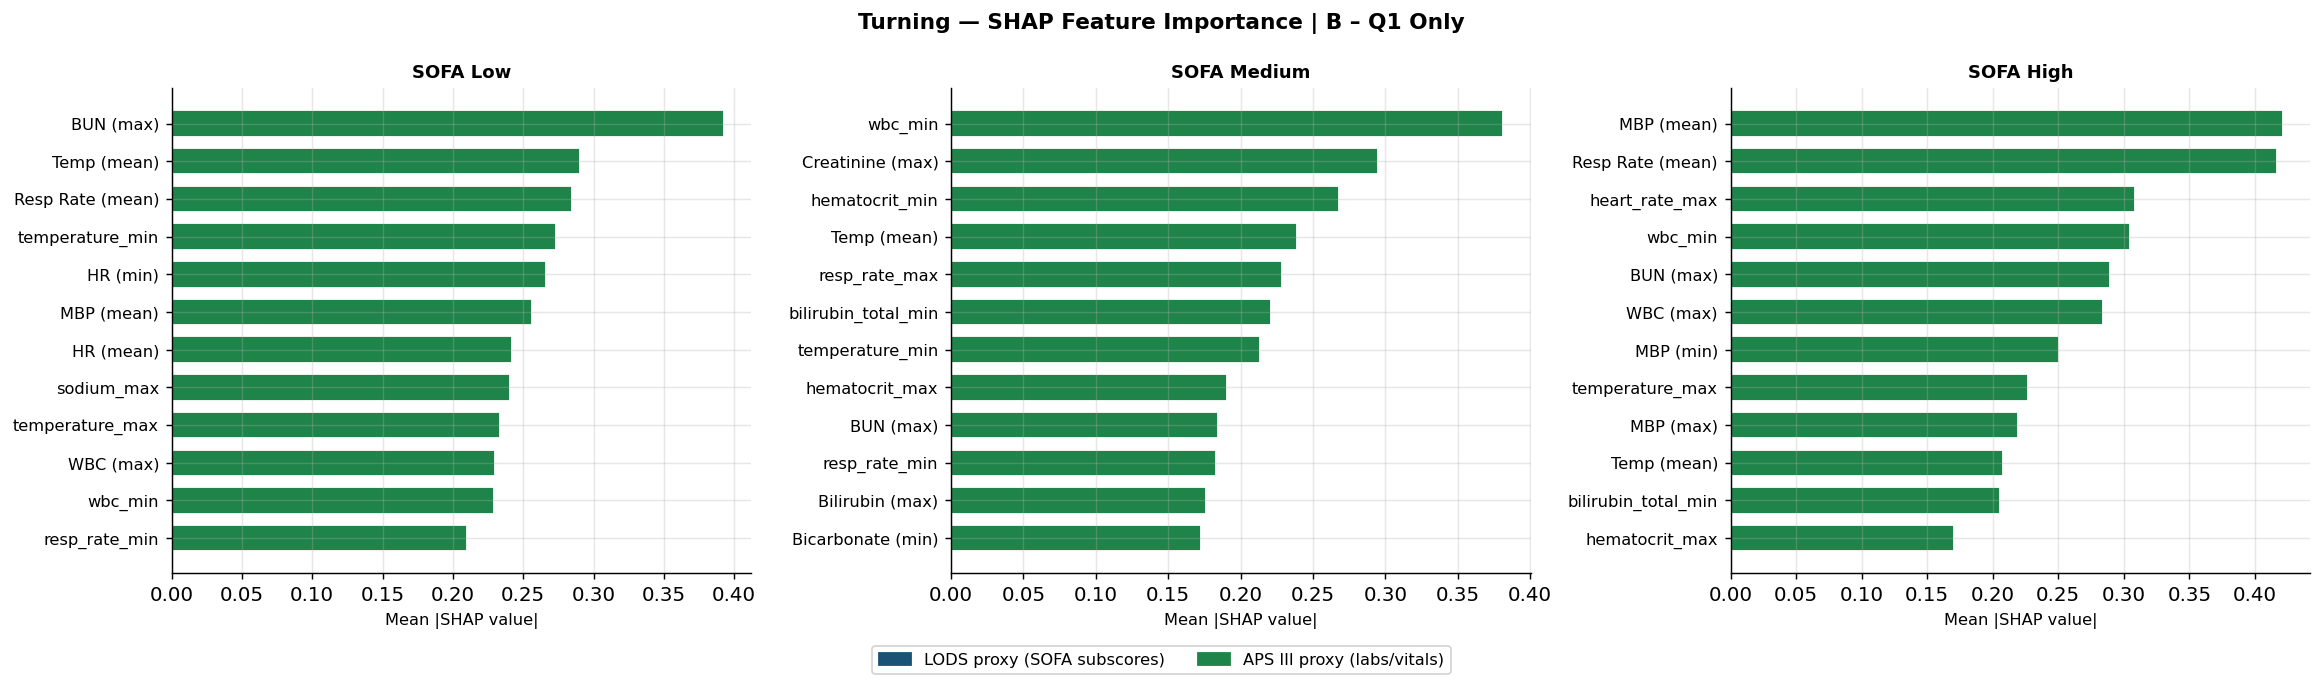

  Saved: figures\fig4_shap_turning_modelB.png


In [16]:
RENAME = {
    'gcs_min':'GCS (min)','respiration':'SOFA Respiration',
    'cardiovascular':'SOFA Cardiovascular','cns':'SOFA CNS',
    'renal':'SOFA Renal','liver':'SOFA Liver','coagulation':'SOFA Coagulation',
    'mbp_min':'MBP (min)','mbp_mean':'MBP (mean)','mbp_max':'MBP (max)',
    'heart_rate_min':'HR (min)','heart_rate_mean':'HR (mean)',
    'resp_rate_mean':'Resp Rate (mean)','temperature_mean':'Temp (mean)',
    'creatinine_max':'Creatinine (max)','bun_max':'BUN (max)',
    'albumin_min':'Albumin (min)','bicarbonate_min':'Bicarbonate (min)',
    'bilirubin_total_max':'Bilirubin (max)','wbc_max':'WBC (max)',
}
SOFA_SET = {'SOFA Respiration','SOFA Cardiovascular','SOFA CNS',
            'SOFA Renal','SOFA Liver','SOFA Coagulation'}

def plot_shap_grid(care_label, model_name, save_path, top_n=12):
    sevs = [s for s in SEVERITY_LABELS
            if (care_label, s, model_name) in shap_store]
    if not sevs:
        print(f'  No SHAP data for {care_label} | {model_name}')
        return
    fig, axes = plt.subplots(1, len(sevs), figsize=(6*len(sevs), 5))
    if len(sevs) == 1:
        axes = [axes]
    for ax, sev in zip(axes, sevs):
        model, X_train, feats = shap_store[(care_label, sev, model_name)]
        sample = X_train.sample(min(400, len(X_train)), random_state=RANDOM_STATE)
        explainer   = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(sample)
        mean_abs    = pd.Series(np.abs(shap_values).mean(axis=0), index=feats)
        top         = mean_abs.nlargest(top_n).sort_values()
        top.index   = [RENAME.get(f,f) for f in top.index]
        colors      = ['#1A5276' if f in SOFA_SET else '#1E8449' for f in top.index]
        ax.barh(range(len(top)), top.values, color=colors, edgecolor='white', height=0.7)
        ax.set_yticks(range(len(top)))
        ax.set_yticklabels(top.index, fontsize=9)
        ax.set_xlabel('Mean |SHAP value|', fontsize=9)
        ax.set_title(f'SOFA {sev}', fontweight='bold', fontsize=10)
    patch1 = mpatches.Patch(color='#1A5276', label='LODS proxy (SOFA subscores)')
    patch2 = mpatches.Patch(color='#1E8449', label='APS III proxy (labs/vitals)')
    fig.legend(handles=[patch1,patch2], fontsize=9,
               loc='lower center', bbox_to_anchor=(0.5,-0.05), ncol=2)
    fig.suptitle(f'{care_label} — SHAP Feature Importance | {model_name}',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'  Saved: {save_path}')

for care in ['Mouthcare','Turning']:
    for mname, mshort in [('A – All Quartiles','A'),('B – Q1 Only','B')]:
        plot_shap_grid(care, mname,
                       os.path.join(OUTPUT_FOLDER, f'fig4_shap_{care.lower()}_model{mshort}.png'))

## 13. Results Export

In [17]:
HDR_BG='1F3864'; HDR_FG='FFFFFF'; DARK_BG='2E4057'; BORDER='BDC3C7'
SEV_BG  = {'Low':'EBF5FB','Medium':'FEF9E7','High':'FDEDEC'}
MOD_BG  = {'A – All Quartiles':'D6E4F0','B – Q1 Only':'D5F5E3'}
thin    = Border(left=Side('thin',color=BORDER),right=Side('thin',color=BORDER),
                 top=Side('thin',color=BORDER), bottom=Side('thin',color=BORDER))

DISP_COLS = ['Care Type','Severity','Model','Test Set','N','Mortality%',
             'AUROC_CI','Sensitivity','Specificity','PPV','NPV','F1']
DISP_COLS = [c for c in DISP_COLS if c in results_df.columns]
COL_W     = {'Care Type':13,'Severity':10,'Model':22,'Test Set':20,'N':7,
             'Mortality%':12,'AUROC_CI':28,'Sensitivity':28,'Specificity':28,
             'PPV':28,'NPV':28,'F1':28}

def write_sheet(ws, df, title):
    cols = list(df.columns); nc = len(cols)
    ws.merge_cells(start_row=1,start_column=1,end_row=1,end_column=nc)
    c=ws.cell(1,1,title)
    c.font=Font('Calibri',bold=True,size=13,color=HDR_FG)
    c.fill=PatternFill('solid',fgColor=DARK_BG)
    c.alignment=Alignment(horizontal='center',vertical='center')
    ws.row_dimensions[1].height=24
    for ci,cn in enumerate(cols,1):
        c=ws.cell(2,ci,cn)
        c.font=Font('Calibri',bold=True,size=10,color=HDR_FG)
        c.fill=PatternFill('solid',fgColor=HDR_BG)
        c.alignment=Alignment(horizontal='center',vertical='center',wrap_text=True)
        c.border=thin
    ws.row_dimensions[2].height=34
    for ri,(_,row) in enumerate(df.iterrows(),3):
        sev=str(row.get('Severity',''))
        mod=str(row.get('Model',''))
        bg=MOD_BG.get(mod, SEV_BG.get(sev,'F8F9FA'))
        for ci,cn in enumerate(cols,1):
            val=row[cn]; c=ws.cell(ri,ci,val)
            c.font=Font('Calibri',size=10,bold=(cn=='AUROC_CI'))
            c.fill=PatternFill('solid',fgColor=bg)
            c.border=thin
            c.alignment=Alignment(
                horizontal='left' if cn in ('Care Type','Severity','Model','Test Set') else 'center',
                vertical='center')
        ws.row_dimensions[ri].height=18
    for ci,cn in enumerate(cols,1):
        ws.column_dimensions[get_column_letter(ci)].width=COL_W.get(cn,14)
    ws.freeze_panes='A3'

display_df = results_df[DISP_COLS]
wb = Workbook()
wb.remove(wb.active)

sheets = [
    ('All Results',     display_df,  'All Results — Mouthcare & Turning'),
    ('Mortality Table', mort_tbl,    'Mortality by Severity × Quartile (within-severity Q assignment)'),
]
for care in ['Mouthcare','Turning']:
    for sev in SEVERITY_LABELS:
        sub = display_df[
            (display_df['Care Type']==care) & (display_df['Severity']==sev)
        ]
        if len(sub)==0: continue
        sofa_range = {'Low':'0–6','Medium':'7–11','High':'≥12'}[sev]
        sheets.append((
            f'{care[:4]} – {sev}',
            sub,
            f'{care} | {sev} Severity (SOFA {sofa_range})'
        ))

for sname, df_s, title in sheets:
    ws = wb.create_sheet(title=sname)
    write_sheet(ws, df_s.reset_index(drop=True), title)
    print(f'   Sheet "{sname}" ({len(df_s)} rows)')

wb.save(OUTPUT_EXCEL)
print(f'\n Excel saved : {os.path.abspath(OUTPUT_EXCEL)}')
print(f' Figures in  : {os.path.abspath(OUTPUT_FOLDER)}/')

   Sheet "All Results" (108 rows)
   Sheet "Mortality Table" (24 rows)
   Sheet "Mout – Low" (18 rows)
   Sheet "Mout – Medium" (18 rows)
   Sheet "Mout – High" (18 rows)
   Sheet "Turn – Low" (18 rows)
   Sheet "Turn – Medium" (18 rows)
   Sheet "Turn – High" (18 rows)

 Excel saved : c:\Users\nacha\Downloads\mortality_results.xlsx
 Figures in  : c:\Users\nacha\Downloads\figures/


## 14. Interpretation Framework

### Primary evidence criteria

| Evidence | Source | Criterion supporting hypothesis |
|---|---|---|
| Mortality gradient | Section 8 — Mortality Table | Mortality rate increases Q1 to Q4 within each severity stratum |
| Severity balance | Section 5 output | Mean SOFA score is comparable across Q1–Q4 within each stratum |
| Model B discrimination | Section 9–10 — AUROC plots | AUROC decreases from Q1 to Q4 for Model B within each severity stratum |
| Calibration breakdown | Section 11 — Calibration curves | Q3/Q4 points fall above the diagonal for Model B |
| Feature validity | Section 12 — SHAP | SOFA subscores and clinical severity features dominate model predictions |

---

### Definitions

- **Q1**: Highest care frequency (smallest mean interval between care events)
- **Q4**: Lowest care frequency (largest mean interval between care events)
- **Severity strata**: Low = SOFA 0–6 | Medium = SOFA 7–11 | High = SOFA ≥12

---

### Justification of SOFA cut-points

The severity cut-points used in this analysis align with the Sepsis-3 consensus definition (Singer et al., *JAMA*, 2016), in which a SOFA score ≥2 defines acute organ dysfunction. The thresholds of 0–6 (low), 7–11 (medium), and ≥12 (high) reflect clinically meaningful strata corresponding to absent or minimal dysfunction, moderate multi-organ failure, and severe dysfunction with substantially elevated predicted mortality, respectively. The use of pre-specified, clinically grounded cut-points avoids data-driven threshold selection and supports comparability with published critical care literature.